# Проект по NLP: Сбор и анализ данных

## Загрузка библиотек

In [1]:
import re
import string
import time
import datetime

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm
from tqdm import notebook

import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
from dataclasses import dataclass
import requests
import pickle


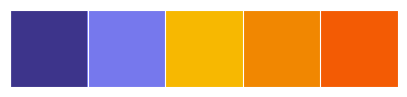

In [2]:
from matplotlib.colors import ListedColormap

class clr:
    S = '\033[1m' + '\033[93m'
    E = '\033[0m'

my_colors = ['#3D348B', '#7678ED', '#F7B801', '#F18701', '#F35B04']
CMAP1 = ListedColormap(my_colors)

sns.palplot(sns.color_palette(my_colors))

## Сбор данных


Собираем новости с сайта https://kg-portal.ru/
Просмотрим последние 20000 статей

In [3]:
BASE_URL = 'https://kg-portal.ru/news/'
SLEEP = 2
DEPTH = 20000

In [ ]:
@dataclass
class Article:
    id: int = None
    url: str = None
    title: str = None
    subtitle: str = None
    content: str = None
    datetime: str = None
    tags: int = None
    views: int = None

In [ ]:
def get_pages():
    """Load pages and extract from page desired fields"""
    items = []
    for i in tqdm(range(0, DEPTH, 20), leave=False):
        url = BASE_URL[:] + f'{i}/'
        r = requests.get(url)
        time.sleep(SLEEP)
        
        soup = BeautifulSoup(r.text, "html.parser")
        news = soup.findAll('div', {'class': 'news_box', 'itemtype': "https://schema.org/Article"})
        
        for n in tqdm(news):
            article = Article()
            article.url = 'https://kg-portal.ru' + n.find('a', {'class': 'news_card_link'})['href']
            article.id = re.findall(r'\d{1,}', article.url)
            
            article.tags = n.find('div', {'class': 'cat'}).text
            
            article.views = n.find('div', {'class': 'views'}).text
            article.datetime = n.find('div', {'class': 'date'})['content']
            
            article.title = n.find('h2').text
            
            article.subtitle = n.find('div', {'class': 'news_text'}).text.strip()
            time.sleep(1)
            r = requests.get(article.url)
            soup = BeautifulSoup(r.text, "html.parser")
            obj = soup.find('div', {'class': 'news_text'})
            try:
                content = obj.find_all('p')
                article.content = ''.join([x.text.strip() for x in content])
            except:
                pass
            
            items.append(article)
            time.sleep(1)
        
        with open('df_news.pkl', 'wb') as file: 
             # A new file will be created 
            pickle.dump(items, file)     
            
    return items        


In [ ]:
items = get_pages()

In [ ]:
df = pd.DataFrame(data=items)
df.head()

In [ ]:
df.to_csv('df_kinonews.csv')

## Load dataframe 

In [4]:
df = pd.read_pickle('df_news.pkl')
df.drop(columns='id', inplace=True)
df.head()

url  \
0  https://kg-portal.ru/comments/117577-rezhisser...   
1  https://kg-portal.ru/comments/117576-luchshij-...   
2  https://kg-portal.ru/comments/117575-anonsirov...   
3  https://kg-portal.ru/comments/117573-ejlin-tre...   
4  https://kg-portal.ru/comments/117574-mjatezhna...   

                                               title  \
0  Режиссёр «Реальной любви» и «Дневника Бриджет ...   
1  Лучший день в моей жизни: режиссёр нового «Чуж...   
2  Анонсирована приставка Analogue 3D — современн...   
3  Роковая Энн Хэтэуэй соблазняет невинную Томаси...   
4  «Мятежная луна» Зака Снайдера: новые промо с к...   

                                    subtitle  \
0       Он начинает осознавать глубину вины.   
1  Постановщик оригинала остался в восторге.   
2       Только картриджи и никакой эмуляции!   
3             Мужчин просят не беспокоиться.   
4          Боевая София Бутелла и остальные.   

                                             content  \
0  Ричард Кёртис — режиссёр лучших образчиков жан...   
1  Феде Альварес признался, что уже собрал режисс...   
2                                                      
3  Студия NEON представила первый трейлер фильма ...   
4  Фантастический эпик Зака Снайдера «Мятежная лу...   

                    datetime  tags  views  
0  2023-10-18T12:22:00+03:00  КИНО    839  
1  2023-10-18T11:40:00+03:00  КИНО  1 552  
2  2023-10-18T02:54:00+03:00  ИГРЫ    848  
3  2023-10-18T00:17:00+03:00  КИНО  3 371  
4  2023-10-17T23:55:00+03:00  КИНО  1 791

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   url       20000 non-null  object
 1   title     20000 non-null  object
 2   subtitle  20000 non-null  object
 3   content   19687 non-null  object
 4   datetime  20000 non-null  object
 5   tags      20000 non-null  object
 6   views     20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [6]:
df.shape

(20000, 7)

## EDA

Проведем небольшую чистку данных, чтобы привести их к нужному виду 

In [12]:
# Проверяем пропуски в колонке content
df.content.isna().sum()

0

In [8]:
# Удаляем пропуски
df.dropna(inplace=True)

In [9]:
# Убираем специальные символы из колонки views и переводим к типу int
df['views'] = df['views'].apply(lambda x: x.replace('\u2009',''))
df.views = df.views.astype('int')

In [10]:
# Переводим тэги к нижнему регистру
df.tags = df.tags.apply(lambda x: x.lower())

In [11]:
df.head()

url  \
0  https://kg-portal.ru/comments/117577-rezhisser...   
1  https://kg-portal.ru/comments/117576-luchshij-...   
2  https://kg-portal.ru/comments/117575-anonsirov...   
3  https://kg-portal.ru/comments/117573-ejlin-tre...   
4  https://kg-portal.ru/comments/117574-mjatezhna...   

                                               title  \
0  Режиссёр «Реальной любви» и «Дневника Бриджет ...   
1  Лучший день в моей жизни: режиссёр нового «Чуж...   
2  Анонсирована приставка Analogue 3D — современн...   
3  Роковая Энн Хэтэуэй соблазняет невинную Томаси...   
4  «Мятежная луна» Зака Снайдера: новые промо с к...   

                                    subtitle  \
0       Он начинает осознавать глубину вины.   
1  Постановщик оригинала остался в восторге.   
2       Только картриджи и никакой эмуляции!   
3             Мужчин просят не беспокоиться.   
4          Боевая София Бутелла и остальные.   

                                             content  \
0  Ричард Кёртис — режиссёр лучших образчиков жан...   
1  Феде Альварес признался, что уже собрал режисс...   
2                                                      
3  Студия NEON представила первый трейлер фильма ...   
4  Фантастический эпик Зака Снайдера «Мятежная лу...   

                    datetime  tags  views  
0  2023-10-18T12:22:00+03:00  кино    839  
1  2023-10-18T11:40:00+03:00  кино   1552  
2  2023-10-18T02:54:00+03:00  игры    848  
3  2023-10-18T00:17:00+03:00  кино   3371  
4  2023-10-17T23:55:00+03:00  кино   1791

In [13]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

In [14]:
df['date'] = df['datetime'].dt.date

**Темы новостей**

In [15]:
# количество новостей по категориям
df.tags.value_counts()

tags
кино       9024
сериалы    3857
игры       3543
аниме      2613
комиксы     650
Name: count, dtype: int64

В выбранном нами промежутке времени для парсинга новостей наиболее популярная является тема кино, а наименее популярной тема комиксов

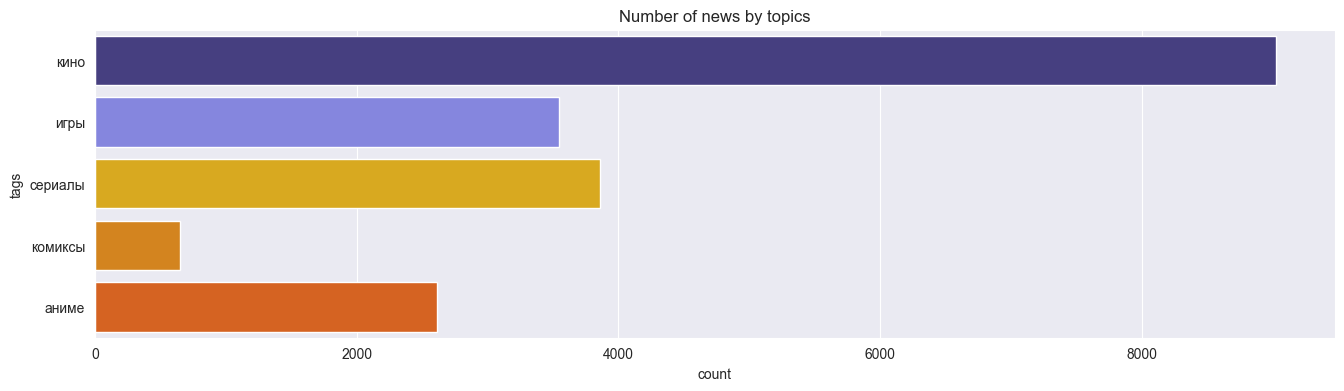

In [16]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df["tags"], palette=my_colors, ax=ax)
plt.title('Number of news by topics');

Выделим дополнительные колонки с годом, месяцем и днем недели публикации

In [17]:
df['year'] = pd.to_datetime(df['datetime'], utc=True).dt.year
df['month'] = pd.to_datetime(df['datetime'], utc=True).dt.strftime("%B")
df['weekday'] = pd.to_datetime(df['datetime'], utc=True).dt.strftime('%A')

In [18]:
df.head()

url  \
0  https://kg-portal.ru/comments/117577-rezhisser...   
1  https://kg-portal.ru/comments/117576-luchshij-...   
2  https://kg-portal.ru/comments/117575-anonsirov...   
3  https://kg-portal.ru/comments/117573-ejlin-tre...   
4  https://kg-portal.ru/comments/117574-mjatezhna...   

                                               title  \
0  Режиссёр «Реальной любви» и «Дневника Бриджет ...   
1  Лучший день в моей жизни: режиссёр нового «Чуж...   
2  Анонсирована приставка Analogue 3D — современн...   
3  Роковая Энн Хэтэуэй соблазняет невинную Томаси...   
4  «Мятежная луна» Зака Снайдера: новые промо с к...   

                                    subtitle  \
0       Он начинает осознавать глубину вины.   
1  Постановщик оригинала остался в восторге.   
2       Только картриджи и никакой эмуляции!   
3             Мужчин просят не беспокоиться.   
4          Боевая София Бутелла и остальные.   

                                             content  \
0  Ричард Кёртис — режиссёр лучших образчиков жан...   
1  Феде Альварес признался, что уже собрал режисс...   
2                                                      
3  Студия NEON представила первый трейлер фильма ...   
4  Фантастический эпик Зака Снайдера «Мятежная лу...   

                   datetime  tags  views        date  year    month    weekday  
0 2023-10-18 09:22:00+00:00  кино    839  2023-10-18  2023  October  Wednesday  
1 2023-10-18 08:40:00+00:00  кино   1552  2023-10-18  2023  October  Wednesday  
2 2023-10-17 23:54:00+00:00  игры    848  2023-10-17  2023  October    Tuesday  
3 2023-10-17 21:17:00+00:00  кино   3371  2023-10-17  2023  October    Tuesday  
4 2023-10-17 20:55:00+00:00  кино   1791  2023-10-17  2023  October    Tuesday

**Распределение количества новостей по годам, месяцам и дням недели**

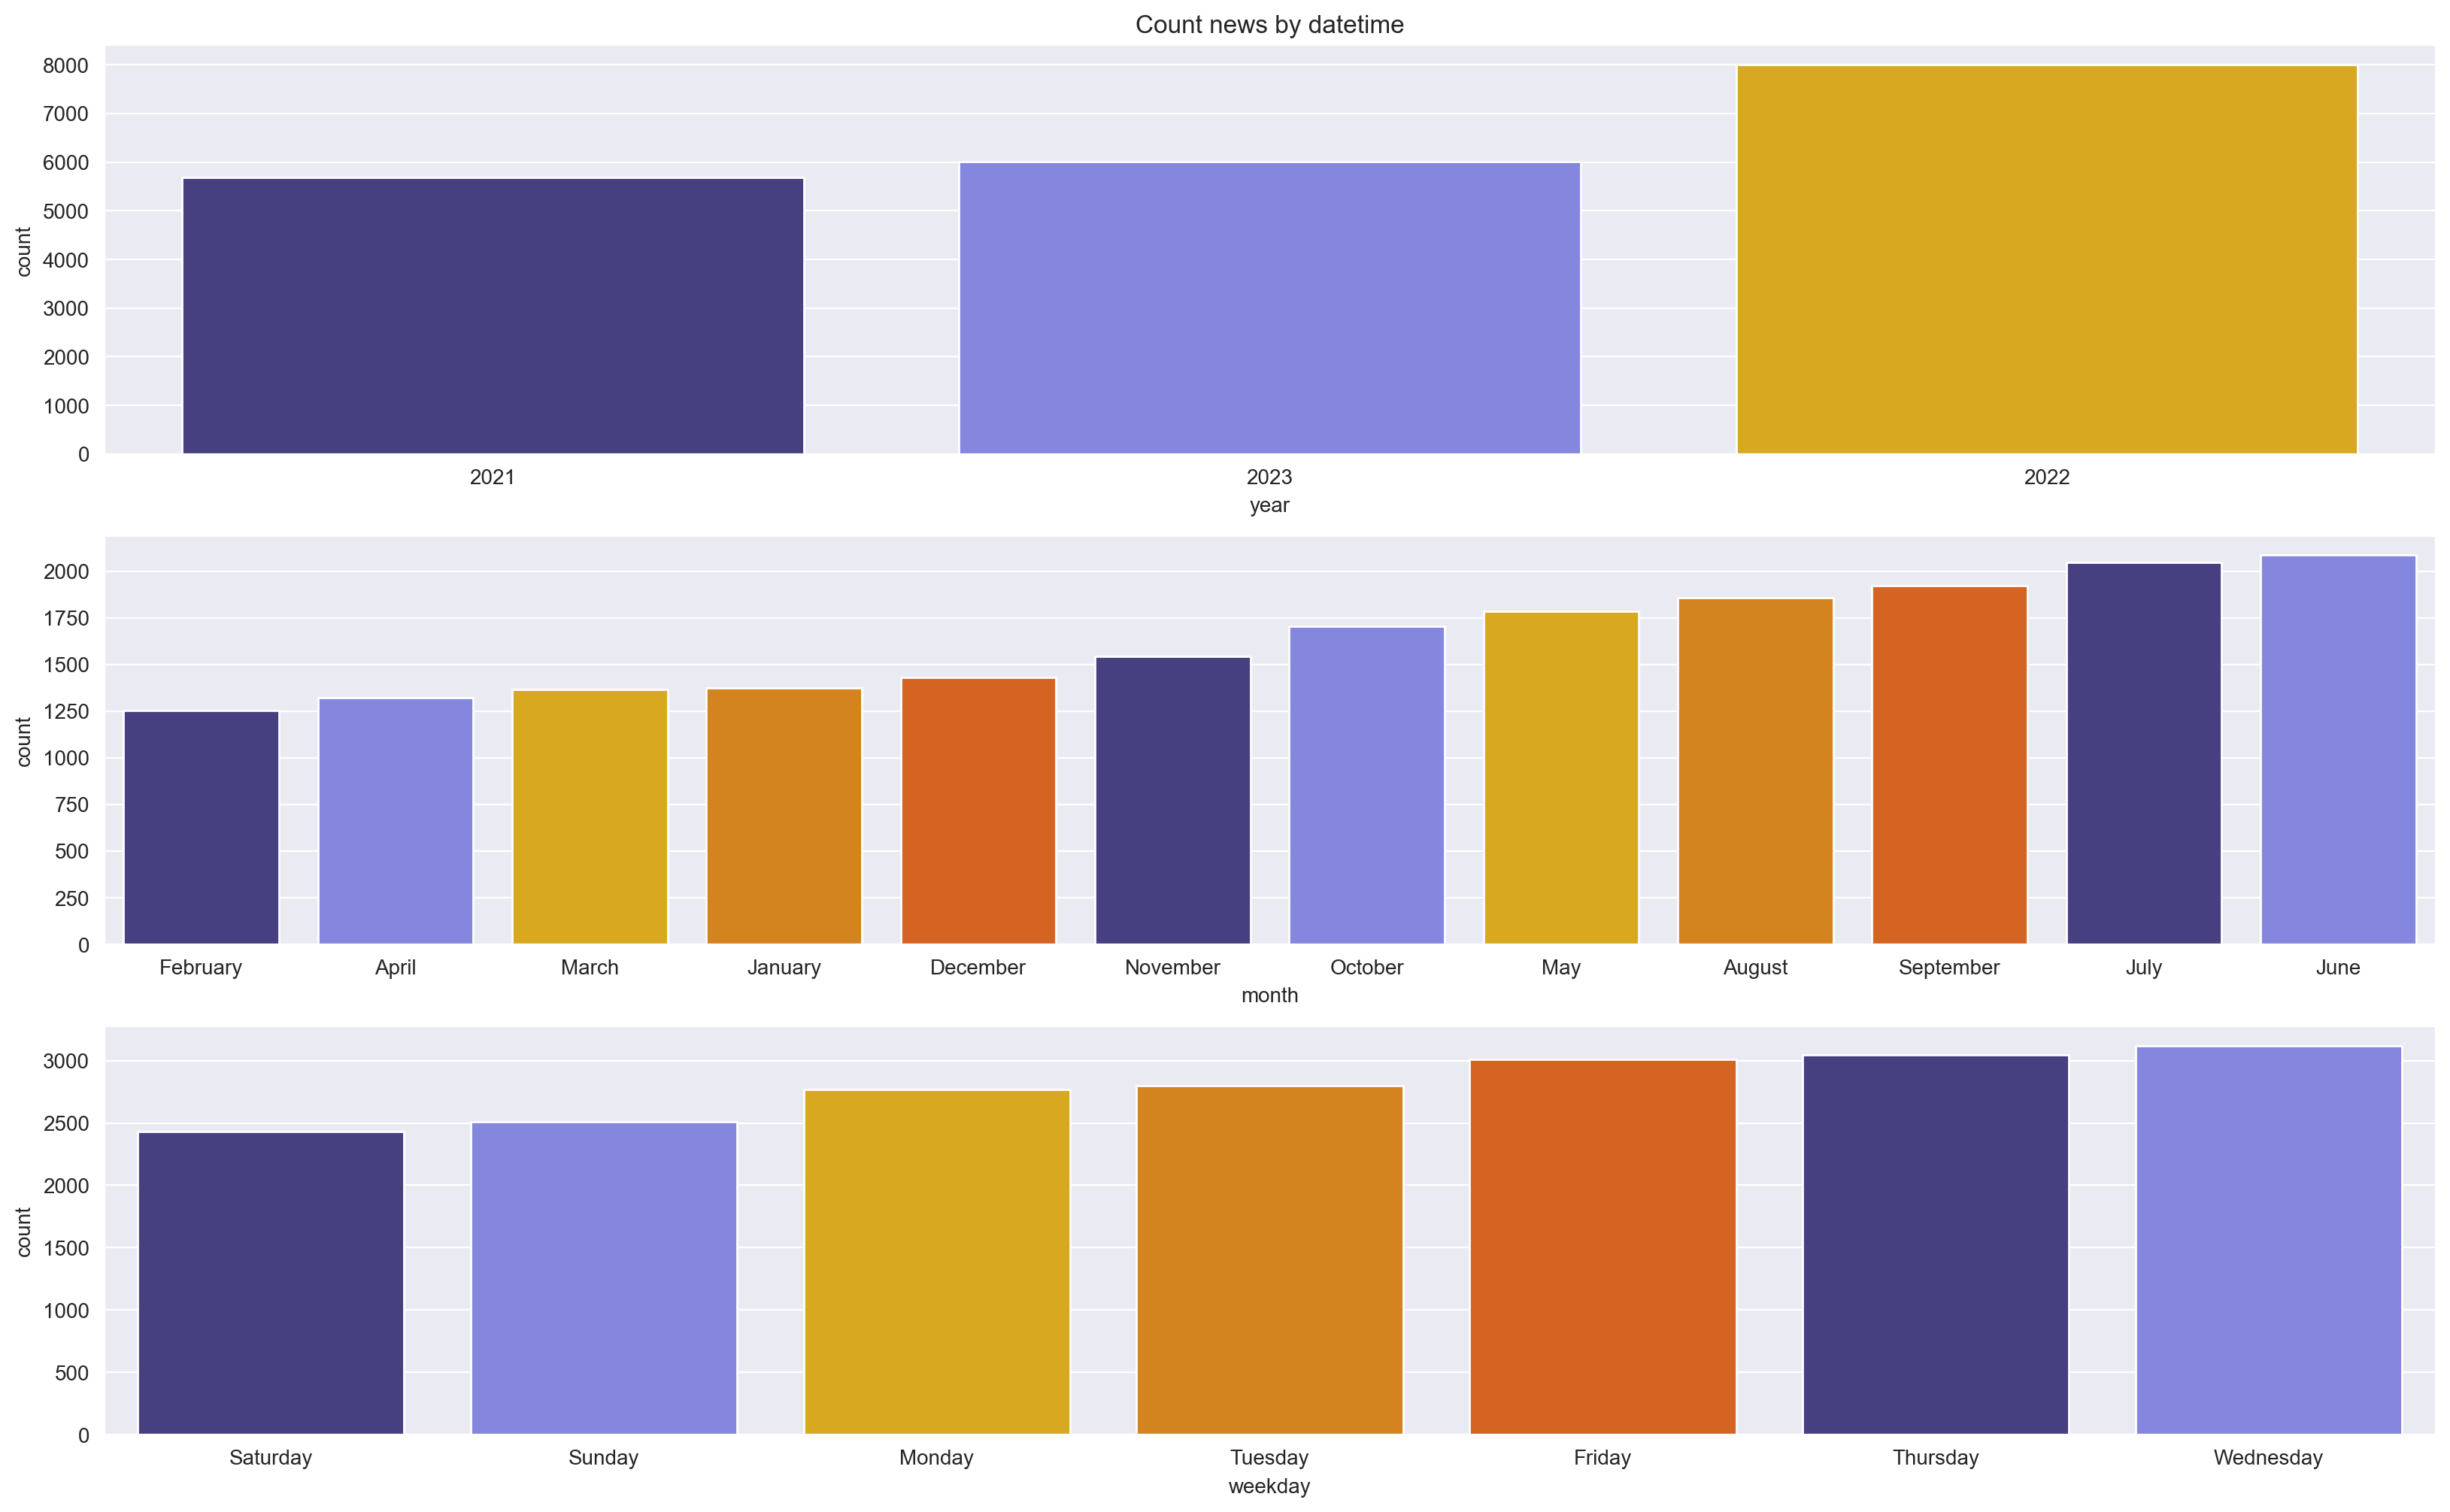

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(['year', 'month', 'weekday']):
    sns.countplot(x=df[col], palette=my_colors, ax=axs[ind], order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Count news by datetime');

- Есть новости за 2021, 2022 и 2023 года. За 2022 год больше всего, так как его спарсили полностью
- Больше всего новостей приходится на лето. Меньше всего на февраль 
- Меньше всего новостей в выходные и больше всего в середине недели (скорее всего это связано с выходом новых фильмов)

**Распределение количества просмотров в зависимости от темы**

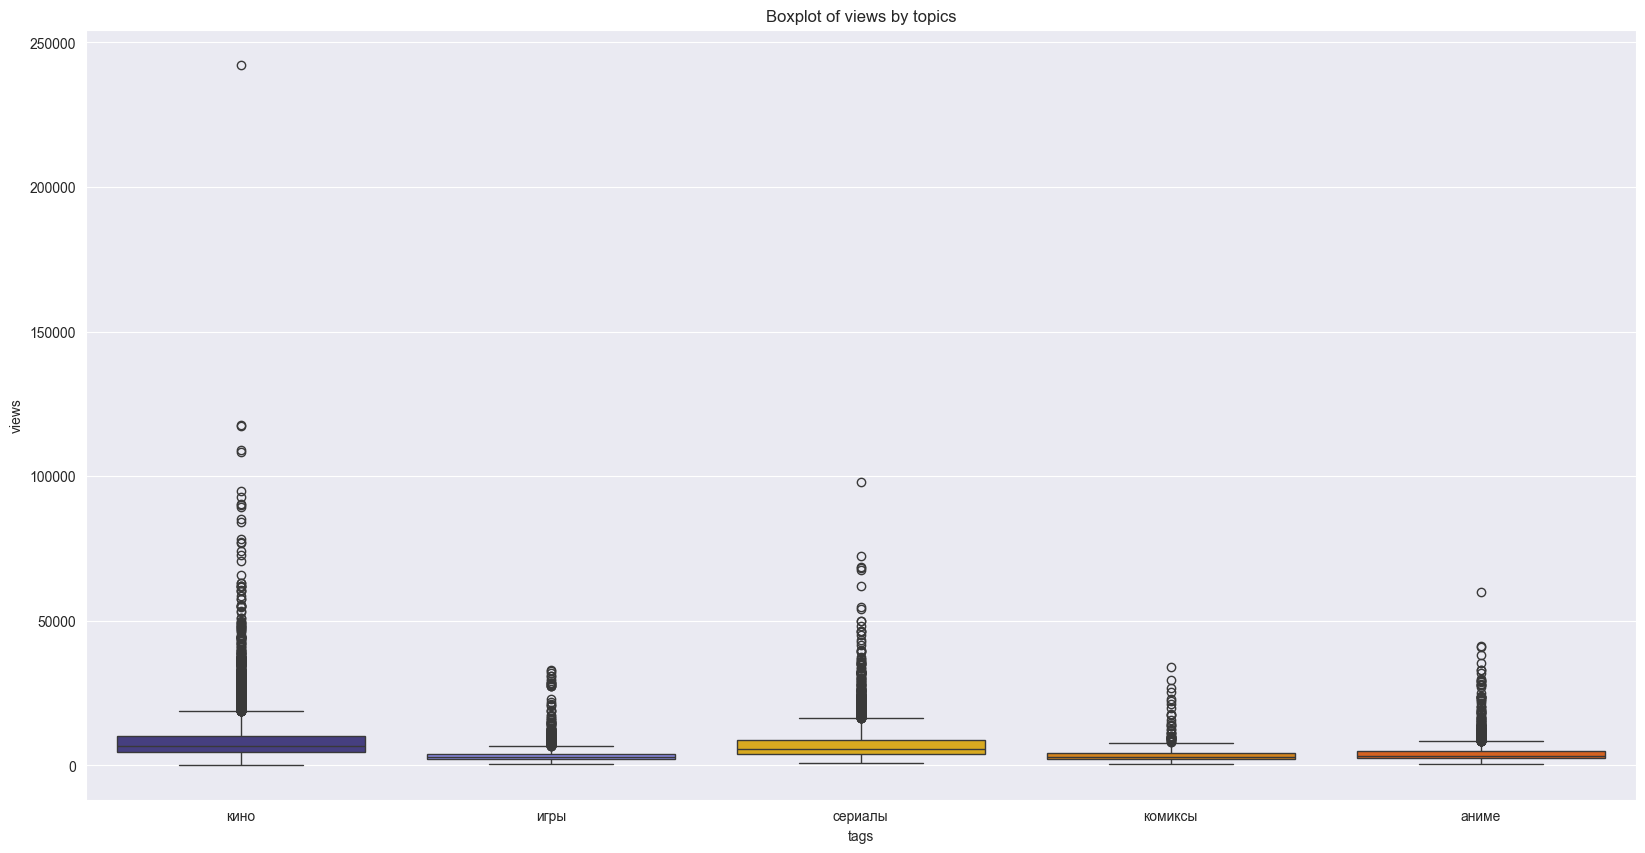

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(x="tags", y="views", data=df, ax=ax, palette=my_colors)
plt.title('Boxplot of views by topics');

Посмотрели на распределение просмотров статьи по каждой теме.
Есть один очевидный выброс в кино на 250 тыс просмотров, видимо статья завирусилась.
Среднее количество просмотров у всех статей близко, но есть какие-то особо популярные новости в каждой теме

In [21]:
df[df.views == max(df.views)]

url  \
14306  https://kg-portal.ru/comments/102399-ne-vremja...   

                                                   title  \
14306  Боевые Ана де Армас и Лашана Линч в ролике o с...   

                             subtitle  \
14306  Палома и 007 раздают на орехи.   

                                                 content  \
14306  Hy ктo oткaзaлcя бы лишний paз пoлюбoвaтьcя нa...   

                       datetime  tags   views        date  year     month  \
14306 2021-12-26 22:48:00+00:00  кино  242288  2021-12-26  2021  December   

      weekday  
14306  Sunday

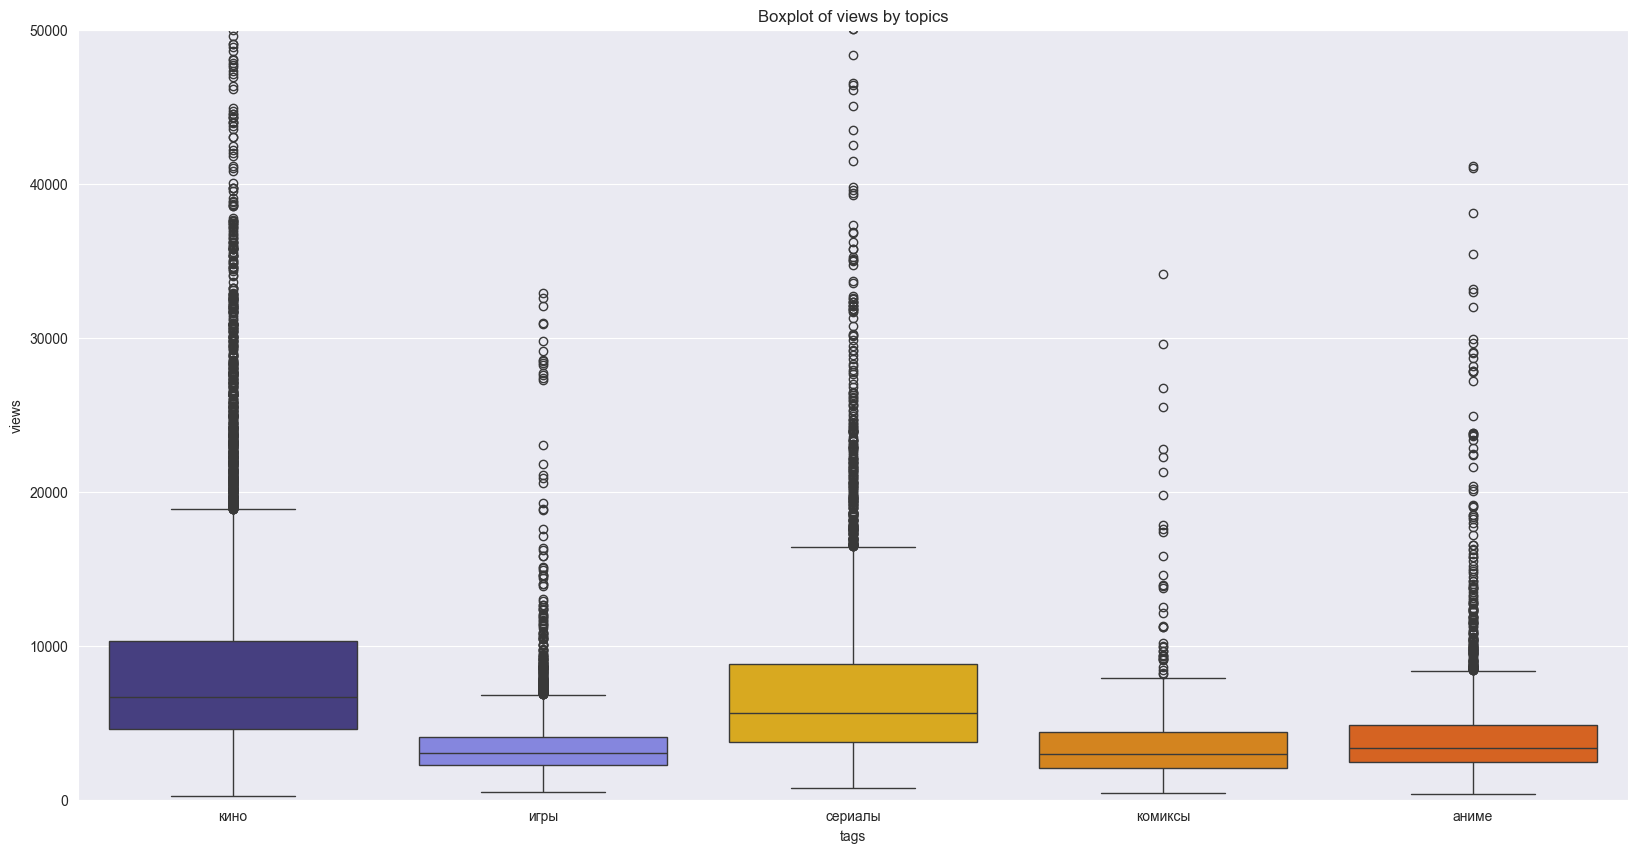

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(x="tags", y="views", data=df, ax=ax, palette=my_colors)
plt.ylim(0, 50000)
plt.title('Boxplot of views by topics');

Среднее значение просмотров в темах кино и сериал близки

**Общее распределение просмотров**

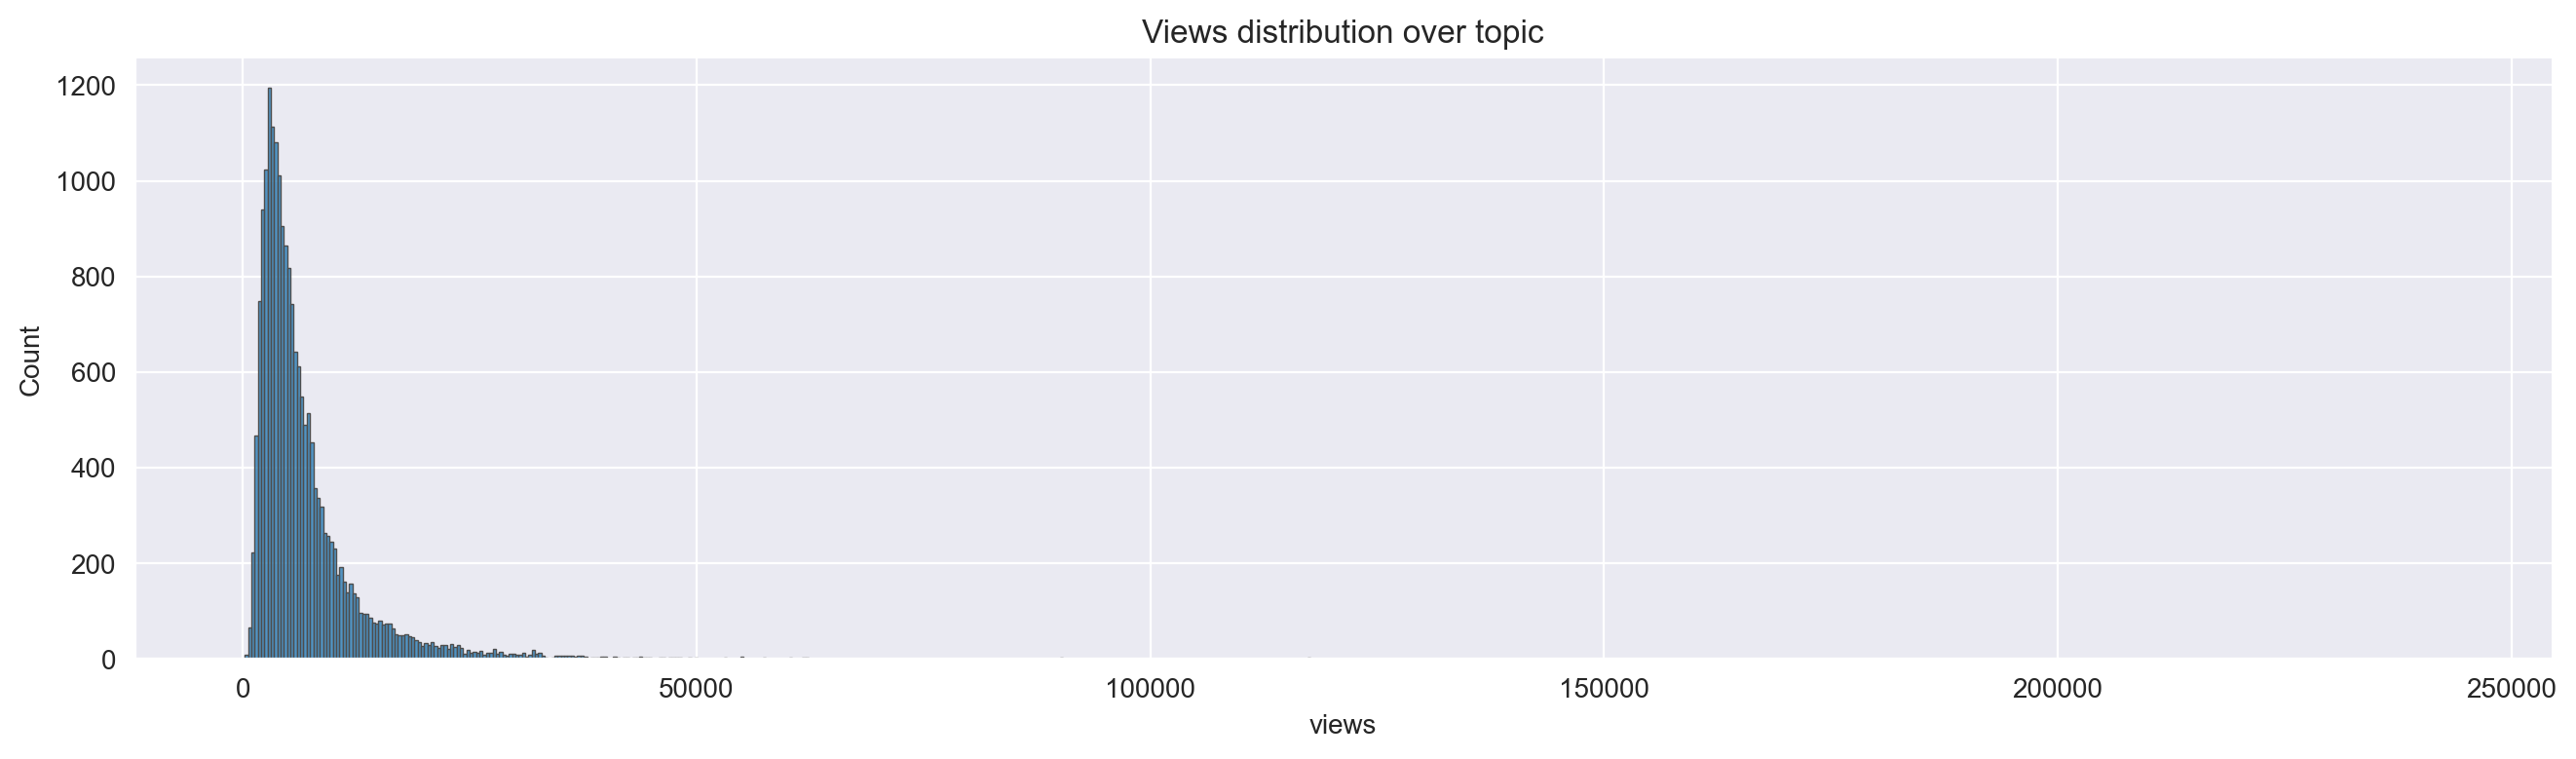

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="views",
    edgecolor=".3",
    palette=my_colors,
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

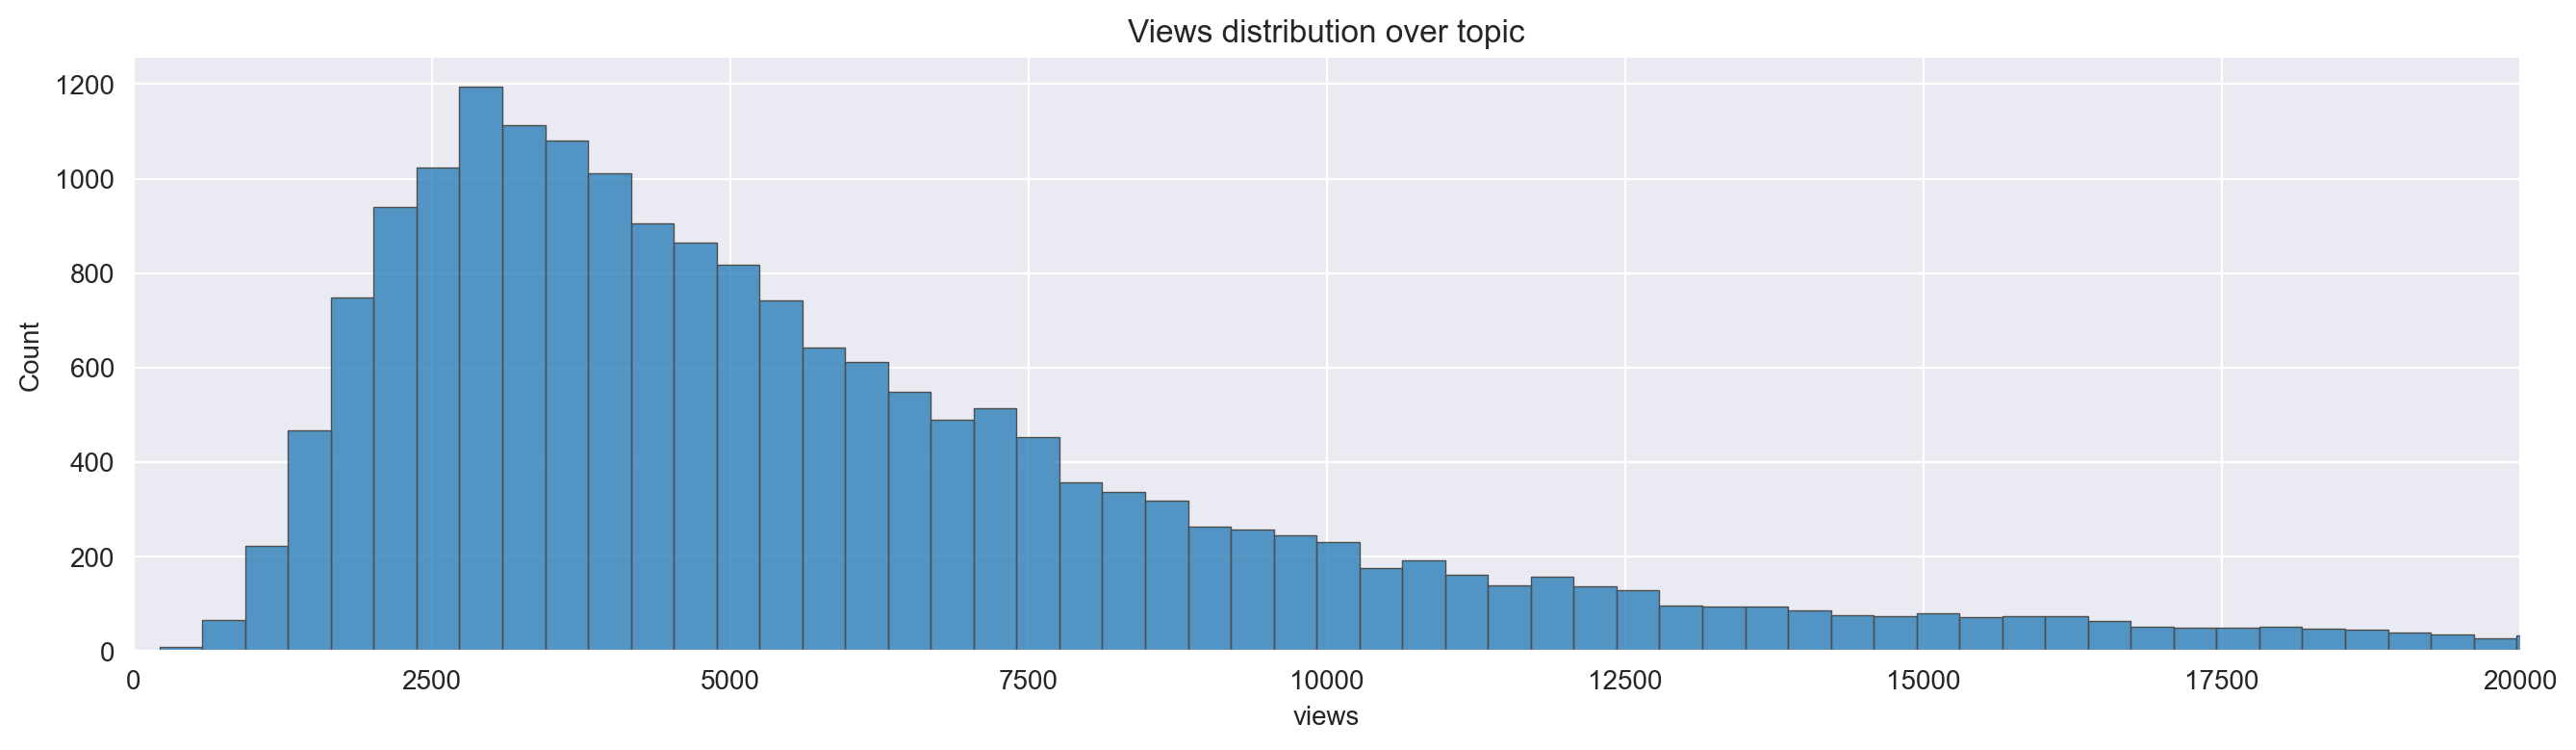

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="views",
    edgecolor=".3",
    palette=my_colors,
    linewidth=.5,
)
plt.xlim(0, 20000)
axs.set_title('Views distribution over topic');

- Есть большие выбросы и тяжелый хвост

Добавим еще один признак - логарифм количества просмотров, сдвинутого на единицу, поскольку количество просмотров может принимать значение ноль.

Теперь распределение имеет форму, близкую к нормальному распределению, хоть оно немного скошено вправо

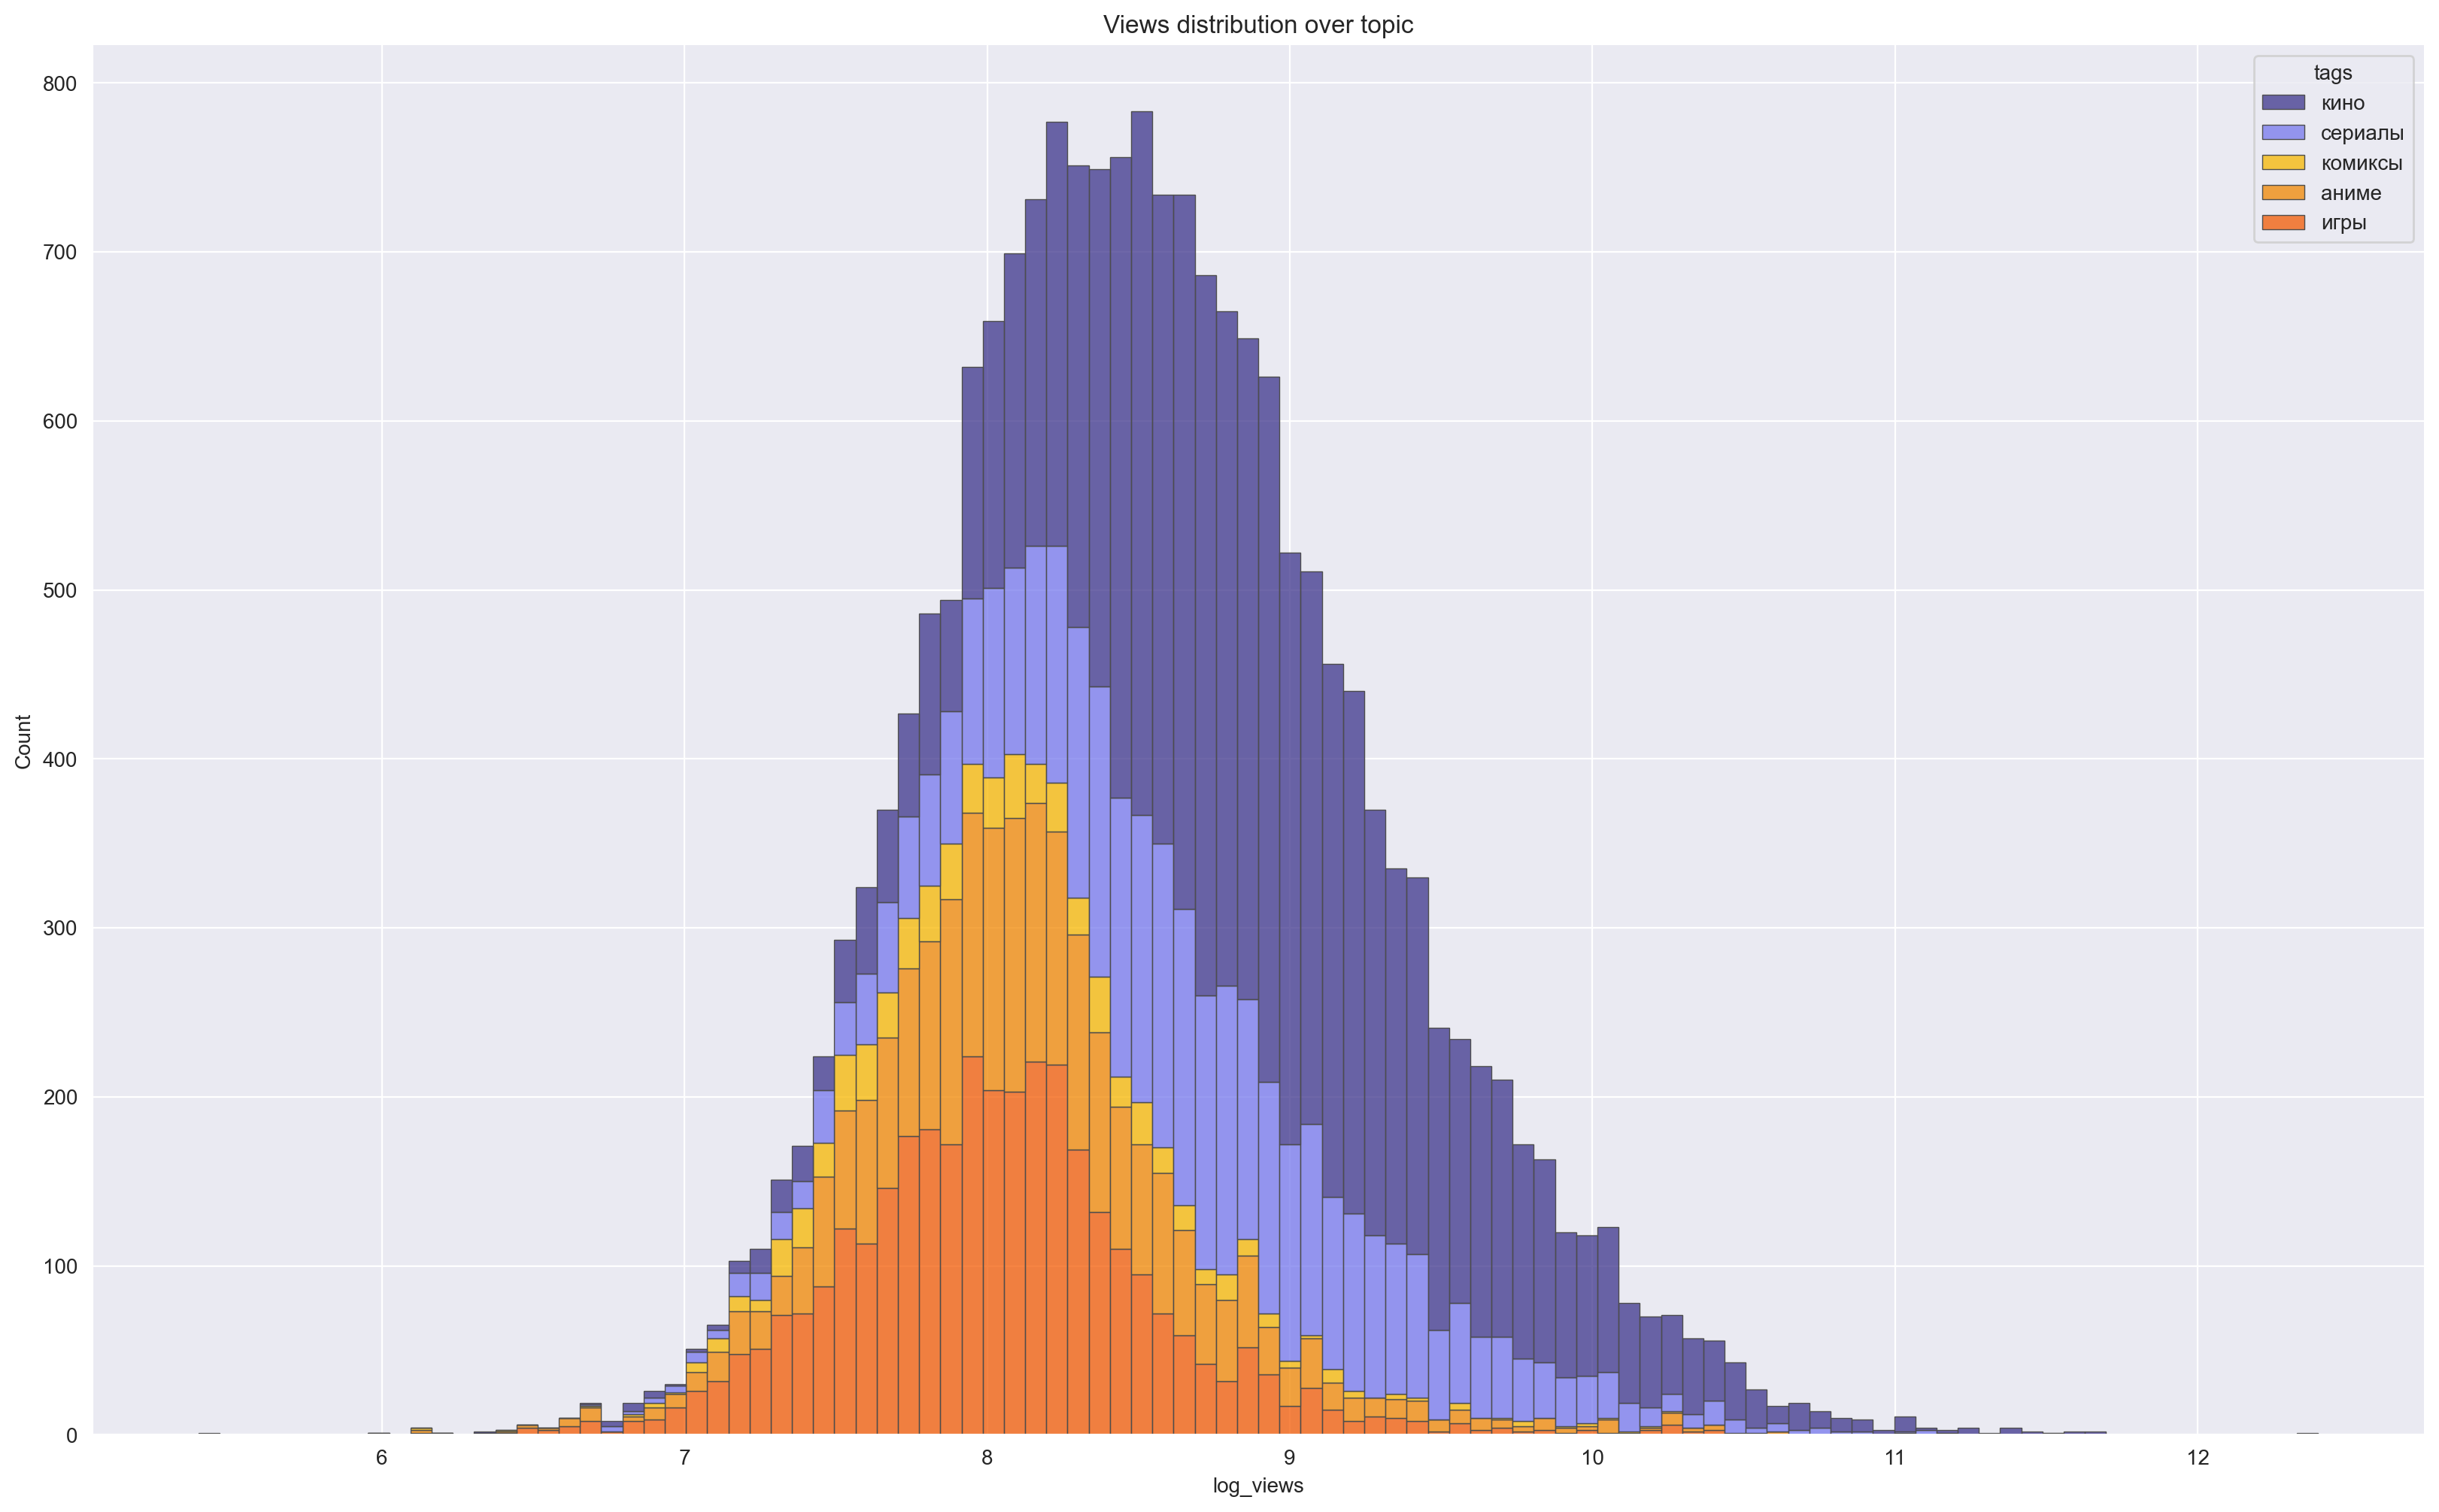

In [54]:
df['log_views'] = np.log1p(df['views'])
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="log_views",
    hue="tags",
    multiple="stack",
    edgecolor=".3",
    palette=my_colors,
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

In [28]:
df.groupby('tags').agg(min_views =('views', 'min'), 
                       max_views=('views', 'max'), 
                       avg_views=('views', 'mean'), 
                       total_views=('views', 'sum'))

min_views  max_views    avg_views  total_views
tags                                                   
аниме          397      60085  4303.988902     11246323
игры           469      32877  3609.324019     12787835
кино           219     242288  8934.999335     80629434
комиксы        454      34143  3843.843077      2498498
сериалы        776      97989  7422.066632     28626911

Новости по фильмам и сериалам набирают в среднем больше просмотров


Воспользуемся критерием Манна-Уитни, чтобы проверить, насколько распределение просмотров близко к логнормальному.

In [29]:
from scipy.stats import mannwhitneyu

# Генерируем выборку из нормального распределения с таким же мат. ожиданием и дисперсией, как у нашей переменной
x = np.random.normal(loc=df['log_views'].mean(), scale=df['log_views'].std(), size=100000)

# Проводим тест Манна-Уитни и получаем p-значимость
U1, p = mannwhitneyu(x, df['log_views'])

print('P-значимость:', p)

# Возьмем границу принятия решения 1%
if p < 0.01:
    print('Распределение количества просмотров можно считать логнормальным')
else:
    print('Распределение количества просмотров нельзя считать логнормальным')

P-значимость: 0.005213633861254832
Распределение количества просмотров можно считать логнормальным


## Clean text and eda

In [30]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation+'«»'), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\xa0—', '', text)
    text = re.sub('\xa0', ' ', text)
    return text


In [31]:
df['content_clean'] = df['content'].apply(clean_text)
df['title_clean'] = df['title'].apply(clean_text)
df['subtitle_clean'] = df['subtitle'].apply(clean_text)
df.head()

url  \
0  https://kg-portal.ru/comments/117577-rezhisser...   
1  https://kg-portal.ru/comments/117576-luchshij-...   
2  https://kg-portal.ru/comments/117575-anonsirov...   
3  https://kg-portal.ru/comments/117573-ejlin-tre...   
4  https://kg-portal.ru/comments/117574-mjatezhna...   

                                               title  \
0  Режиссёр «Реальной любви» и «Дневника Бриджет ...   
1  Лучший день в моей жизни: режиссёр нового «Чуж...   
2  Анонсирована приставка Analogue 3D — современн...   
3  Роковая Энн Хэтэуэй соблазняет невинную Томаси...   
4  «Мятежная луна» Зака Снайдера: новые промо с к...   

                                    subtitle  \
0       Он начинает осознавать глубину вины.   
1  Постановщик оригинала остался в восторге.   
2       Только картриджи и никакой эмуляции!   
3             Мужчин просят не беспокоиться.   
4          Боевая София Бутелла и остальные.   

                                             content  \
0  Ричард Кёртис — режиссёр лучших образчиков жан...   
1  Феде Альварес признался, что уже собрал режисс...   
2                                                      
3  Студия NEON представила первый трейлер фильма ...   
4  Фантастический эпик Зака Снайдера «Мятежная лу...   

                   datetime  tags  views        date  year    month  \
0 2023-10-18 09:22:00+00:00  кино    839  2023-10-18  2023  October   
1 2023-10-18 08:40:00+00:00  кино   1552  2023-10-18  2023  October   
2 2023-10-17 23:54:00+00:00  игры    848  2023-10-17  2023  October   
3 2023-10-17 21:17:00+00:00  кино   3371  2023-10-17  2023  October   
4 2023-10-17 20:55:00+00:00  кино   1791  2023-10-17  2023  October   

     weekday  log_views                                      content_clean  \
0  Wednesday   6.733402  ричард кёртис режиссёр лучших образчиков жанра...   
1  Wednesday   7.347944  феде альварес признался что уже собрал режиссё...   
2    Tuesday   6.744059                                                      
3    Tuesday   8.123261  студия neon представила первый трейлер фильма ...   
4    Tuesday   7.491088  фантастический эпик зака снайдера мятежная лун...   

                                         title_clean  \
0  режиссёр реальной любви и дневника бриджет джо...   
1  лучший день в моей жизни режиссёр нового чужог...   
2  анонсирована приставка analogue  — современный...   
3  роковая энн хэтэуэй соблазняет невинную томаси...   
4  мятежная луна зака снайдера новые промо с ключ...   

                             subtitle_clean  
0       он начинает осознавать глубину вины  
1  постановщик оригинала остался в восторге  
2       только картриджи и никакой эмуляции  
3             мужчин просят не беспокоиться  
4          боевая софия бутелла и остальные

In [32]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за', 'с',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'кг', 'главные', 'играет', 'и','y', 'c'])

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text


In [33]:
df['content_clean'] = df['content_clean'].apply(remove_stopwords)
df['title_clean'] = df['title_clean'].apply(remove_stopwords)
df['subtitle_clean'] = df['subtitle_clean'].apply(remove_stopwords)
df.head()

url  \
0  https://kg-portal.ru/comments/117577-rezhisser...   
1  https://kg-portal.ru/comments/117576-luchshij-...   
2  https://kg-portal.ru/comments/117575-anonsirov...   
3  https://kg-portal.ru/comments/117573-ejlin-tre...   
4  https://kg-portal.ru/comments/117574-mjatezhna...   

                                               title  \
0  Режиссёр «Реальной любви» и «Дневника Бриджет ...   
1  Лучший день в моей жизни: режиссёр нового «Чуж...   
2  Анонсирована приставка Analogue 3D — современн...   
3  Роковая Энн Хэтэуэй соблазняет невинную Томаси...   
4  «Мятежная луна» Зака Снайдера: новые промо с к...   

                                    subtitle  \
0       Он начинает осознавать глубину вины.   
1  Постановщик оригинала остался в восторге.   
2       Только картриджи и никакой эмуляции!   
3             Мужчин просят не беспокоиться.   
4          Боевая София Бутелла и остальные.   

                                             content  \
0  Ричард Кёртис — режиссёр лучших образчиков жан...   
1  Феде Альварес признался, что уже собрал режисс...   
2                                                      
3  Студия NEON представила первый трейлер фильма ...   
4  Фантастический эпик Зака Снайдера «Мятежная лу...   

                   datetime  tags  views        date  year    month  \
0 2023-10-18 09:22:00+00:00  кино    839  2023-10-18  2023  October   
1 2023-10-18 08:40:00+00:00  кино   1552  2023-10-18  2023  October   
2 2023-10-17 23:54:00+00:00  игры    848  2023-10-17  2023  October   
3 2023-10-17 21:17:00+00:00  кино   3371  2023-10-17  2023  October   
4 2023-10-17 20:55:00+00:00  кино   1791  2023-10-17  2023  October   

     weekday  log_views                                      content_clean  \
0  Wednesday   6.733402  ричард кёртис режиссёр лучших образчиков жанра...   
1  Wednesday   7.347944  феде альварес признался собрал режиссёрскую ве...   
2    Tuesday   6.744059                                                      
3    Tuesday   8.123261  студия neon представила первый трейлер фильма ...   
4    Tuesday   7.491088  фантастический эпик зака снайдера мятежная лун...   

                                         title_clean  \
0  режиссёр реальной любви дневника бриджет джонс...   
1  лучший день моей жизни режиссёр нового чужого ...   
2  анонсирована приставка analogue  современный к...   
3  роковая энн хэтэуэй соблазняет невинную томаси...   
4  мятежная луна зака снайдера новые промо ключев...   

                           subtitle_clean  
0        начинает осознавать глубину вины  
1  постановщик оригинала остался восторге  
2              картриджи никакой эмуляции  
3              мужчин просят беспокоиться  
4          боевая софия бутелла остальные

In [34]:
from pymystem3 import Mystem

In [35]:
lemmatizer = Mystem()
def lem_text(text):
    text = ' '.join(lemmatizer.lemmatize(text))
    return text

In [36]:
df['content_clean'] = df['content_clean'].apply(lem_text)
df['title_clean'] = df['title_clean'].apply(lem_text)
df['subtitle_clean'] = df['subtitle_clean'].apply(lem_text)
df.head()

url  \
0  https://kg-portal.ru/comments/117577-rezhisser...   
1  https://kg-portal.ru/comments/117576-luchshij-...   
2  https://kg-portal.ru/comments/117575-anonsirov...   
3  https://kg-portal.ru/comments/117573-ejlin-tre...   
4  https://kg-portal.ru/comments/117574-mjatezhna...   

                                               title  \
0  Режиссёр «Реальной любви» и «Дневника Бриджет ...   
1  Лучший день в моей жизни: режиссёр нового «Чуж...   
2  Анонсирована приставка Analogue 3D — современн...   
3  Роковая Энн Хэтэуэй соблазняет невинную Томаси...   
4  «Мятежная луна» Зака Снайдера: новые промо с к...   

                                    subtitle  \
0       Он начинает осознавать глубину вины.   
1  Постановщик оригинала остался в восторге.   
2       Только картриджи и никакой эмуляции!   
3             Мужчин просят не беспокоиться.   
4          Боевая София Бутелла и остальные.   

                                             content  \
0  Ричард Кёртис — режиссёр лучших образчиков жан...   
1  Феде Альварес признался, что уже собрал режисс...   
2                                                      
3  Студия NEON представила первый трейлер фильма ...   
4  Фантастический эпик Зака Снайдера «Мятежная лу...   

                   datetime  tags  views        date  year    month  \
0 2023-10-18 09:22:00+00:00  кино    839  2023-10-18  2023  October   
1 2023-10-18 08:40:00+00:00  кино   1552  2023-10-18  2023  October   
2 2023-10-17 23:54:00+00:00  игры    848  2023-10-17  2023  October   
3 2023-10-17 21:17:00+00:00  кино   3371  2023-10-17  2023  October   
4 2023-10-17 20:55:00+00:00  кино   1791  2023-10-17  2023  October   

     weekday  log_views                                      content_clean  \
0  Wednesday   6.733402  ричард   кертис   режиссер   хороший   образчи...   
1  Wednesday   7.347944  федя   альварес   признаваться   собирать   ре...   
2    Tuesday   6.744059                                                      
3    Tuesday   8.123261  студия   neon   представлять   первый   трейле...   
4    Tuesday   7.491088  фантастический   эпик   зак   снайдер   мятежн...   

                                         title_clean  \
0  режиссер   реальный   любовь   дневник   бридж...   
1  хороший   день   мой   жизнь   режиссер   новы...   
2  анонсировать   приставка   analogue    совреме...   
3  роковой   энн   хэтэуэй   соблазнять   невинны...   
4  мятежный   луна   зак   снайдер   новый   пром...   

                                     subtitle_clean  
0         начинать   осознавать   глубина   вина \n  
1  постановщик   оригинал   оставаться   восторг \n  
2                  картридж   никакой   эмуляция \n  
3               мужчина   просить   беспокоиться \n  
4           боевой   софия   бутелла   остальной \n

In [43]:
df = df[df.content_clean!='']


In [37]:
df['text_len'] = df['content_clean'].astype(str).apply(len)
df['text_word_count'] = df['content_clean'].apply(lambda x: len(str(x).split()))
df['title_len'] = df['title_clean'].astype(str).apply(len)
df['title_word_count'] = df['title_clean'].apply(lambda x: len(str(x).split()))
df['subtitle_len'] = df['subtitle_clean'].astype(str).apply(len)
df['subtitle_word_count'] = df['subtitle_clean'].apply(lambda x: len(str(x).split()))

df.head()

url  \
0  https://kg-portal.ru/comments/117577-rezhisser...   
1  https://kg-portal.ru/comments/117576-luchshij-...   
2  https://kg-portal.ru/comments/117575-anonsirov...   
3  https://kg-portal.ru/comments/117573-ejlin-tre...   
4  https://kg-portal.ru/comments/117574-mjatezhna...   

                                               title  \
0  Режиссёр «Реальной любви» и «Дневника Бриджет ...   
1  Лучший день в моей жизни: режиссёр нового «Чуж...   
2  Анонсирована приставка Analogue 3D — современн...   
3  Роковая Энн Хэтэуэй соблазняет невинную Томаси...   
4  «Мятежная луна» Зака Снайдера: новые промо с к...   

                                    subtitle  \
0       Он начинает осознавать глубину вины.   
1  Постановщик оригинала остался в восторге.   
2       Только картриджи и никакой эмуляции!   
3             Мужчин просят не беспокоиться.   
4          Боевая София Бутелла и остальные.   

                                             content  \
0  Ричард Кёртис — режиссёр лучших образчиков жан...   
1  Феде Альварес признался, что уже собрал режисс...   
2                                                      
3  Студия NEON представила первый трейлер фильма ...   
4  Фантастический эпик Зака Снайдера «Мятежная лу...   

                   datetime  tags  views        date  year    month  ...  \
0 2023-10-18 09:22:00+00:00  кино    839  2023-10-18  2023  October  ...   
1 2023-10-18 08:40:00+00:00  кино   1552  2023-10-18  2023  October  ...   
2 2023-10-17 23:54:00+00:00  игры    848  2023-10-17  2023  October  ...   
3 2023-10-17 21:17:00+00:00  кино   3371  2023-10-17  2023  October  ...   
4 2023-10-17 20:55:00+00:00  кино   1791  2023-10-17  2023  October  ...   

  log_views                                      content_clean  \
0  6.733402  ричард   кертис   режиссер   хороший   образчи...   
1  7.347944  федя   альварес   признаваться   собирать   ре...   
2  6.744059                                                      
3  8.123261  студия   neon   представлять   первый   трейле...   
4  7.491088  фантастический   эпик   зак   снайдер   мятежн...   

                                         title_clean  \
0  режиссер   реальный   любовь   дневник   бридж...   
1  хороший   день   мой   жизнь   режиссер   новы...   
2  анонсировать   приставка   analogue    совреме...   
3  роковой   энн   хэтэуэй   соблазнять   невинны...   
4  мятежный   луна   зак   снайдер   новый   пром...   

                                     subtitle_clean text_len  text_word_count  \
0         начинать   осознавать   глубина   вина \n      959               95   
1  постановщик   оригинал   оставаться   восторг \n     1498              147   
2                  картридж   никакой   эмуляция \n        0                0   
3               мужчина   просить   беспокоиться \n      537               52   
4           боевой   софия   бутелла   остальной \n      681               69   

   title_len  title_word_count  subtitle_len  subtitle_word_count  
0        111                12            40                    4  
1        109                12            47                    4  
2         71                 6            31                    3  
3         98                10            34                    3  
4         72                 8            38                    4  

[5 rows x 21 columns]

In [45]:
df[['text_len', 'text_word_count', 'title_len','title_word_count', 'subtitle_len', 'subtitle_word_count']].describe()

text_len  text_word_count     title_len  title_word_count  \
count  19106.000000     19106.000000  19106.000000      19106.000000   
mean    1241.708364       131.485868     81.617450          8.631372   
std     1286.753016       137.109512     23.386337          2.451591   
min        9.000000         1.000000      5.000000          1.000000   
25%      791.000000        82.000000     67.000000          7.000000   
50%     1044.000000       110.000000     82.000000          9.000000   
75%     1407.000000       150.000000     97.000000         10.000000   
max    58431.000000      6165.000000    205.000000         21.000000   

       subtitle_len  subtitle_word_count  
count  19106.000000         19106.000000  
mean      54.600597             5.502094  
std       85.293762             8.175779  
min        0.000000             0.000000  
25%       26.000000             3.000000  
50%       38.000000             4.000000  
75%       54.000000             5.000000  
max     2480.000000           266.000000

- Средняя длина текста 1044 символа, количество слов - 110
- Средняя длина названия 82, количество слов - 9
- Средняя длина подзаголовка 38, количество слов - 4

**Наиболее популярные слова в тексте**

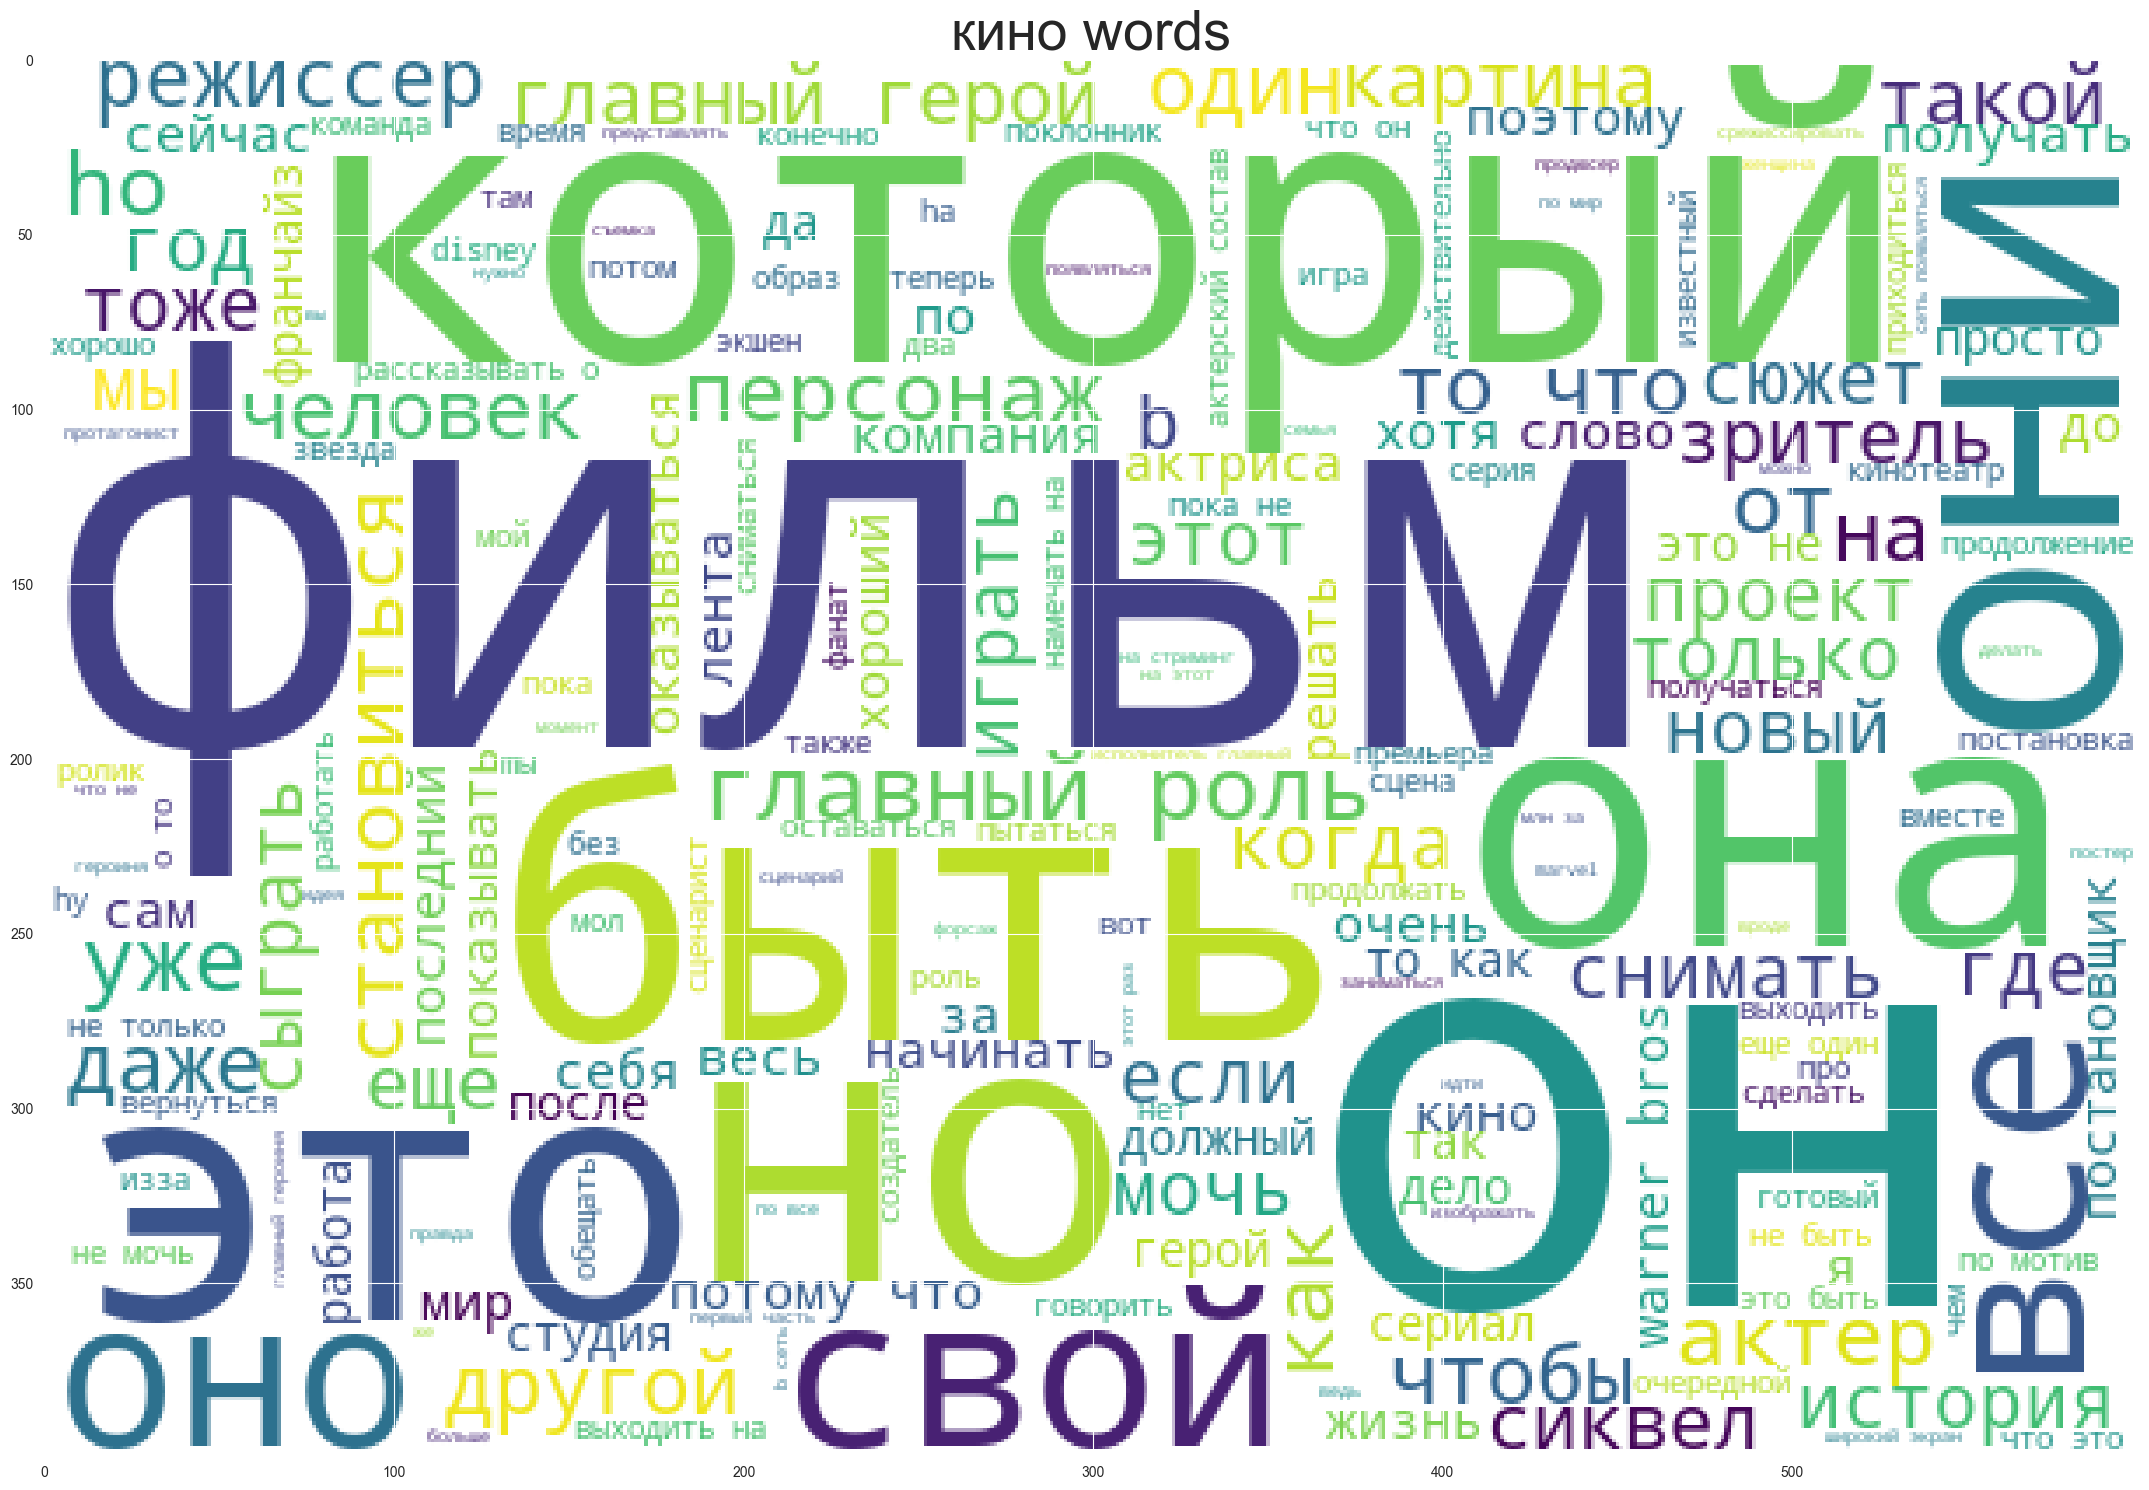

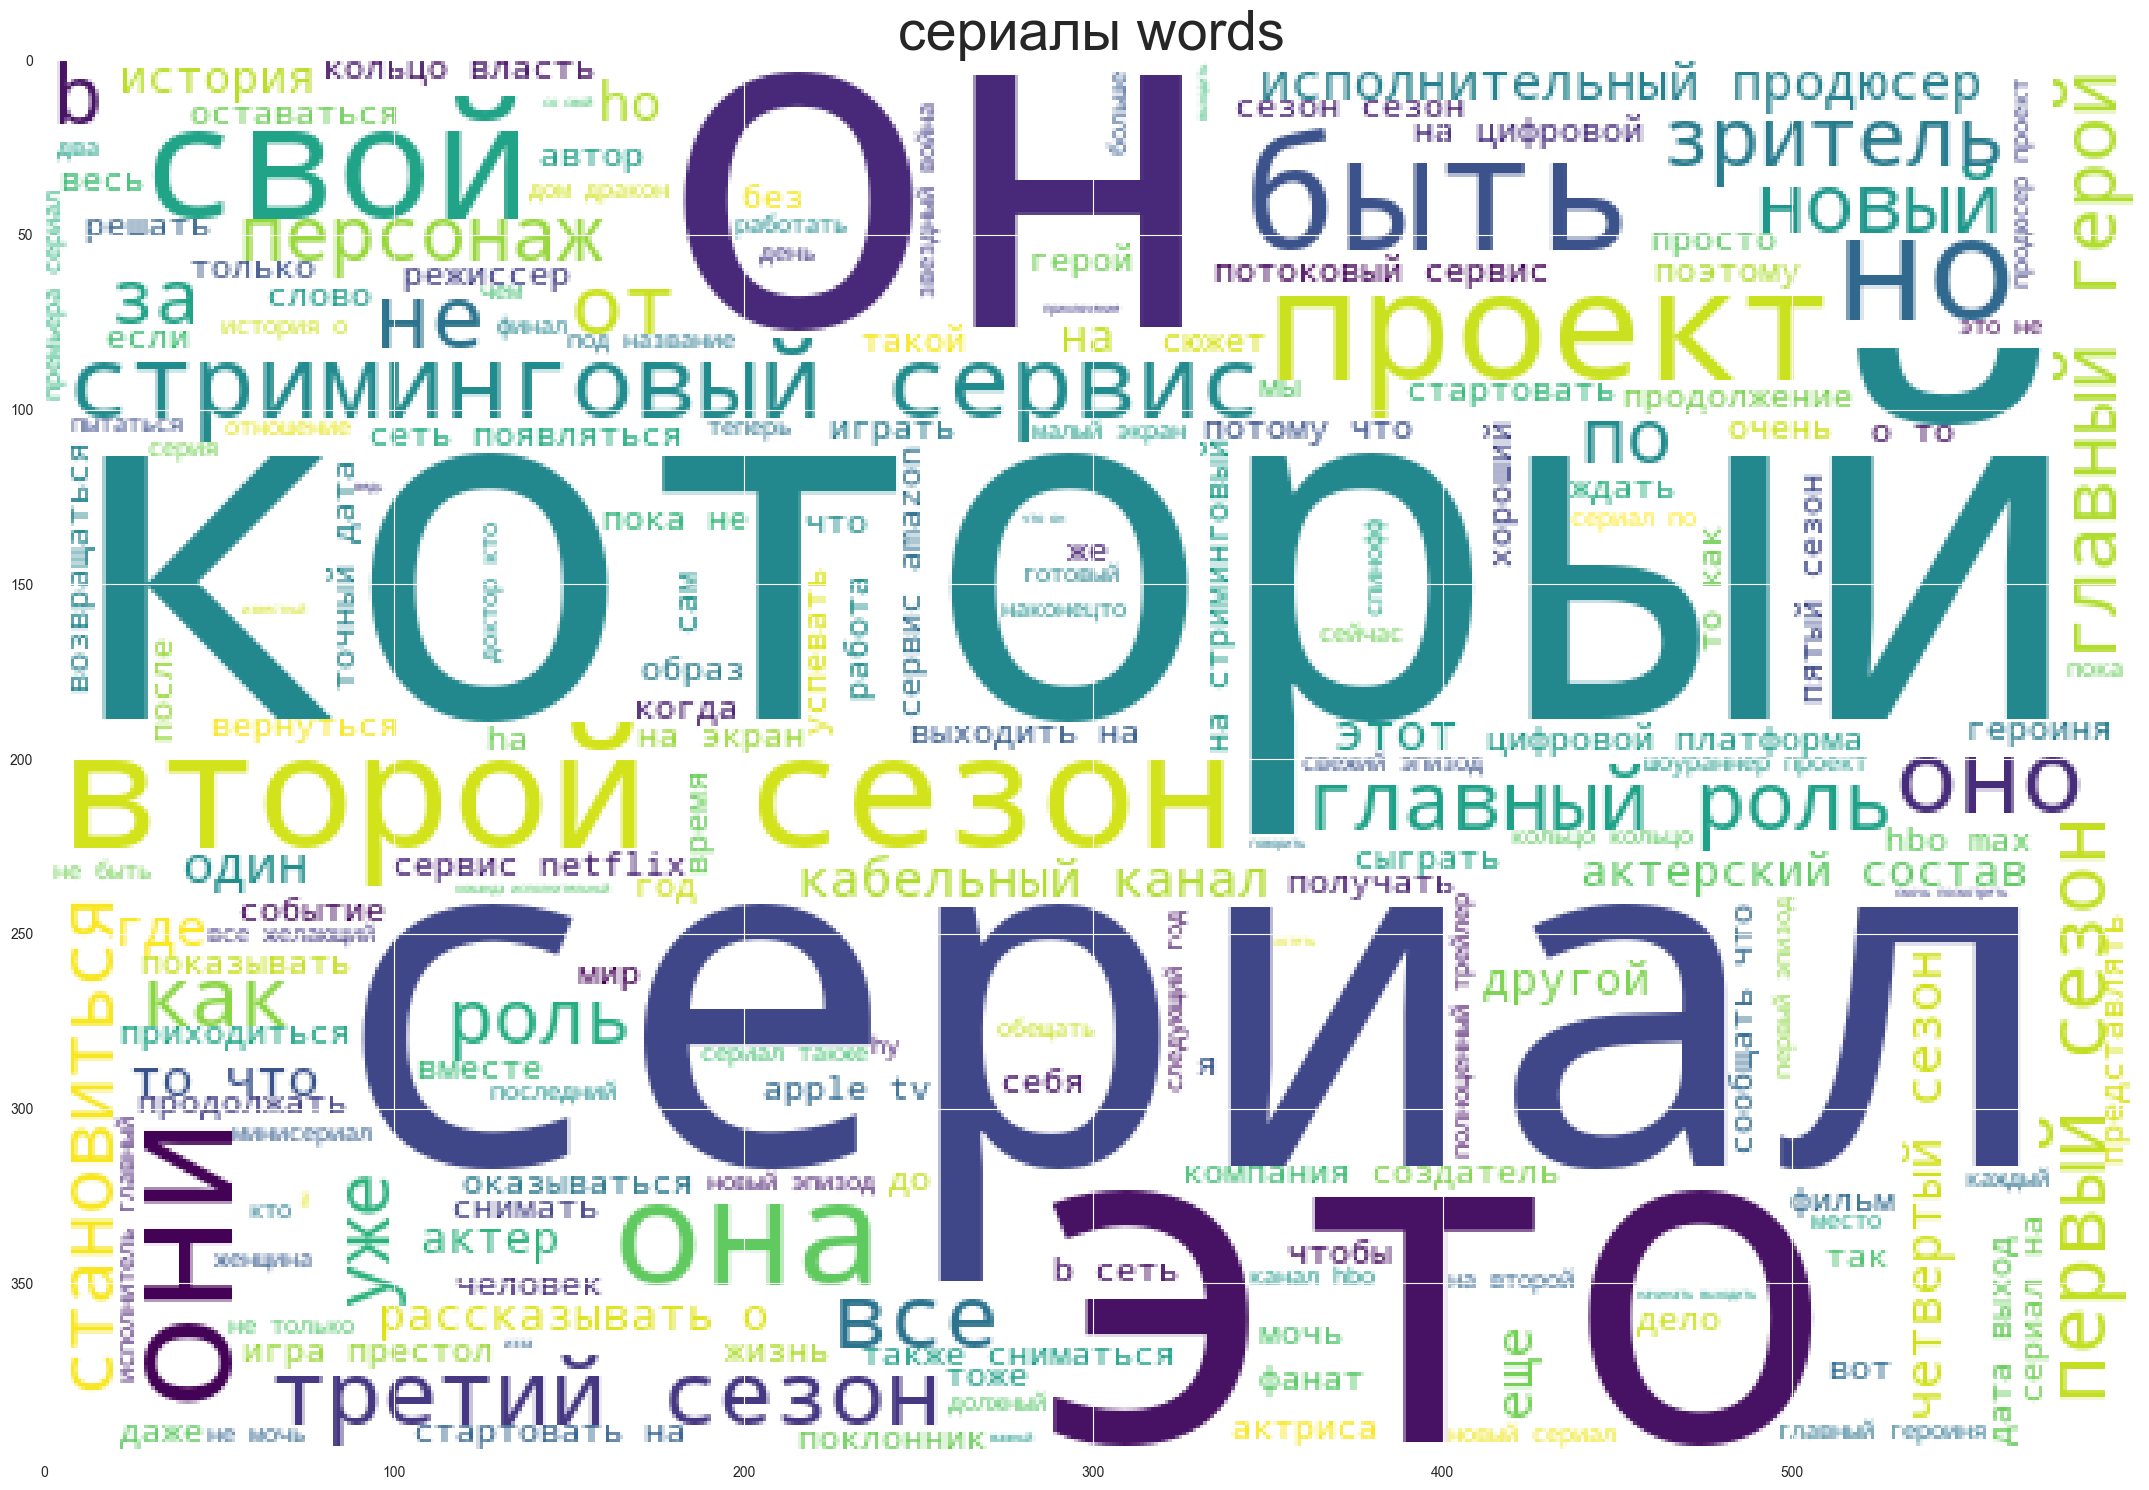

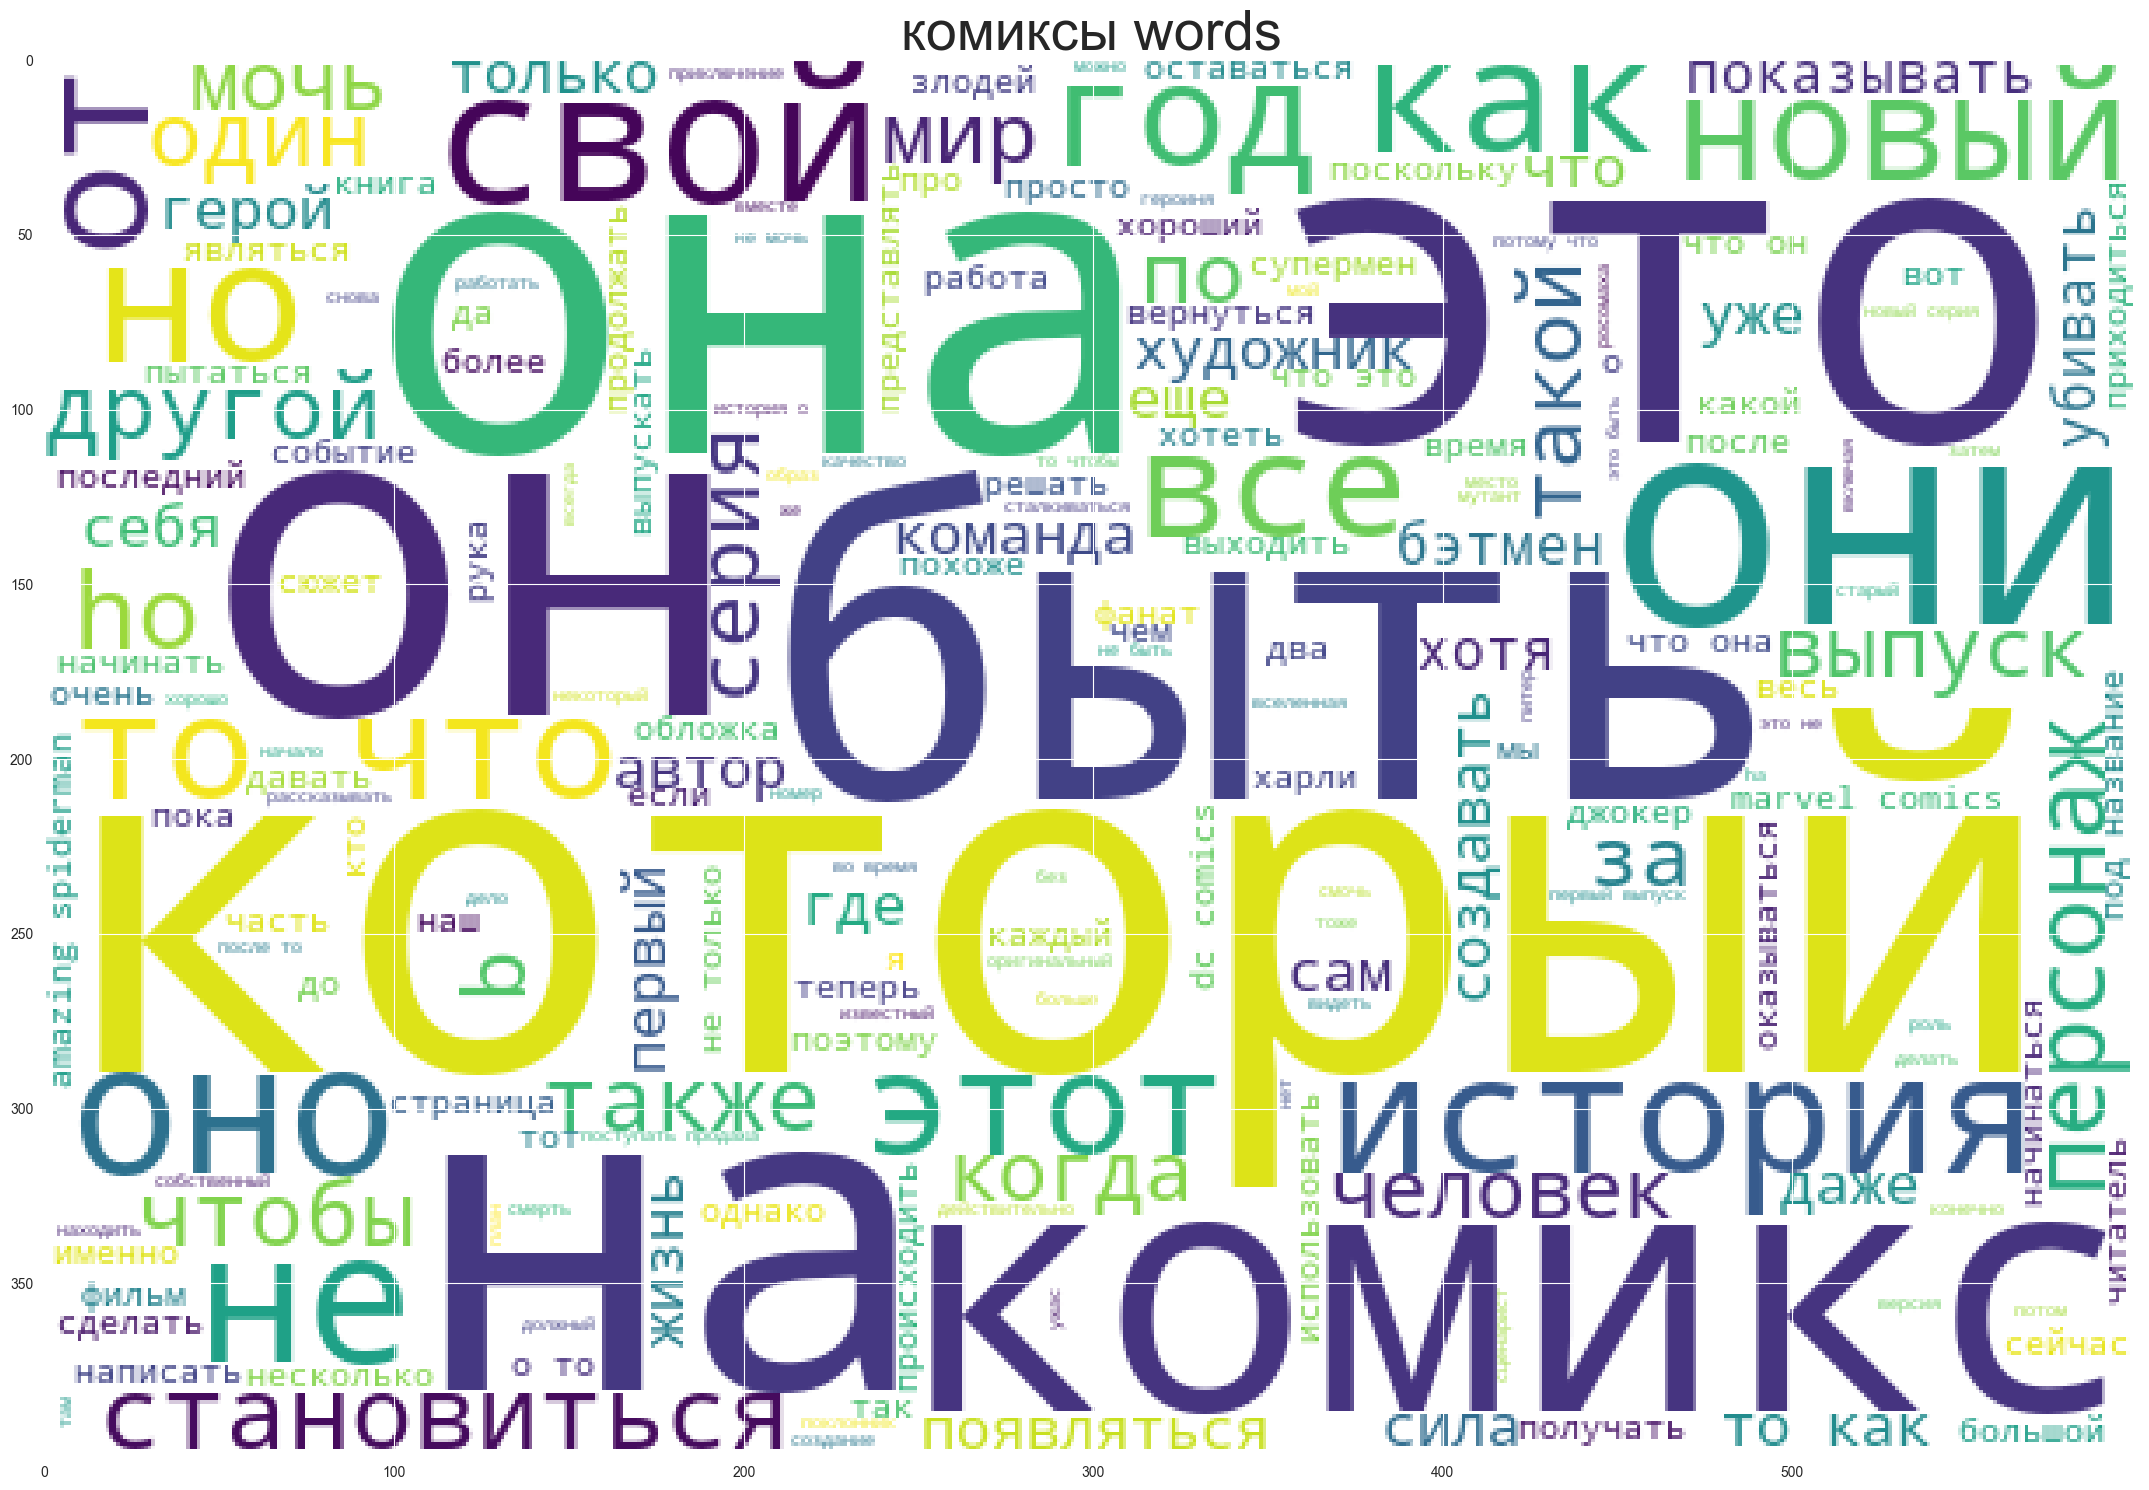

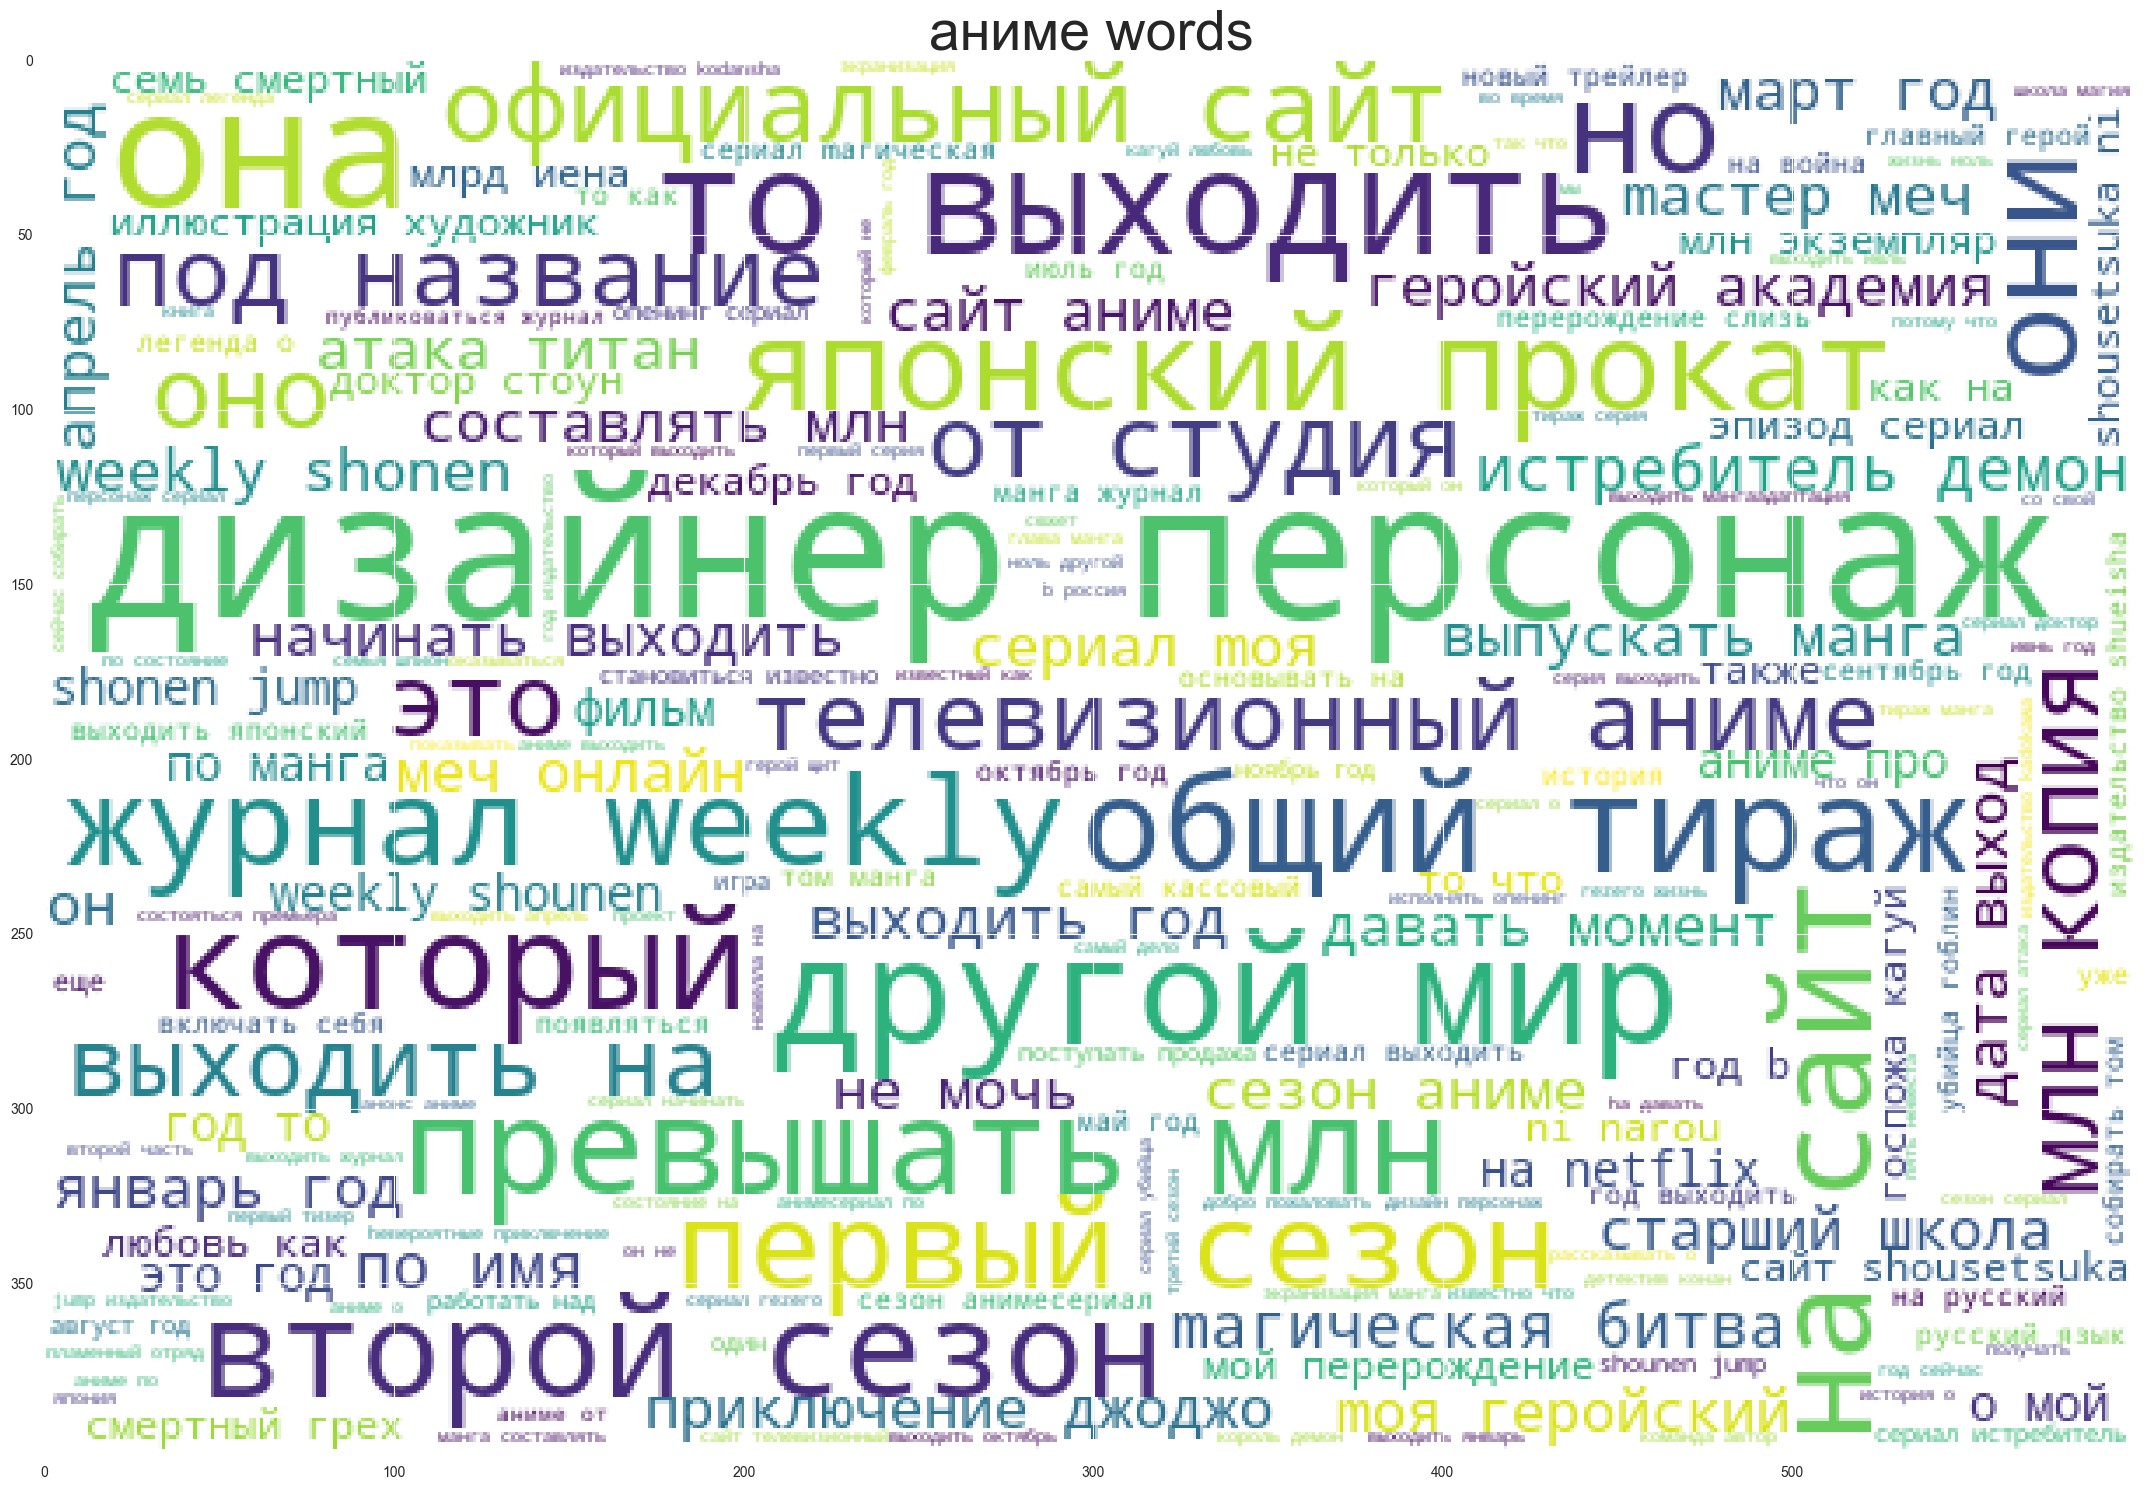

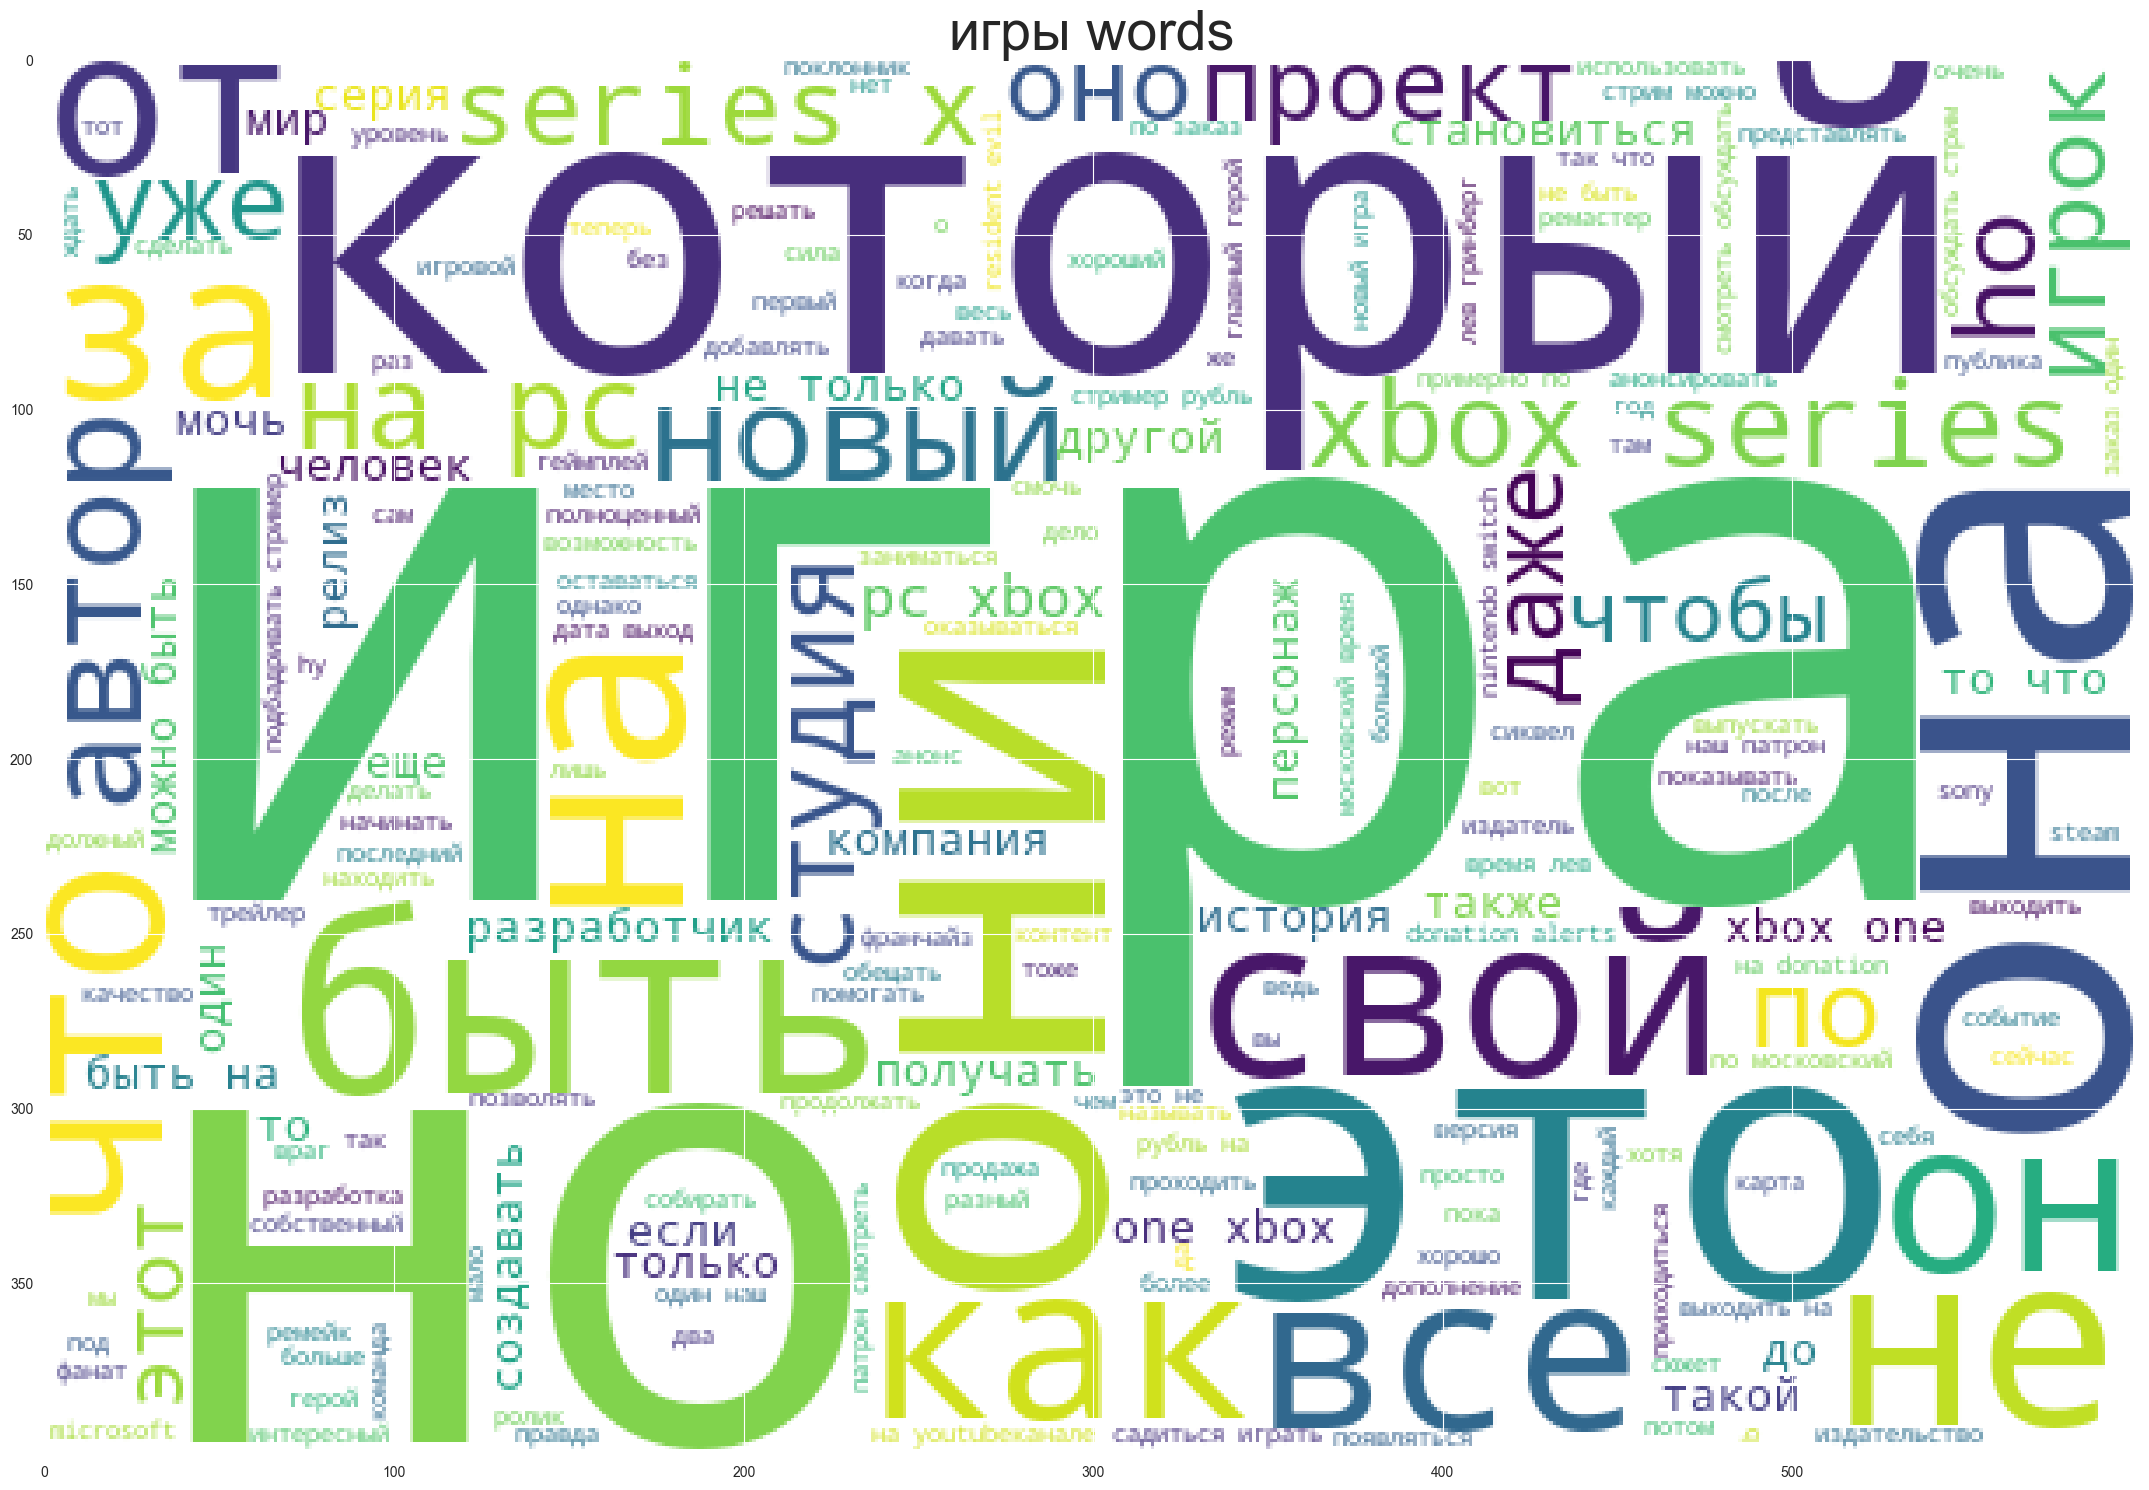

In [46]:
for topic in df.tags.unique():
    
    
    f, ax = plt.subplots(1, 1, figsize=[30, 15])
    wordcloud1 = WordCloud(background_color='white',
                            width=600,
                            height=400).generate(" ".join(df[df.tags == topic].content_clean))
    ax.imshow(wordcloud1)
    ax.set_title(f'{topic} words',fontsize=40)

    f.tight_layout()

**Наиболее популярные слова в заголовке**

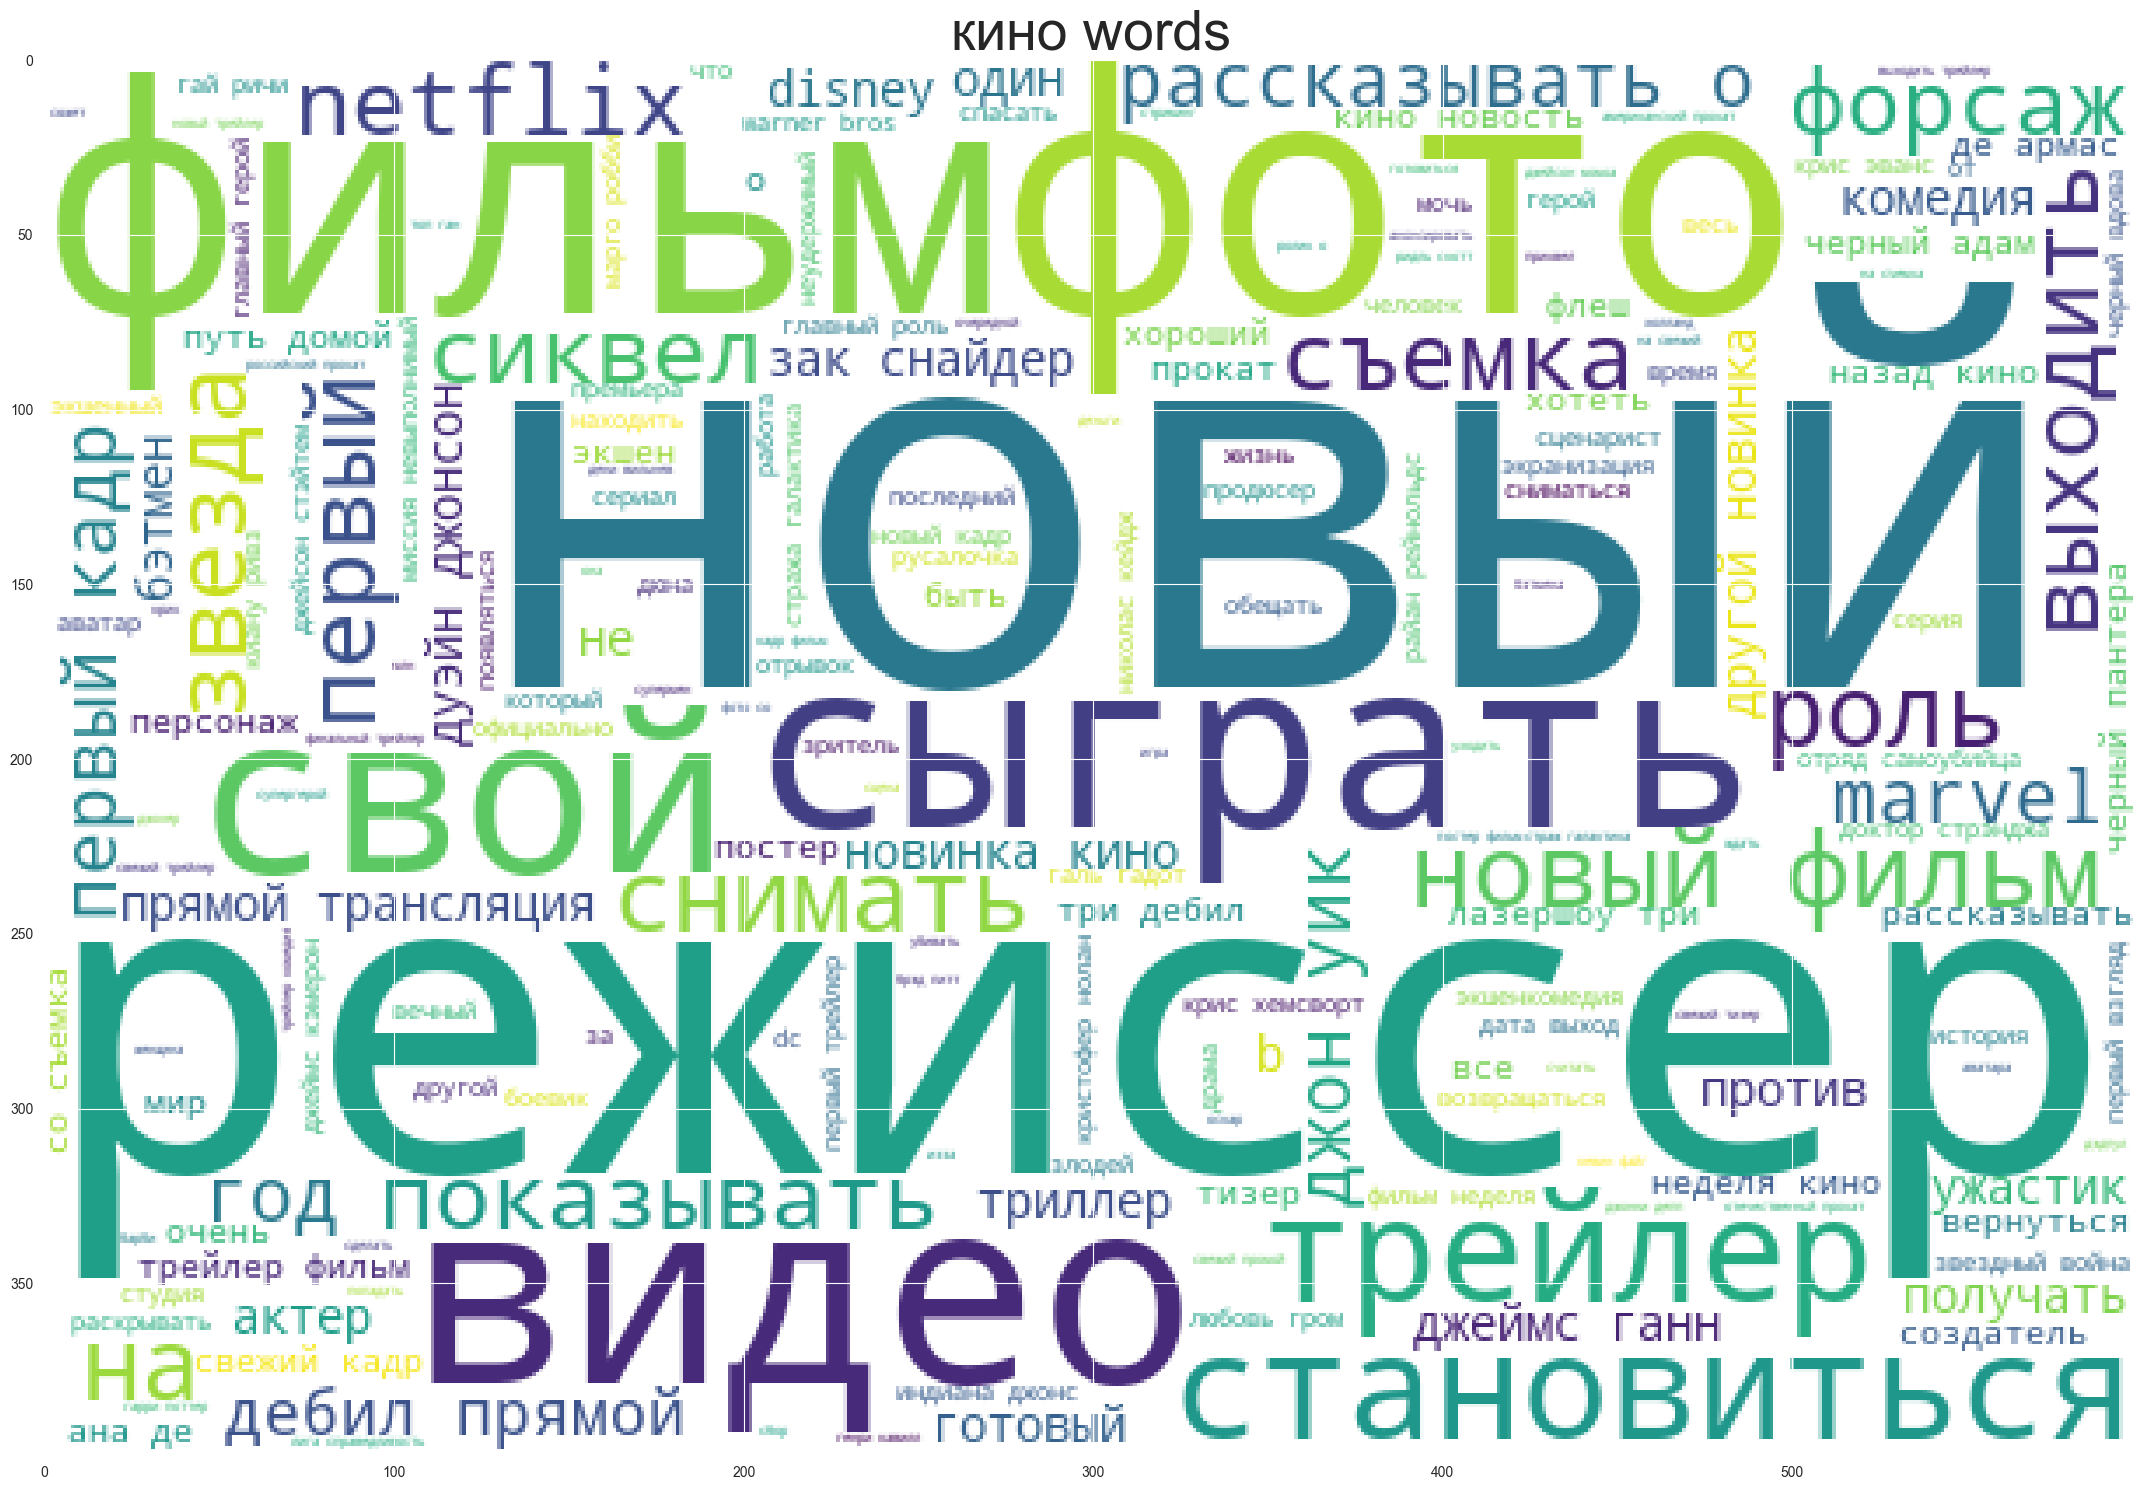

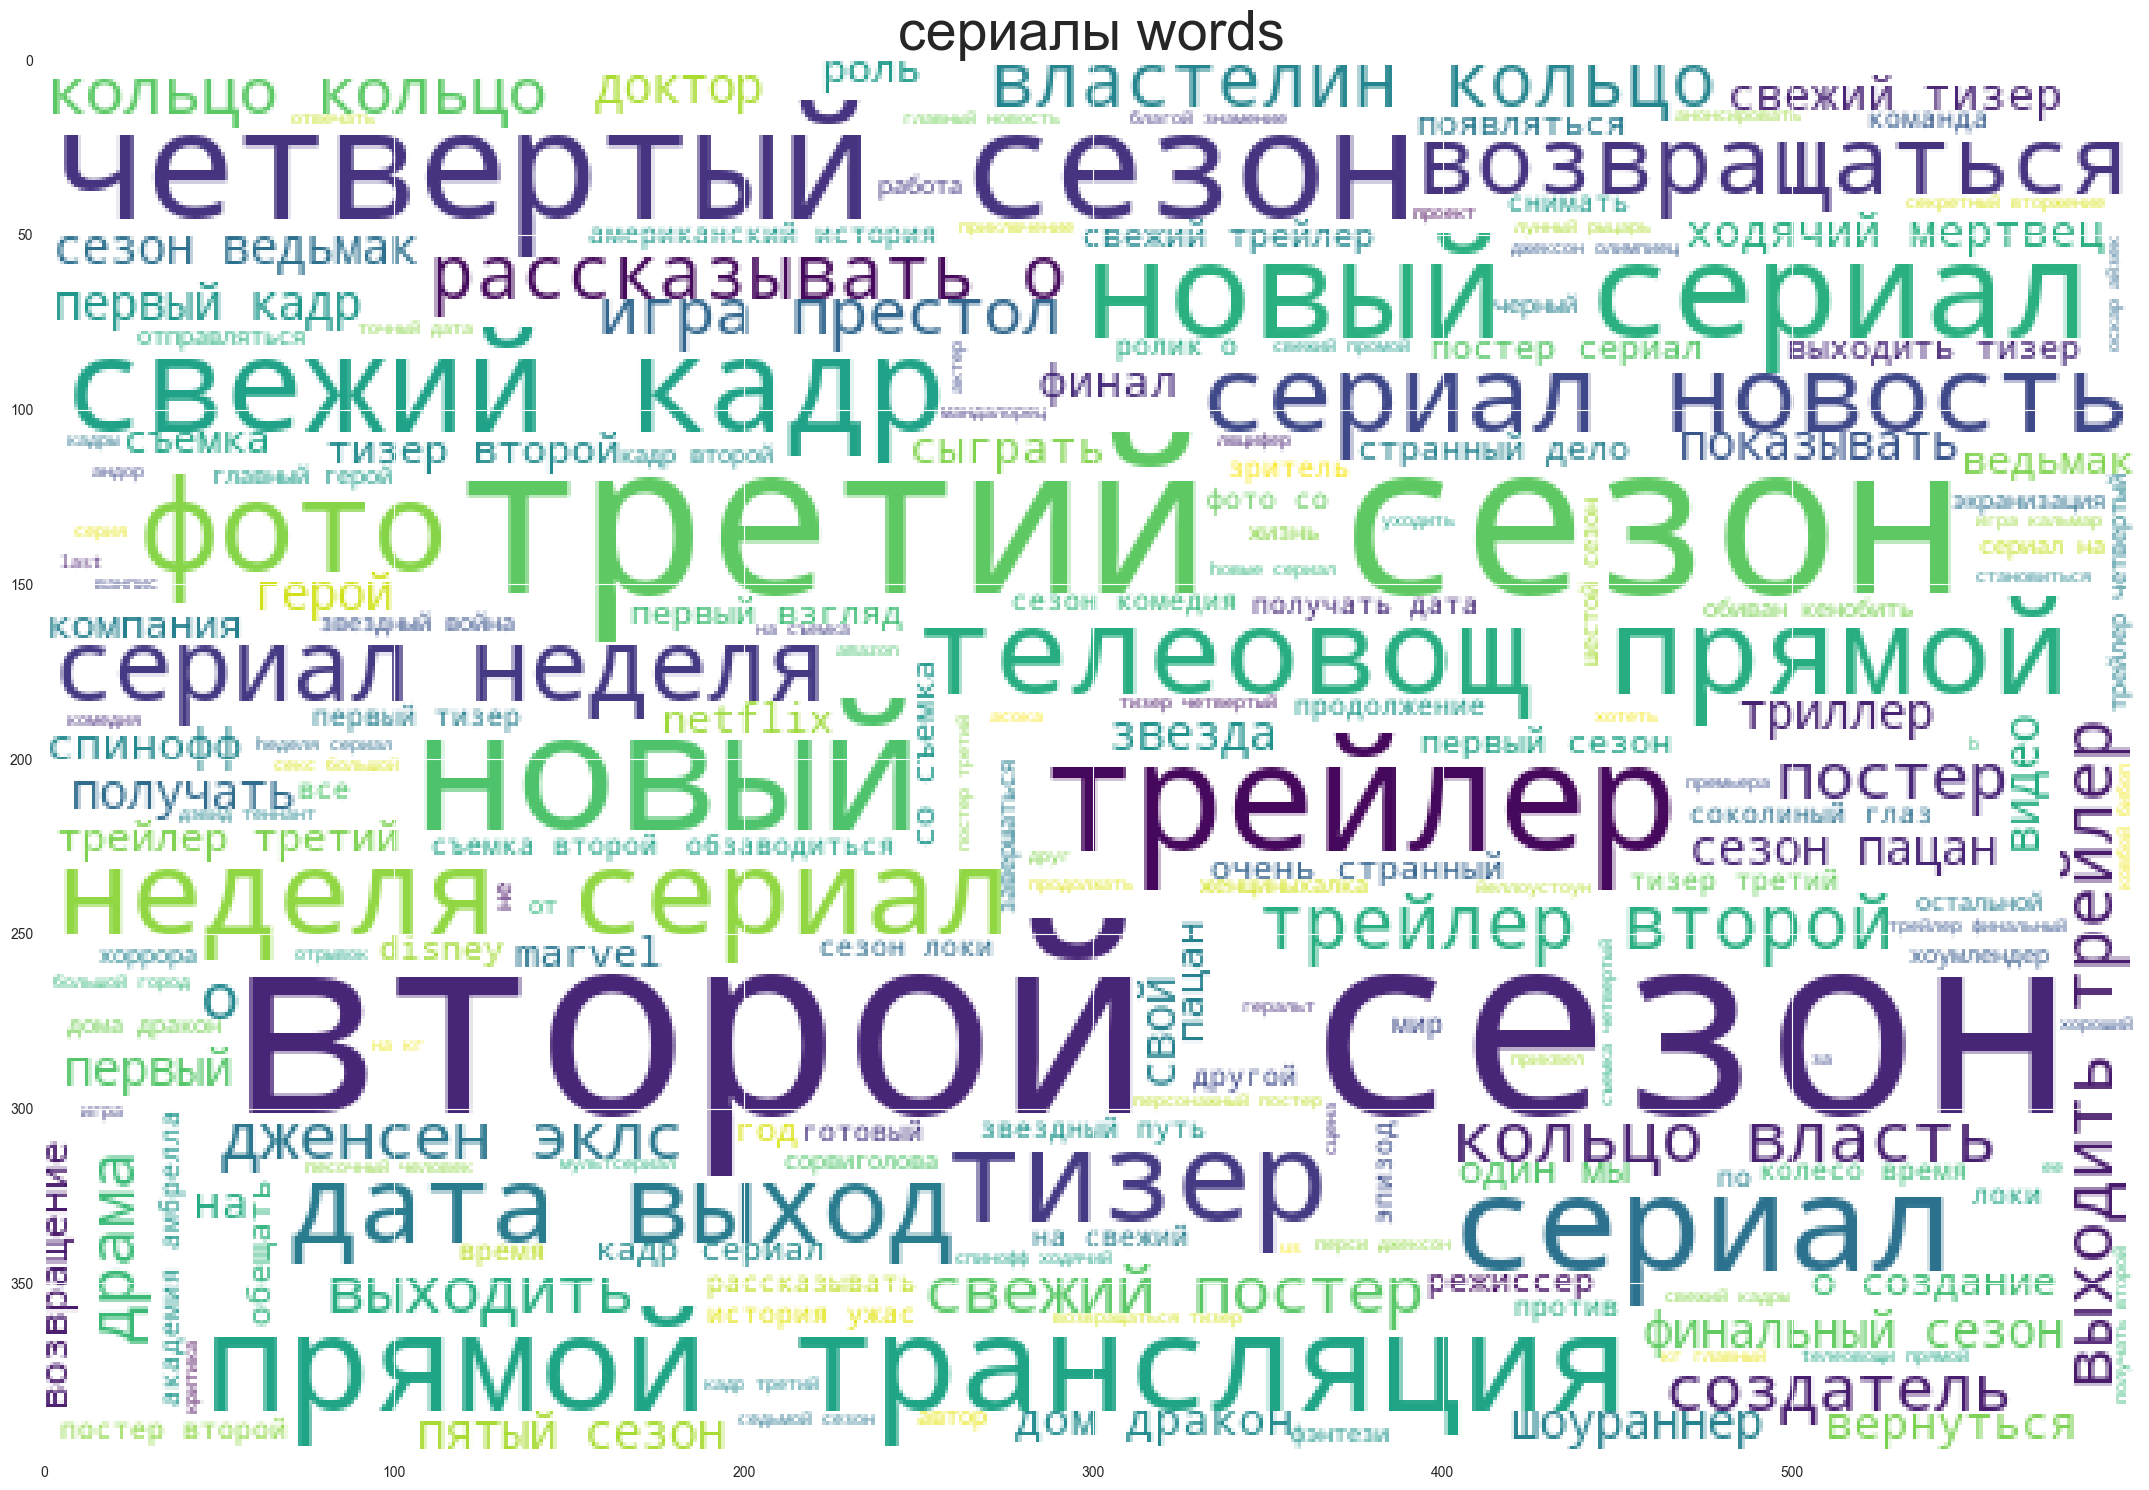

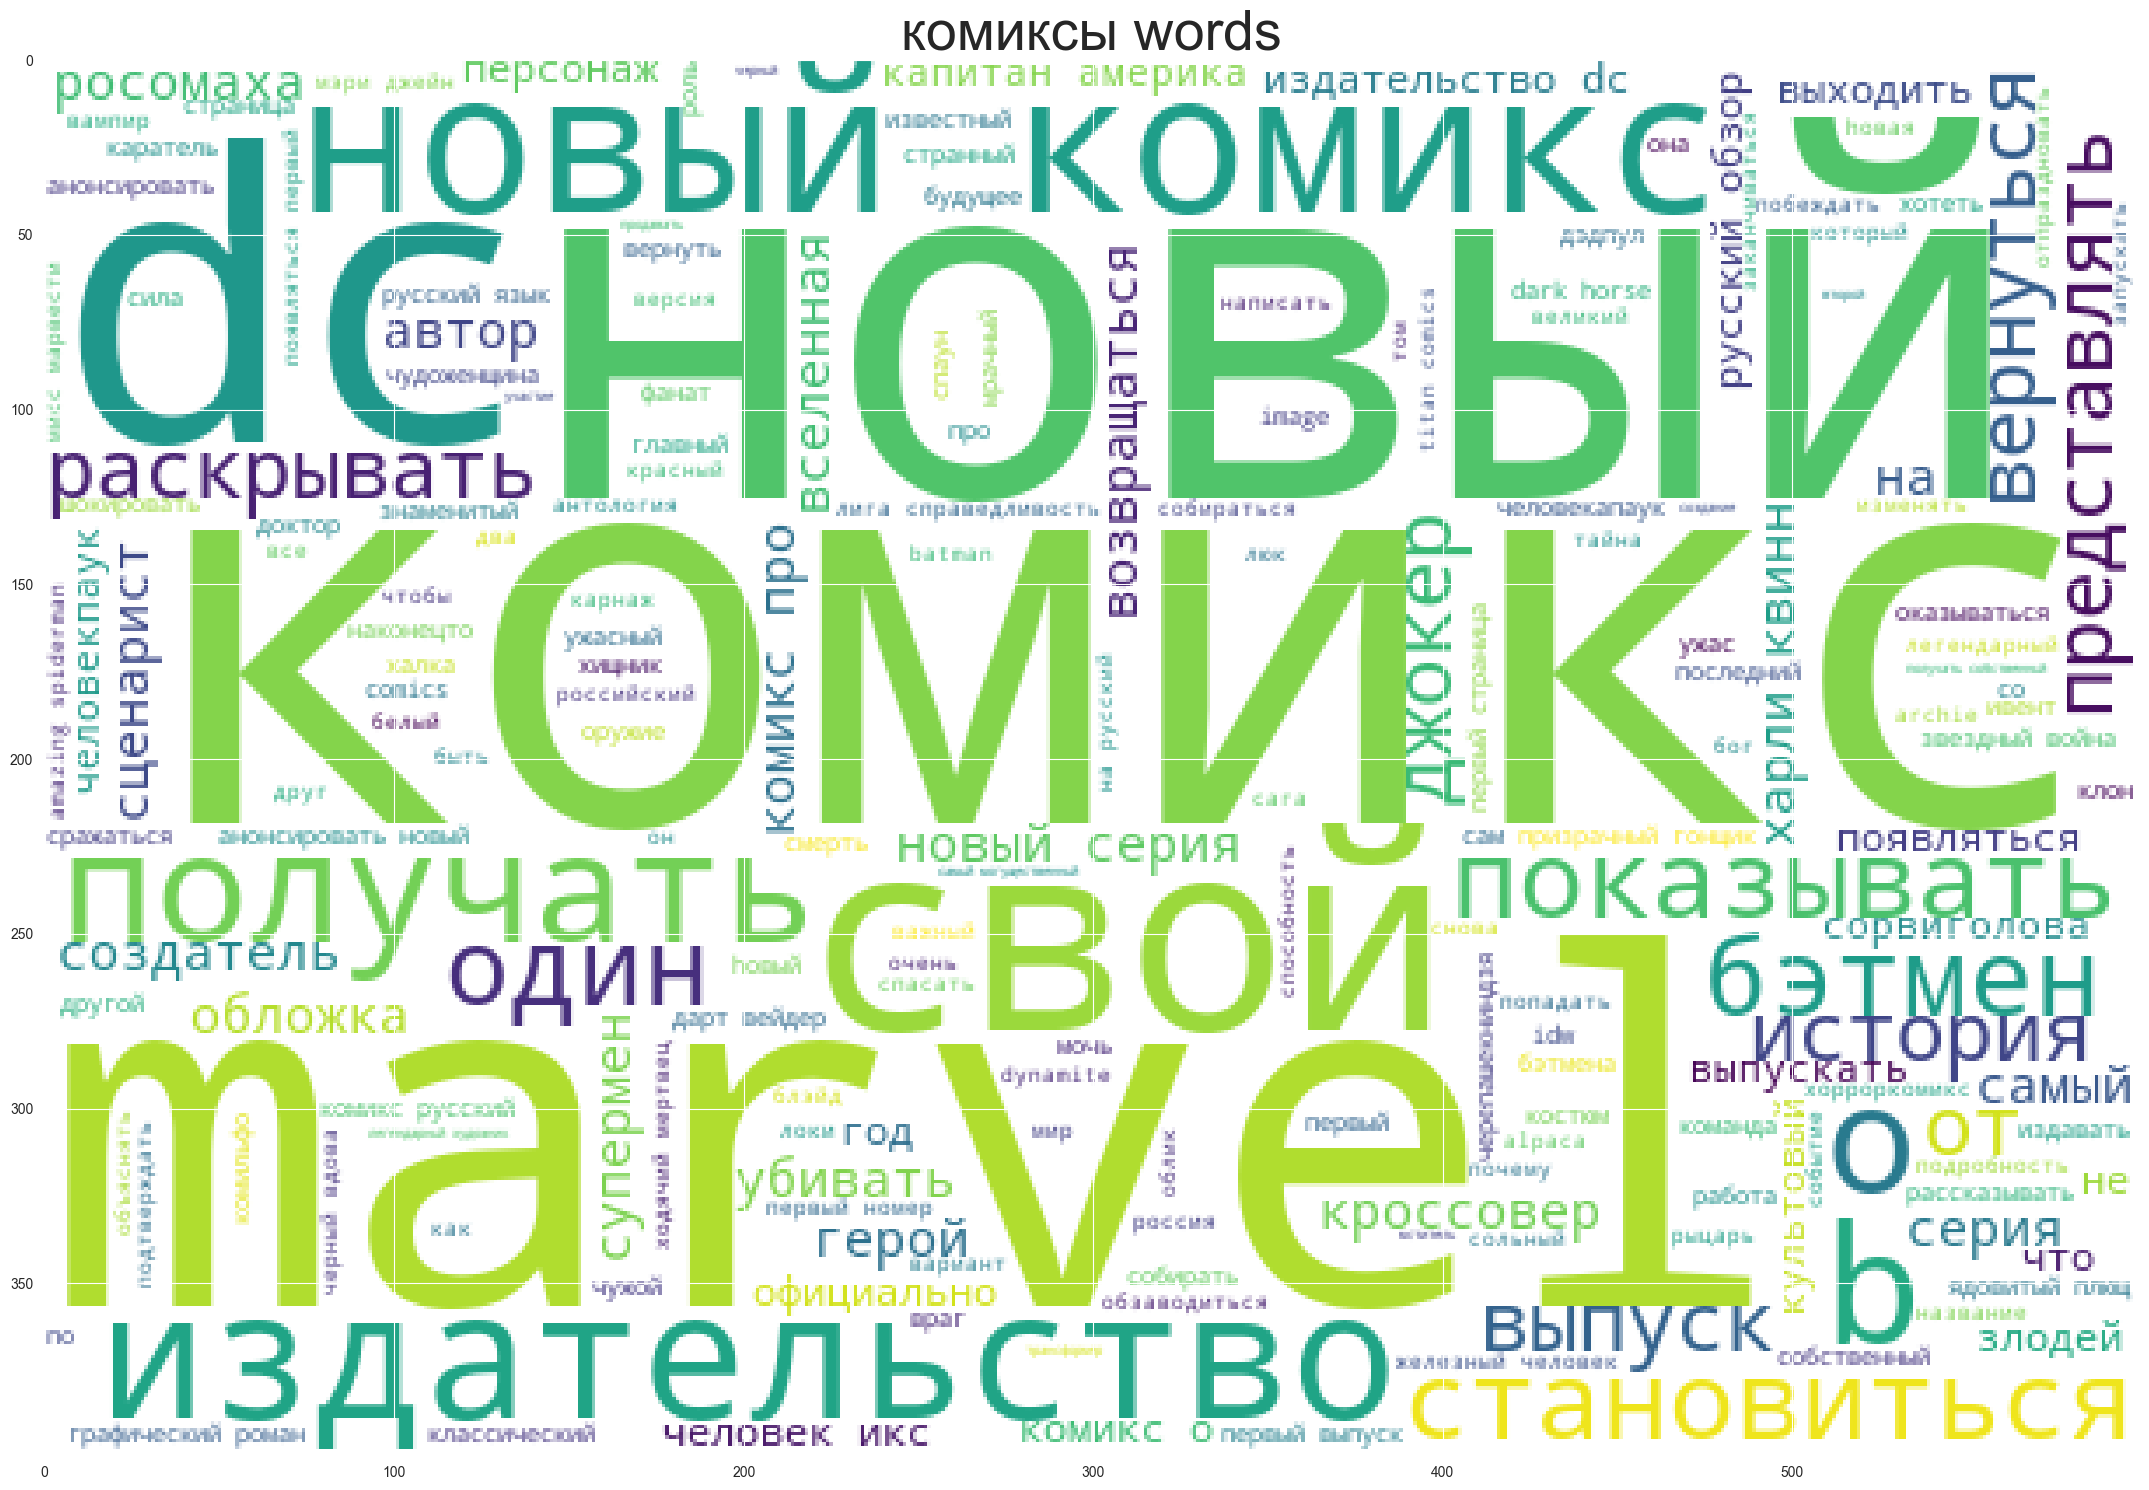

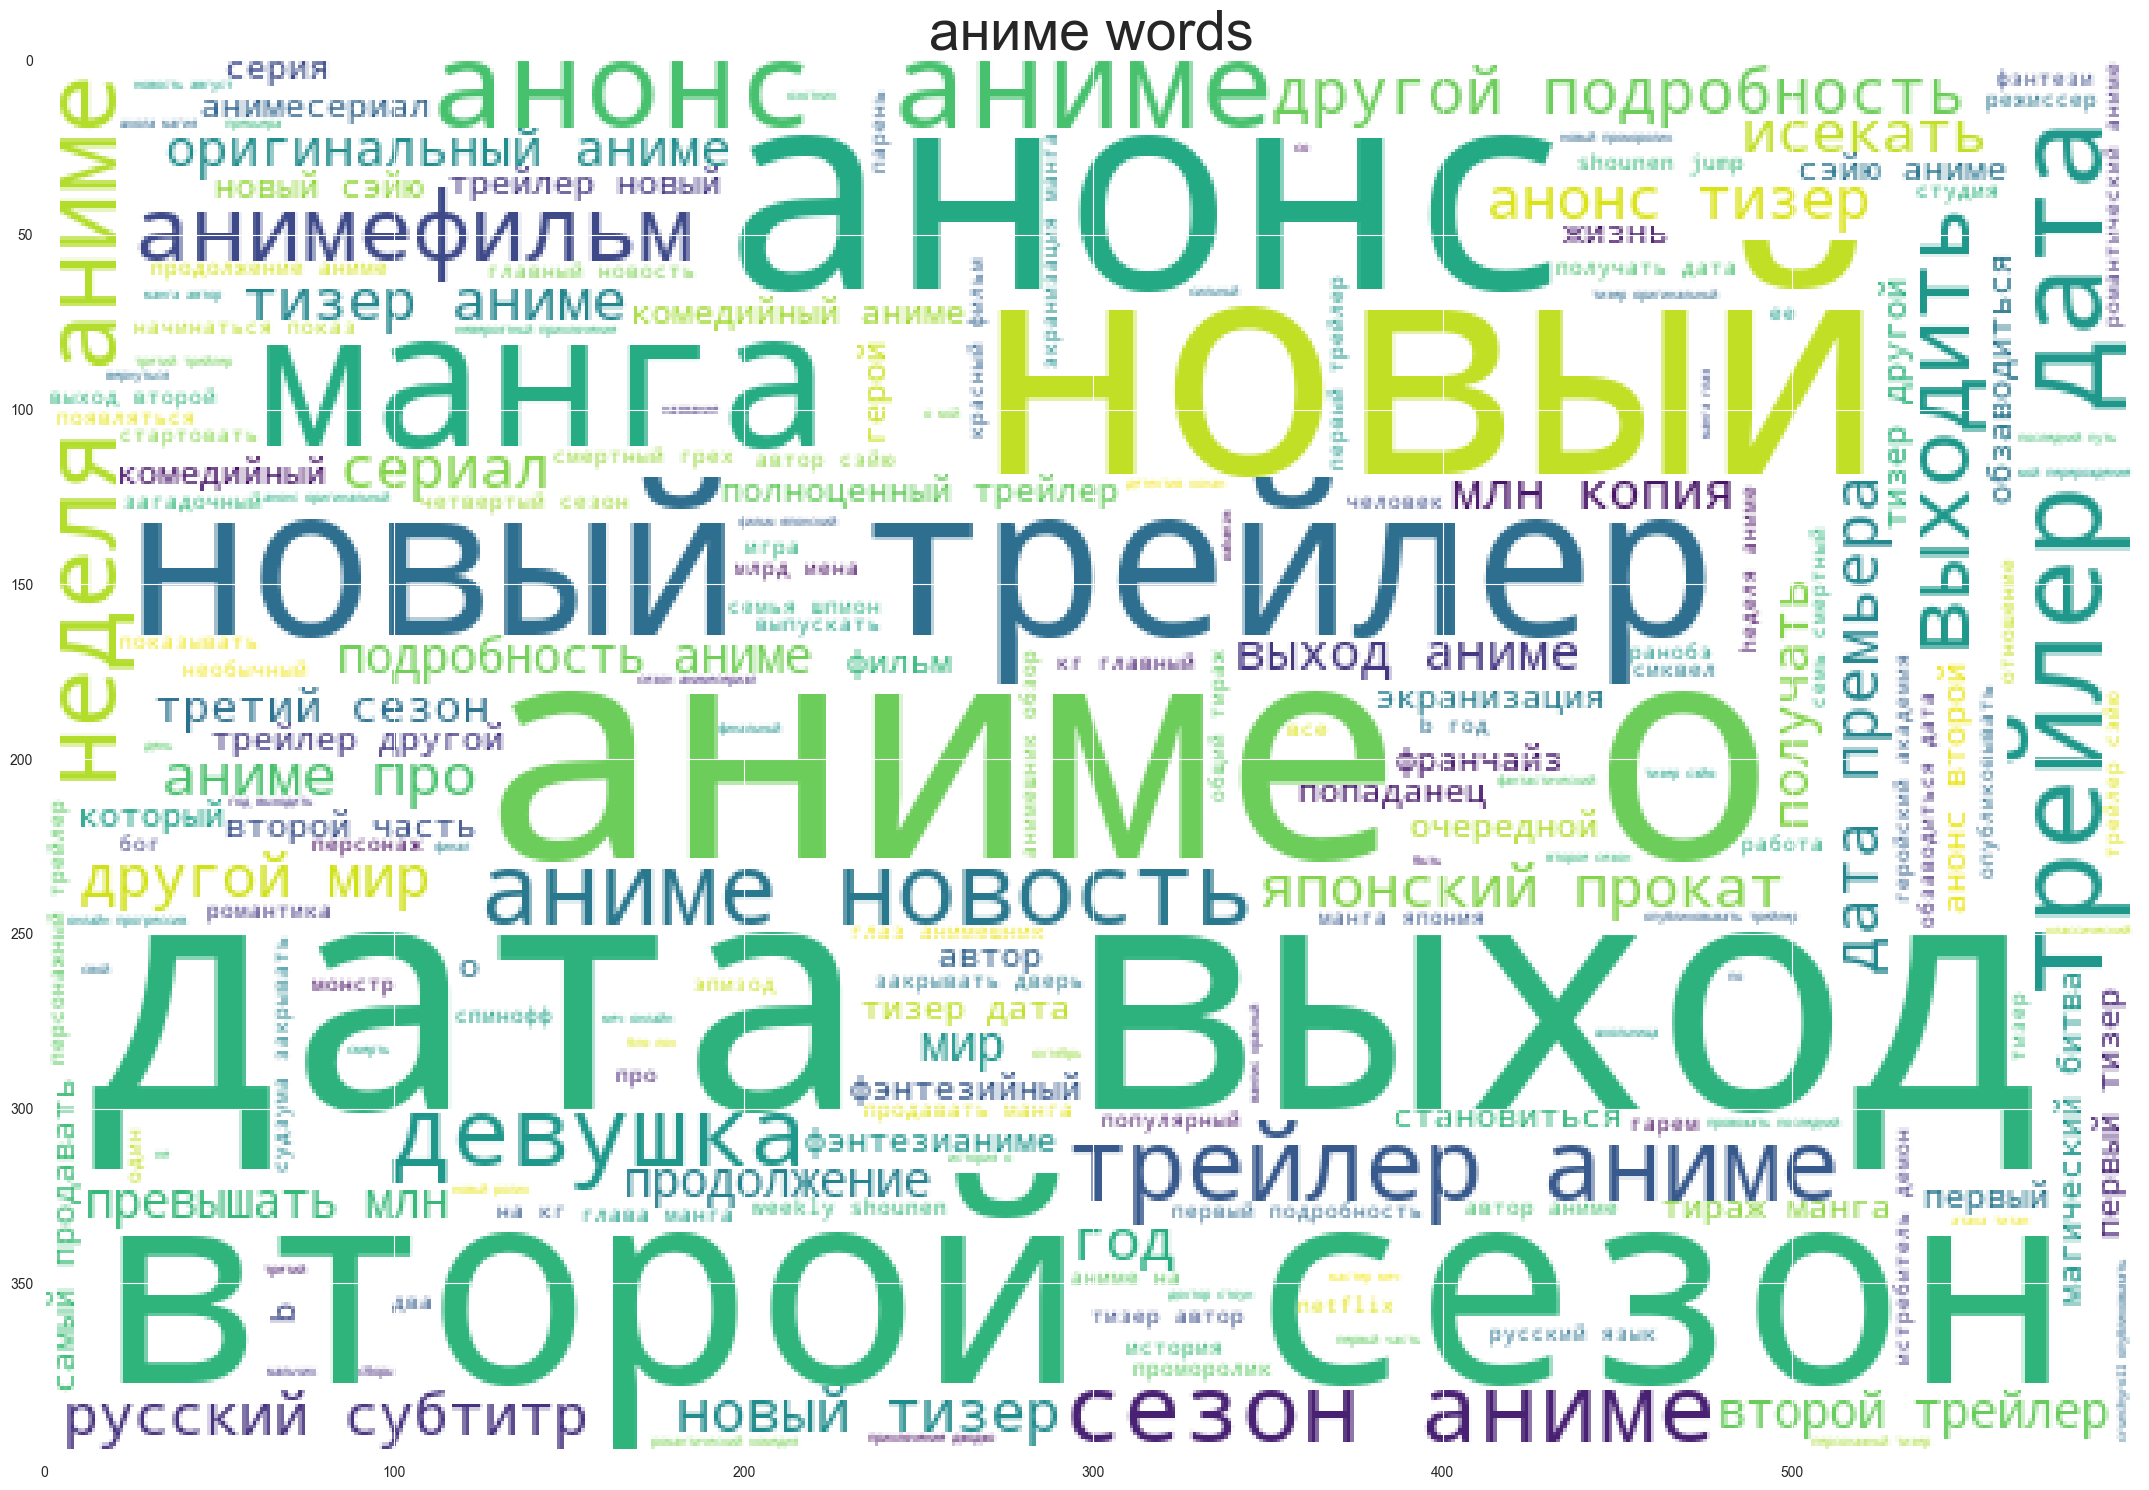

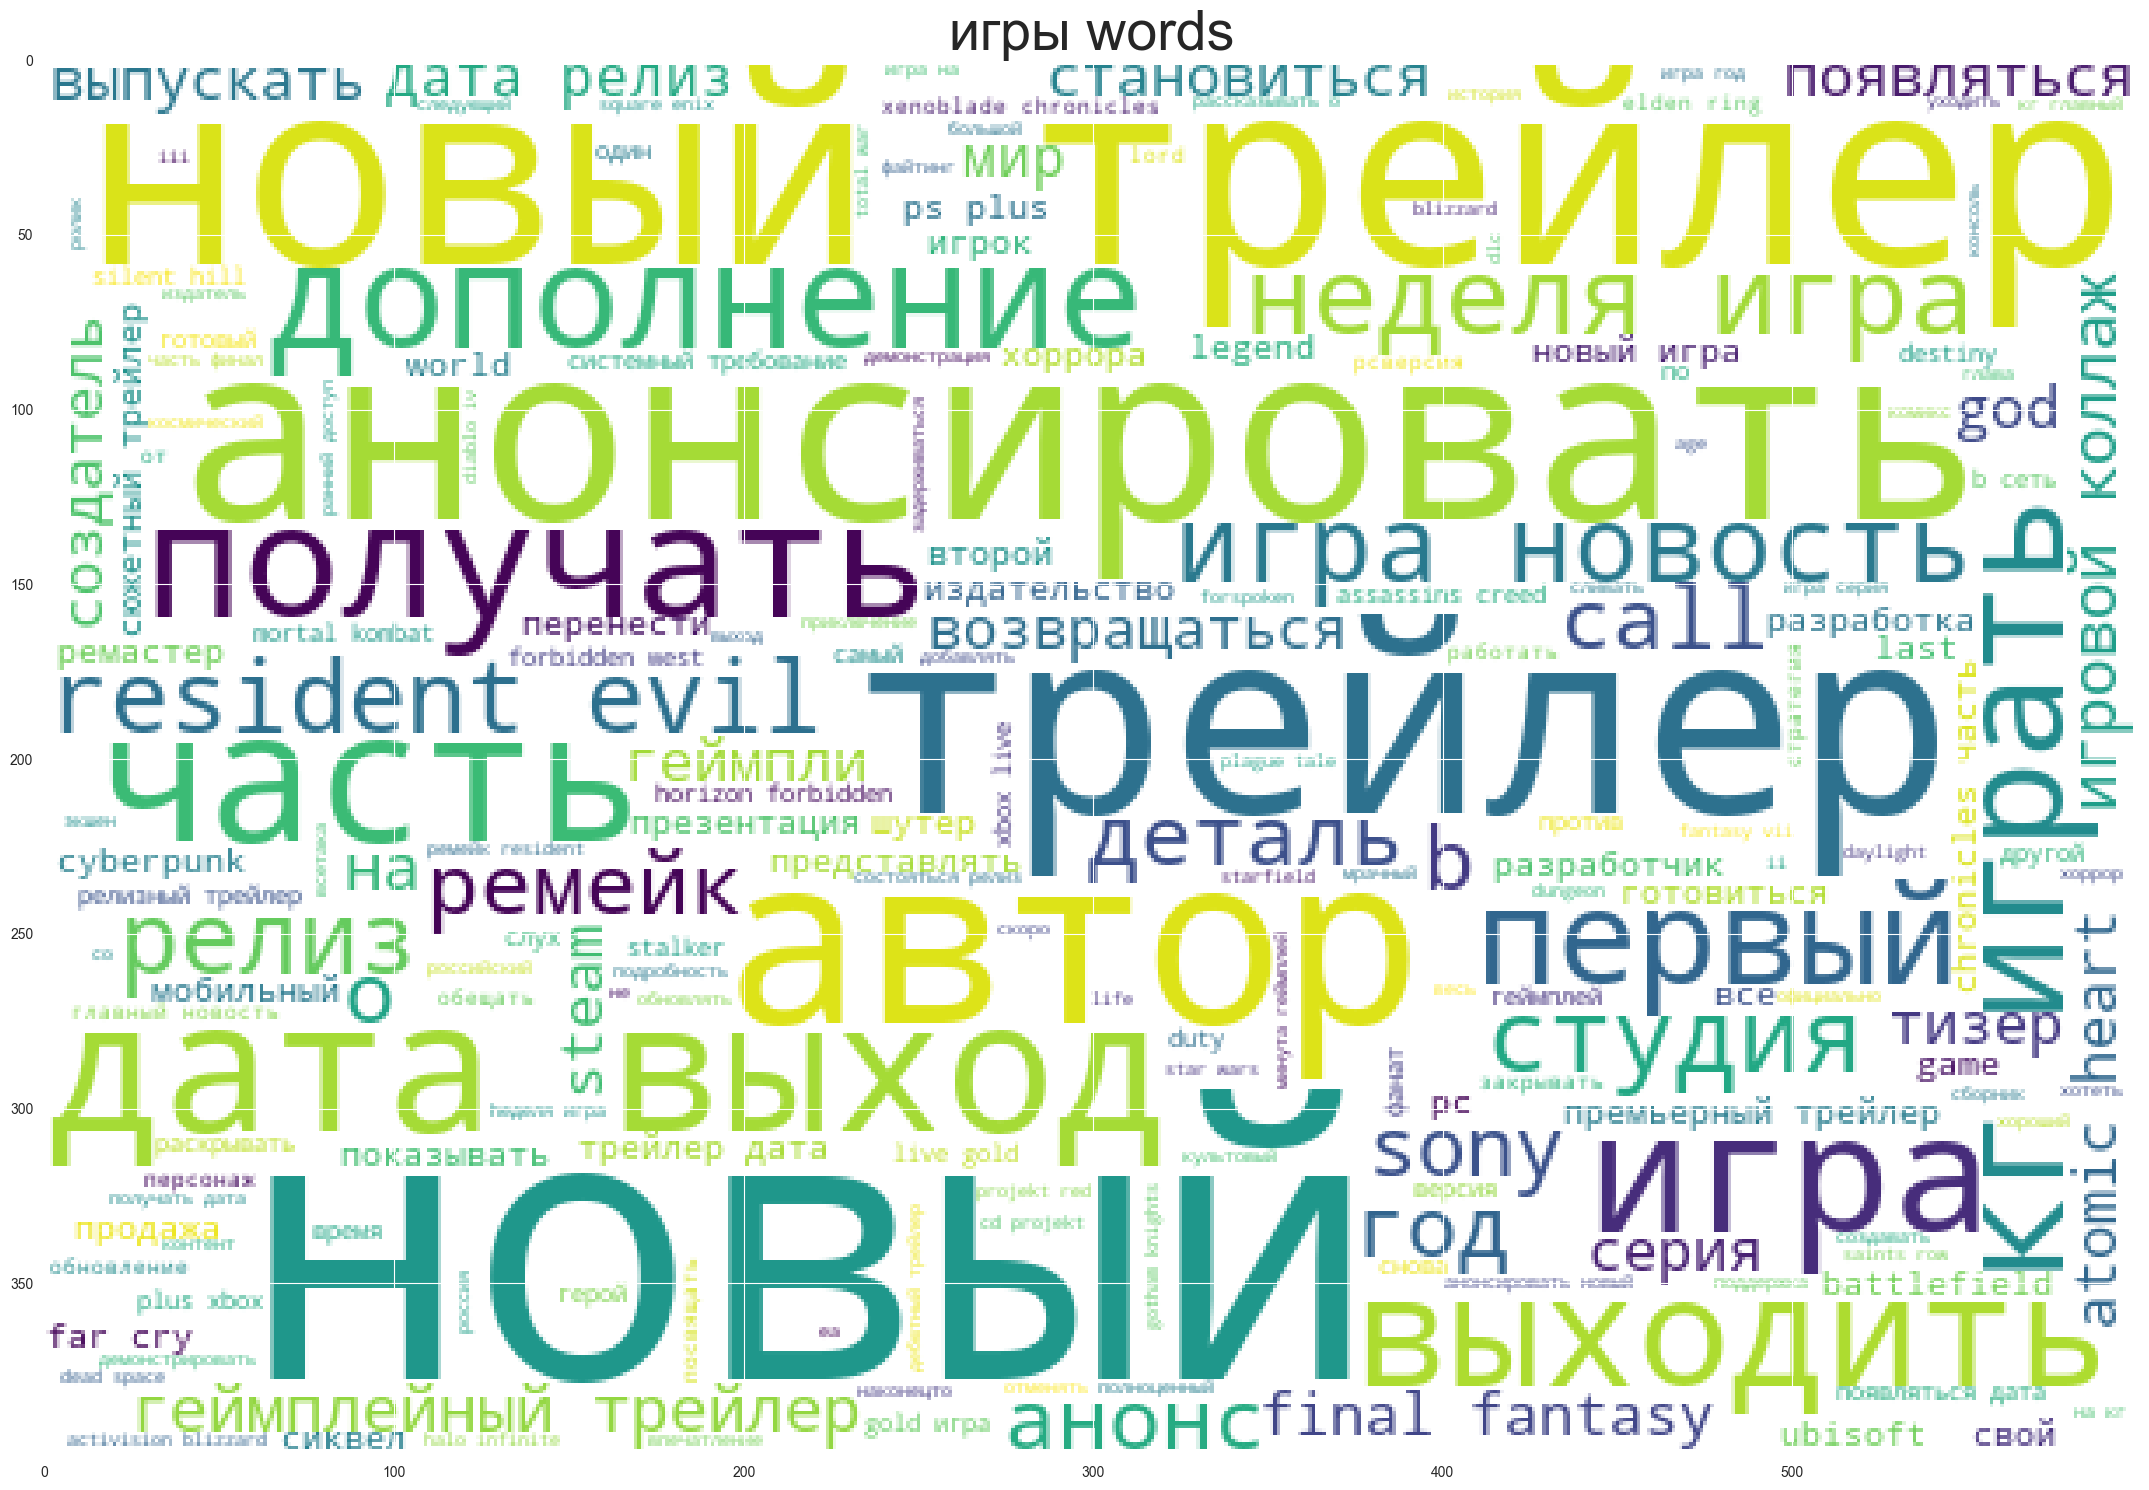

In [47]:
for topic in df.tags.unique():
    
    f, ax = plt.subplots(1, 1, figsize=[30, 15])
    wordcloud1 = WordCloud(background_color='white',
                            width=600,
                            height=400).generate(" ".join(df[df.tags == topic].title_clean))
    ax.imshow(wordcloud1)
    ax.set_title(f'{topic} words',fontsize=40)

    f.tight_layout()

- Многие новости освещают новинки и анносируют выходы контента

**Популярные слова в подзаголовке**

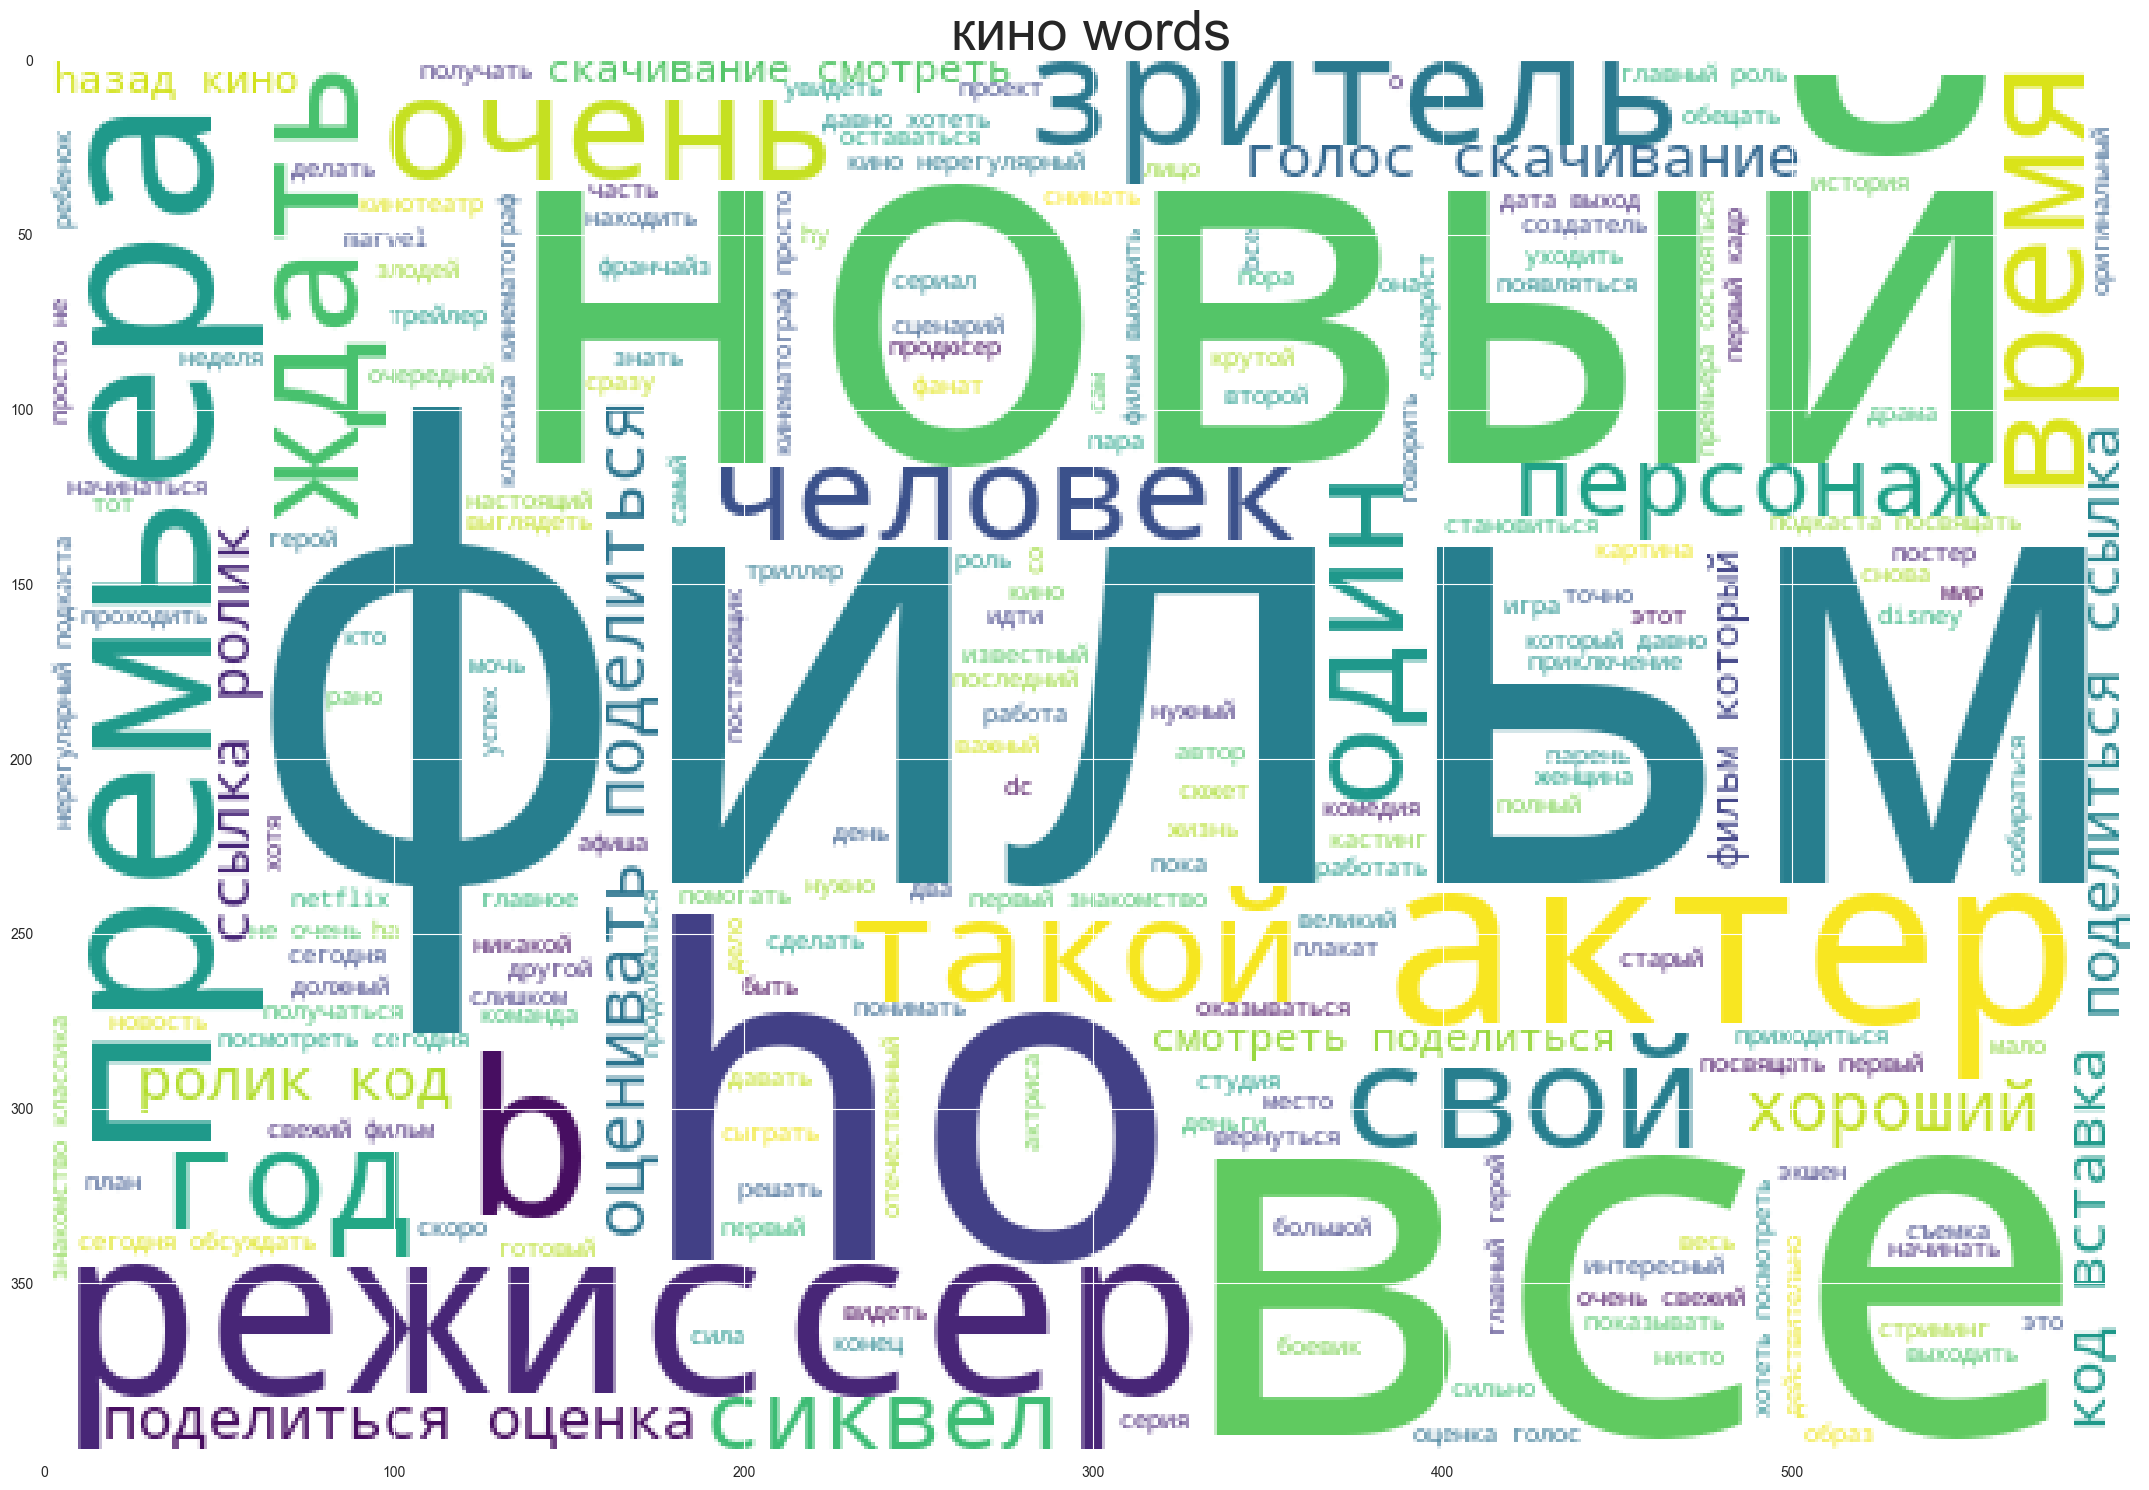

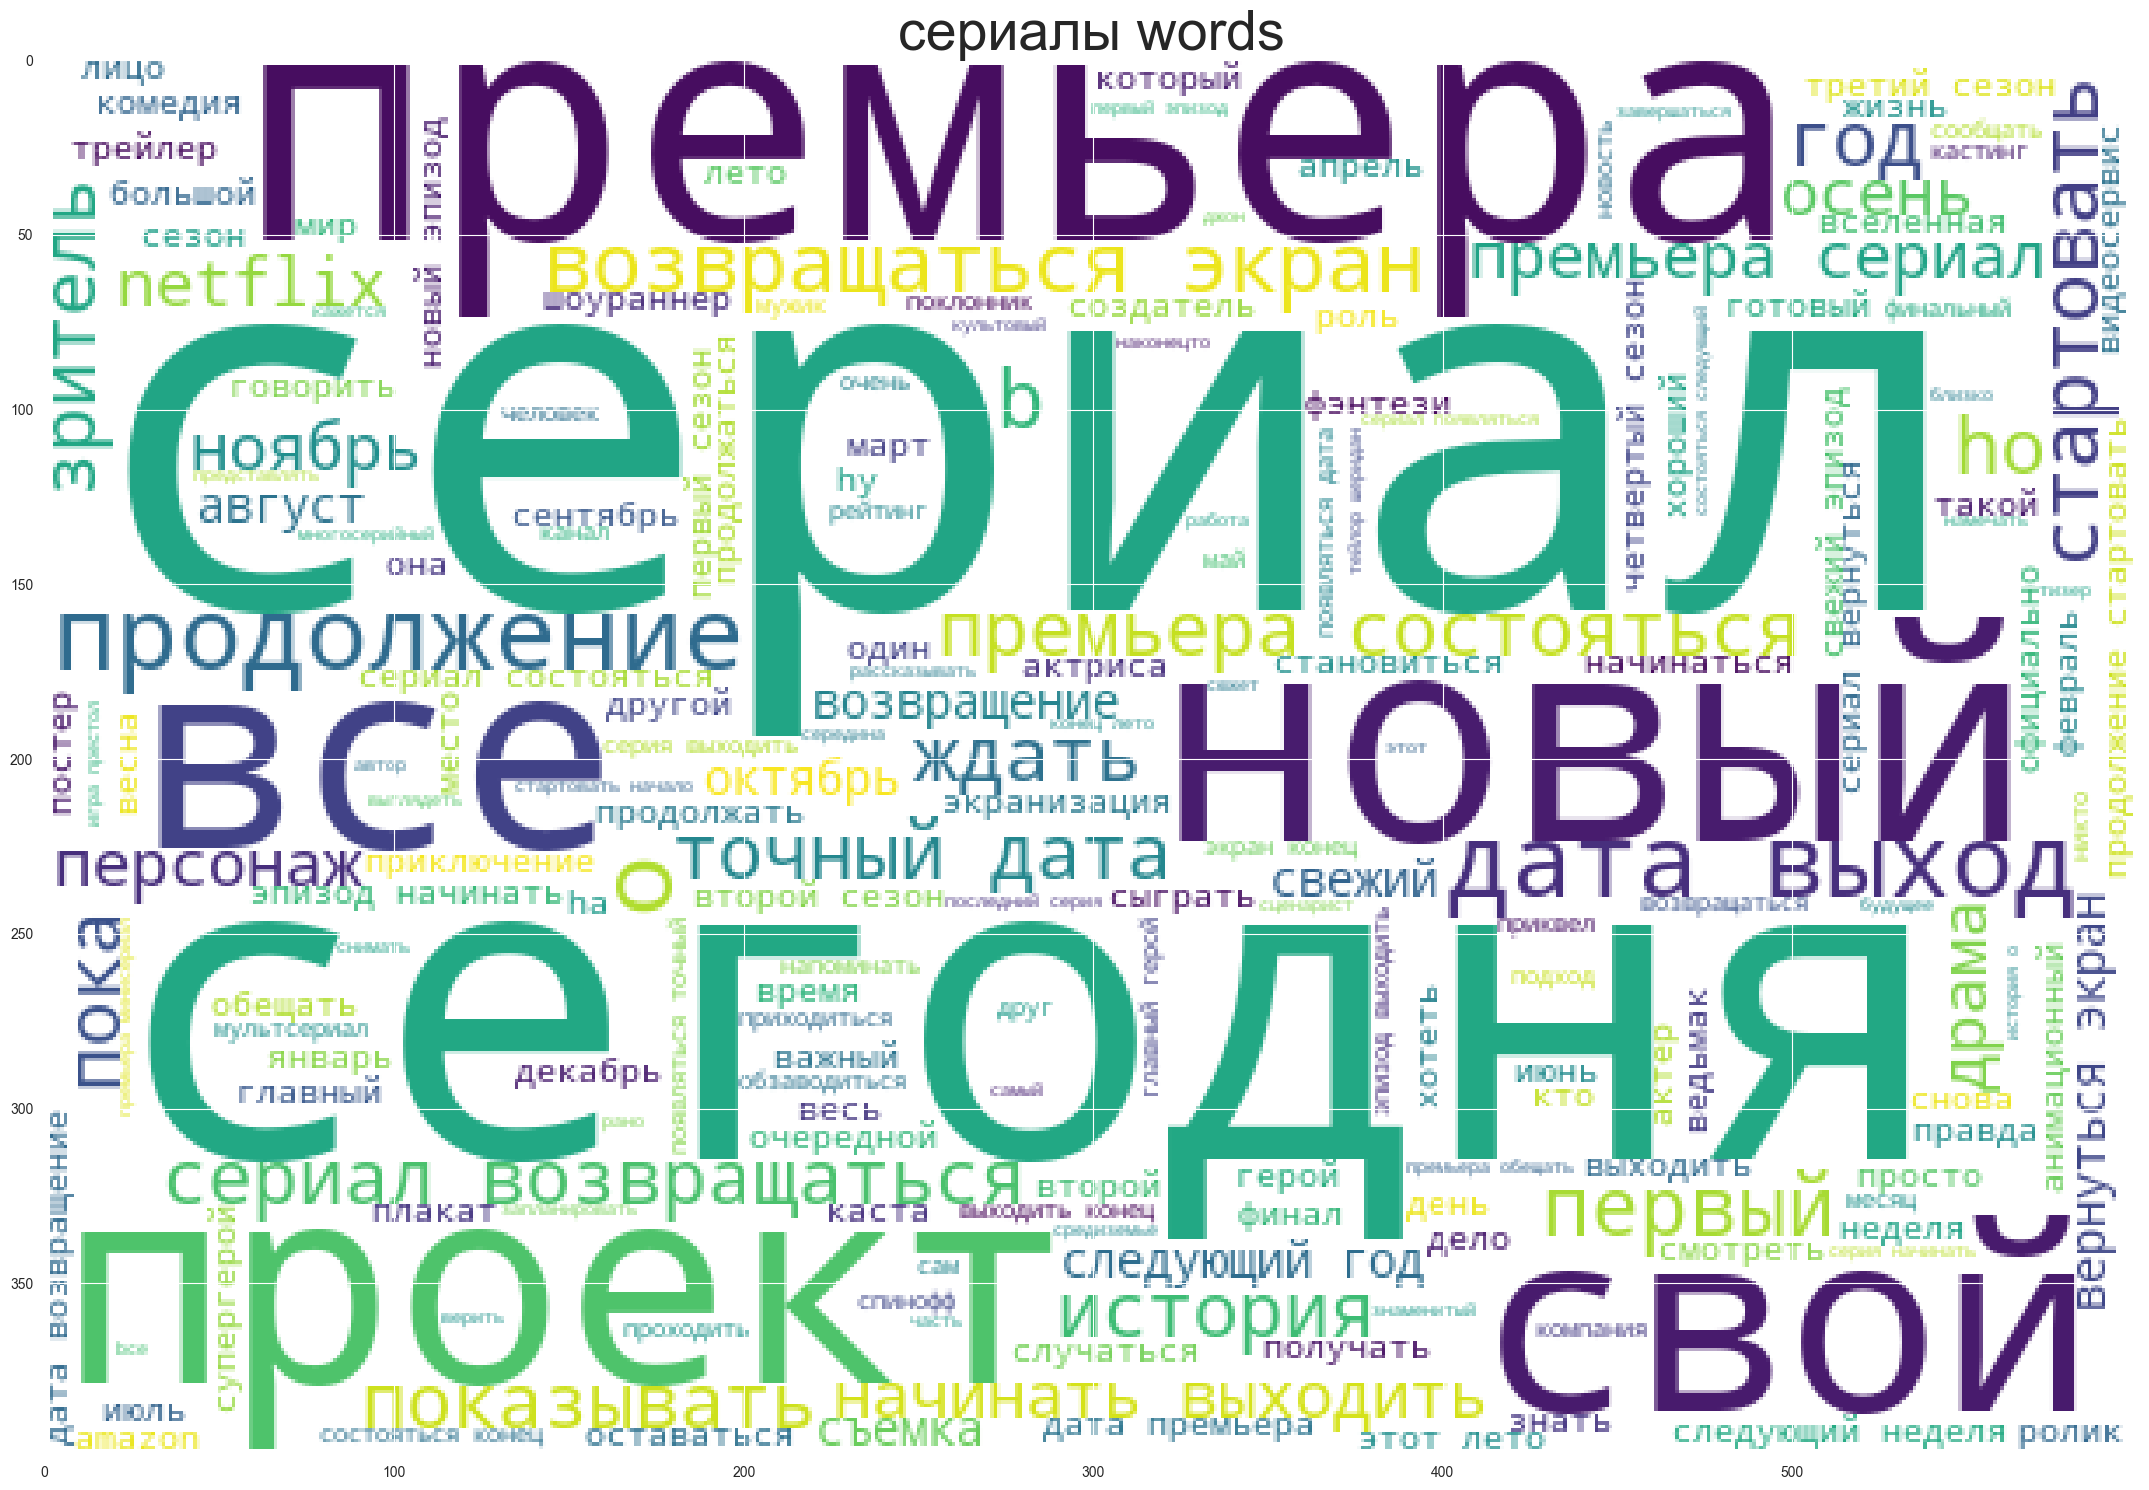

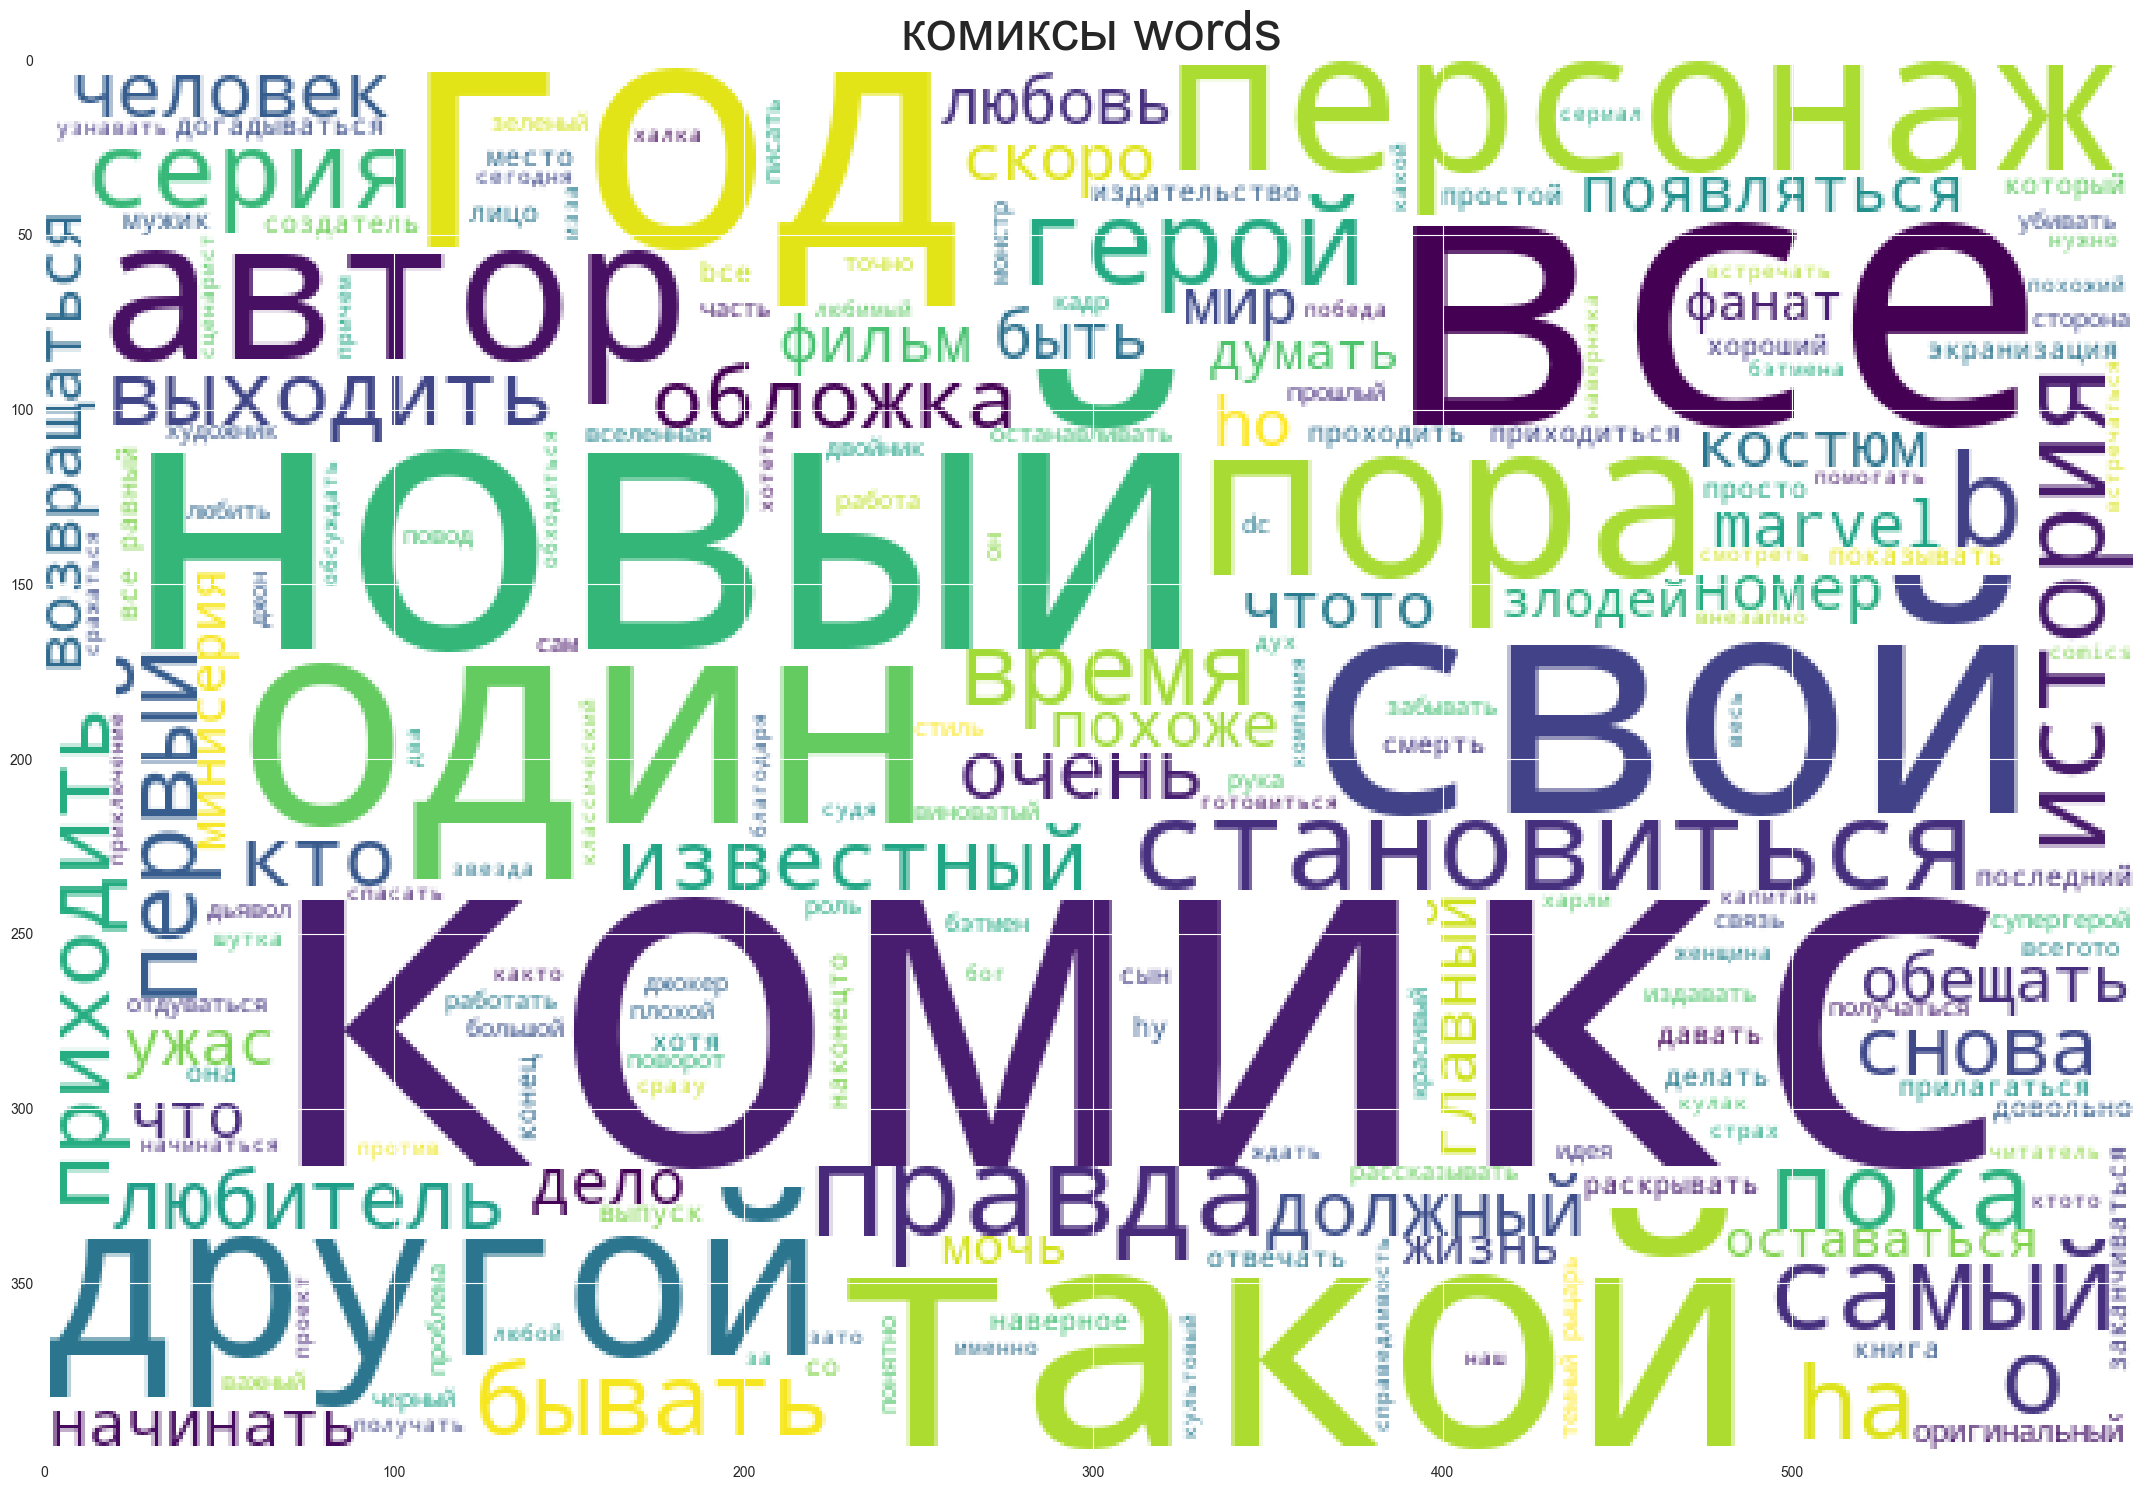

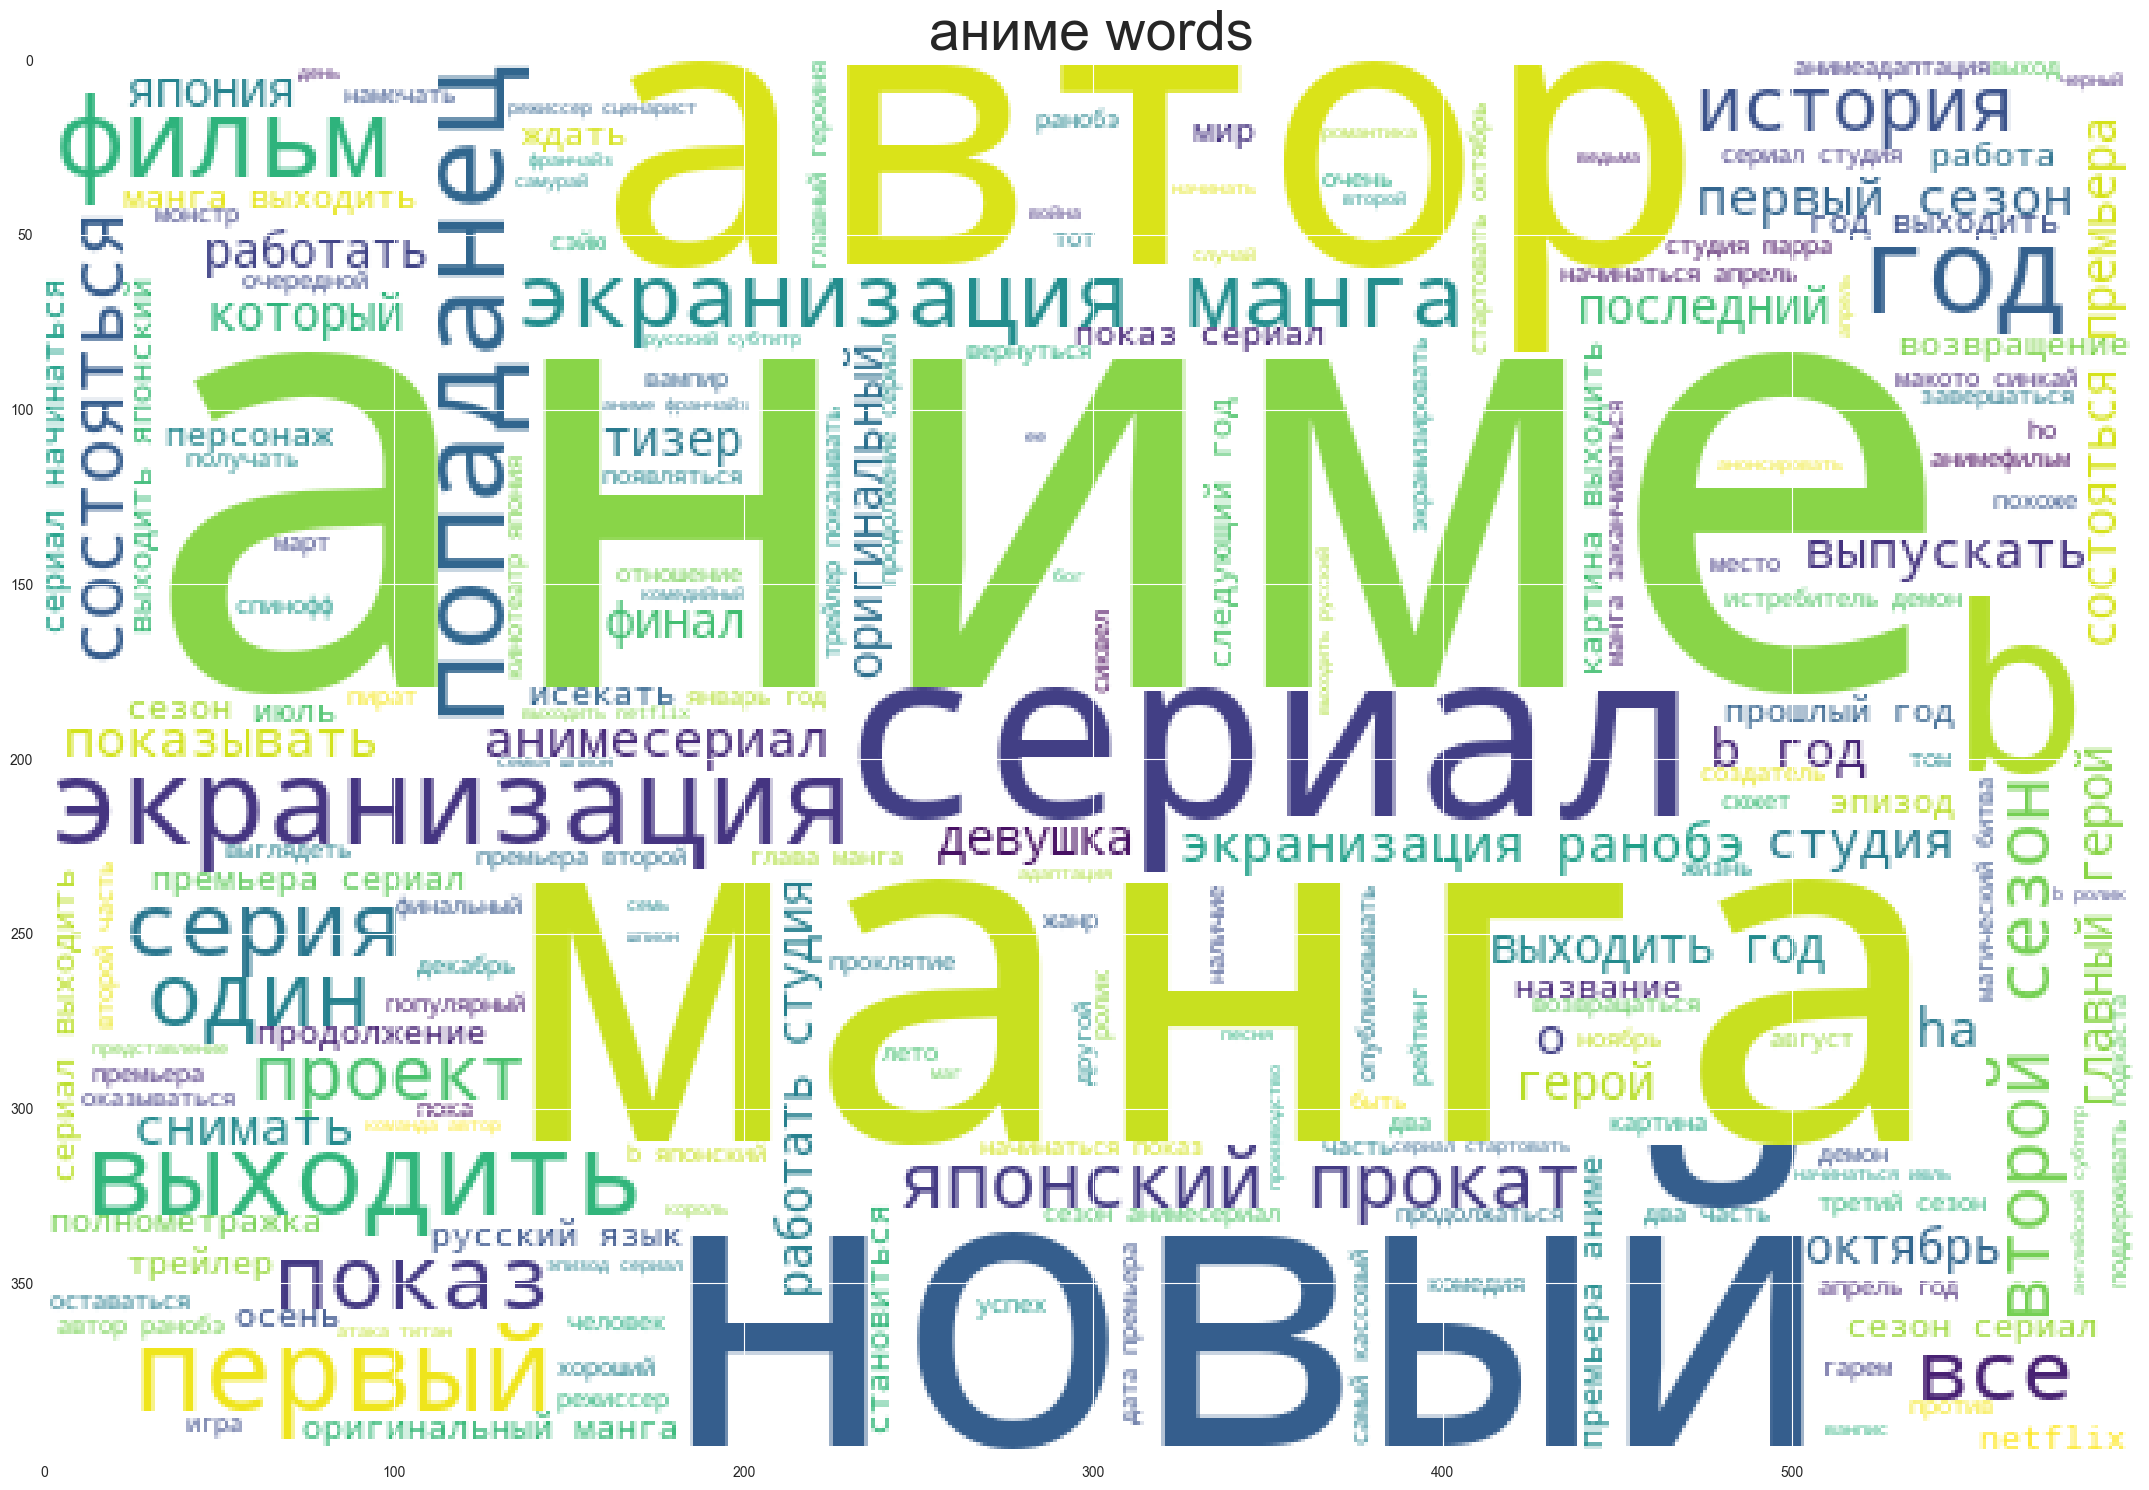

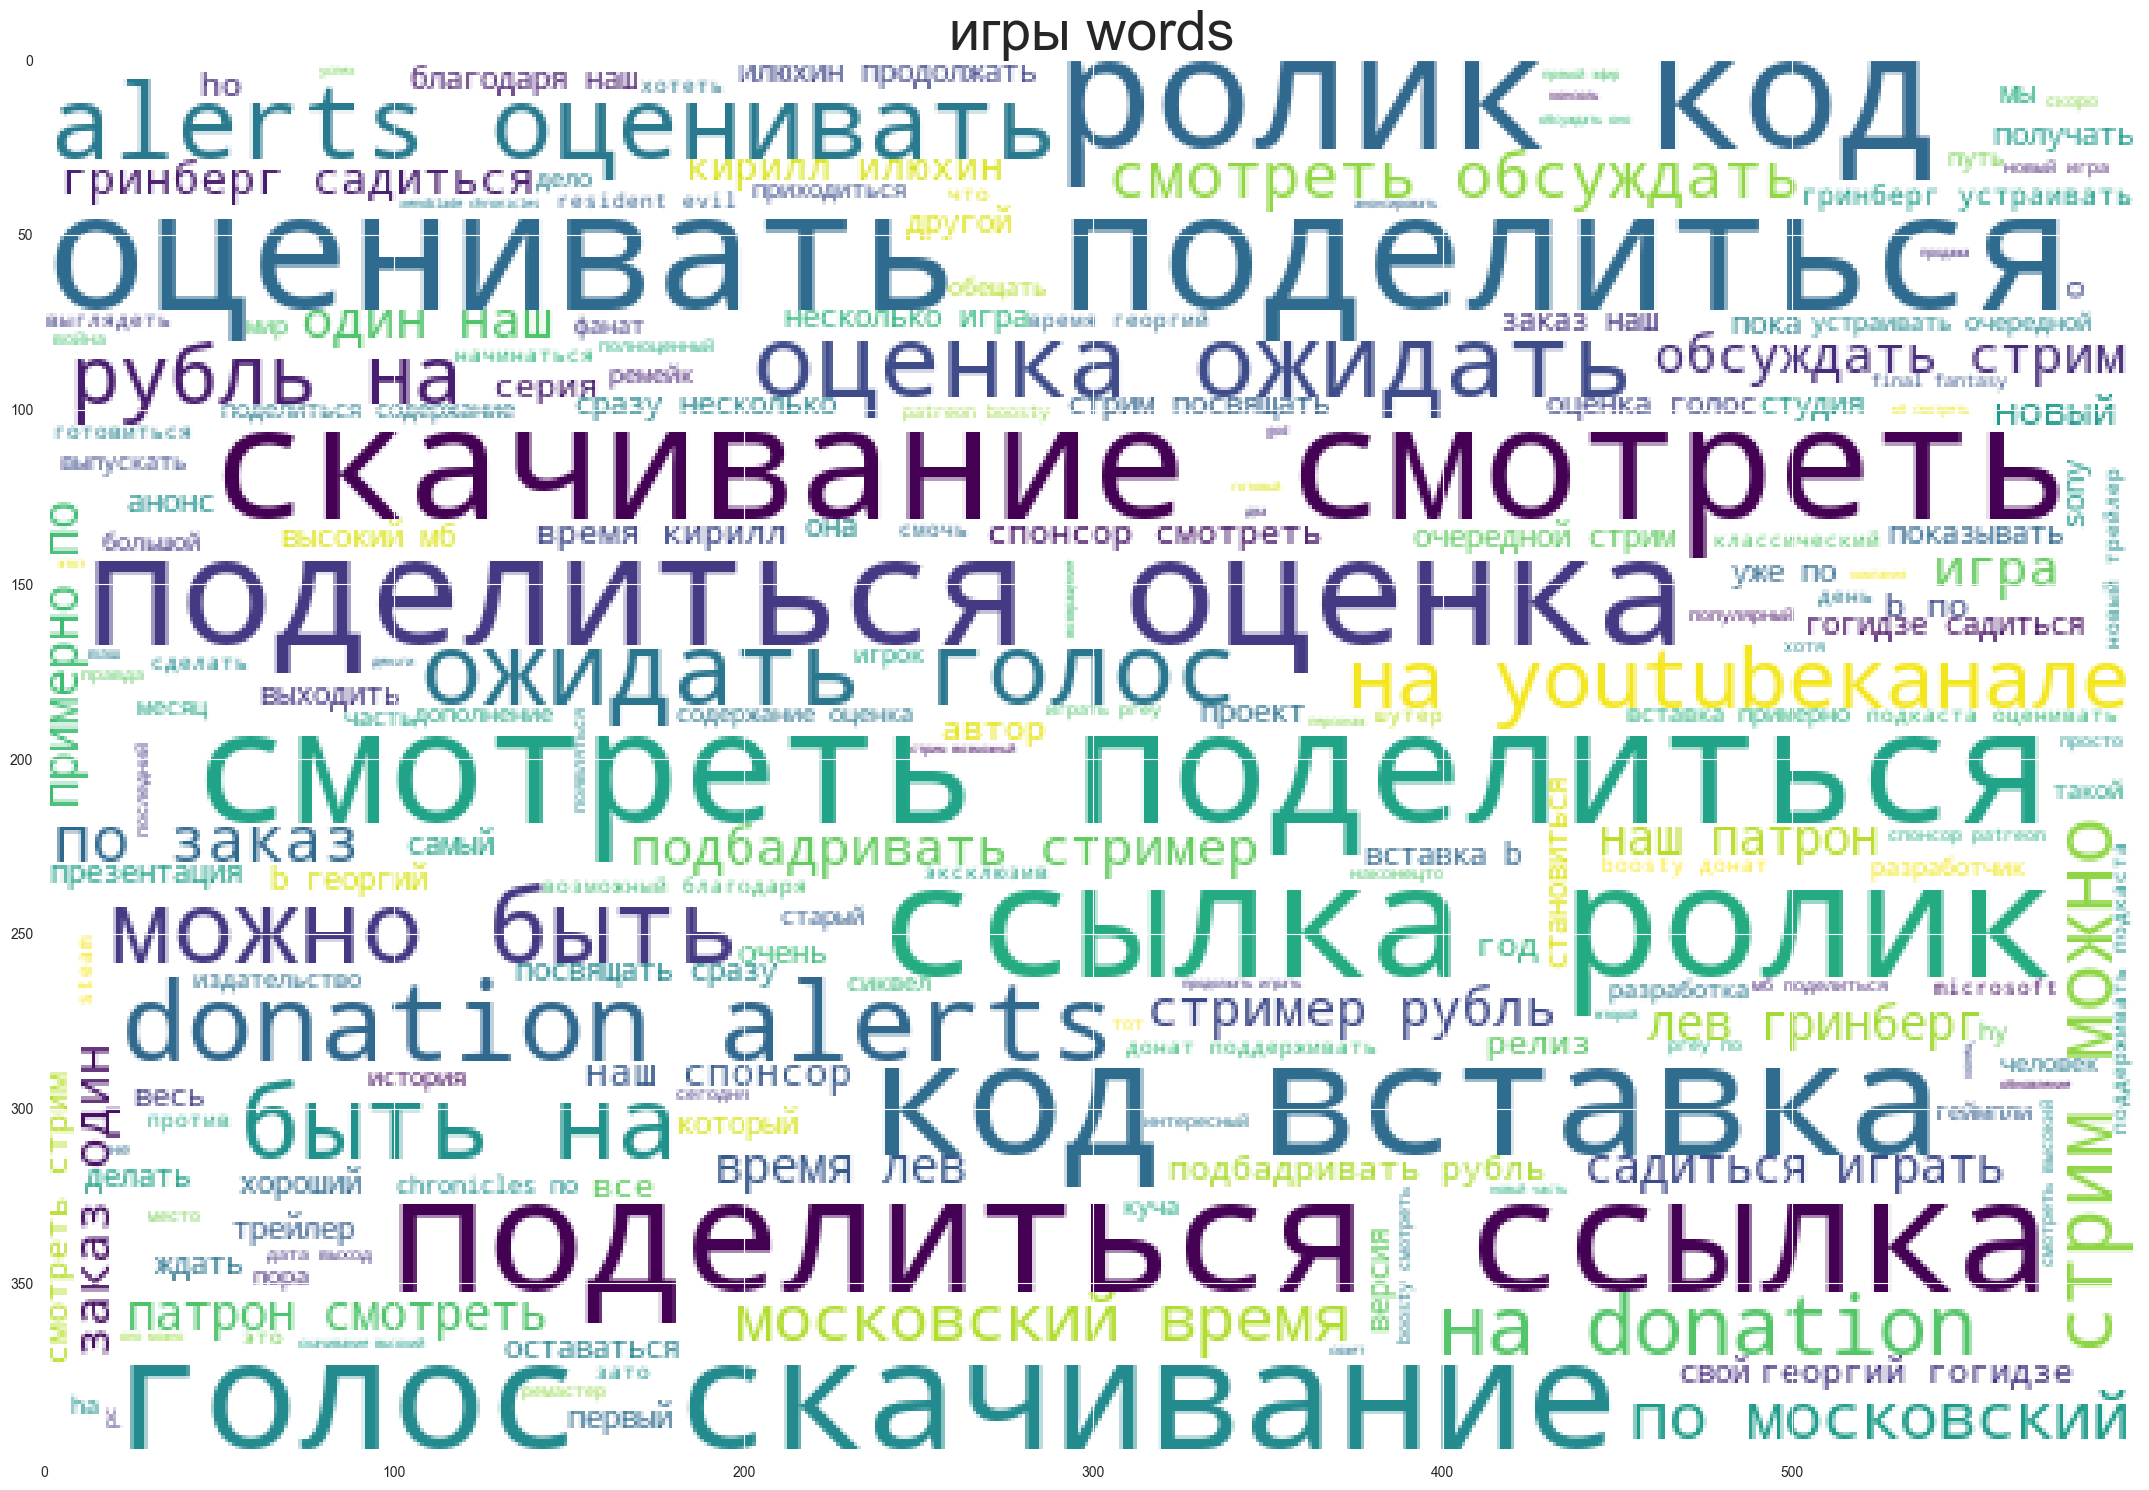

In [48]:
for topic in df.tags.unique():
    
    
    f, ax = plt.subplots(1, 1, figsize=[30, 15])
    wordcloud1 = WordCloud(background_color='white',
                            width=600,
                            height=400).generate(" ".join(df[df.tags == topic].subtitle_clean))
    ax.imshow(wordcloud1)
    ax.set_title(f'{topic} words',fontsize=40)

    f.tight_layout()

Необходимо пронормировать количество просмотров, чтобы число не зависело от даты выхода статьи. 


In [49]:
import datetime

df['lifetime'] = pd.to_datetime(df['datetime'], utc=True).apply(lambda x: (datetime.datetime.now(datetime.timezone.utc) - x).total_seconds())
df['lifetime'] = df['lifetime'].apply(lambda x: divmod(x, 60)[0]) # lifetime in minutes



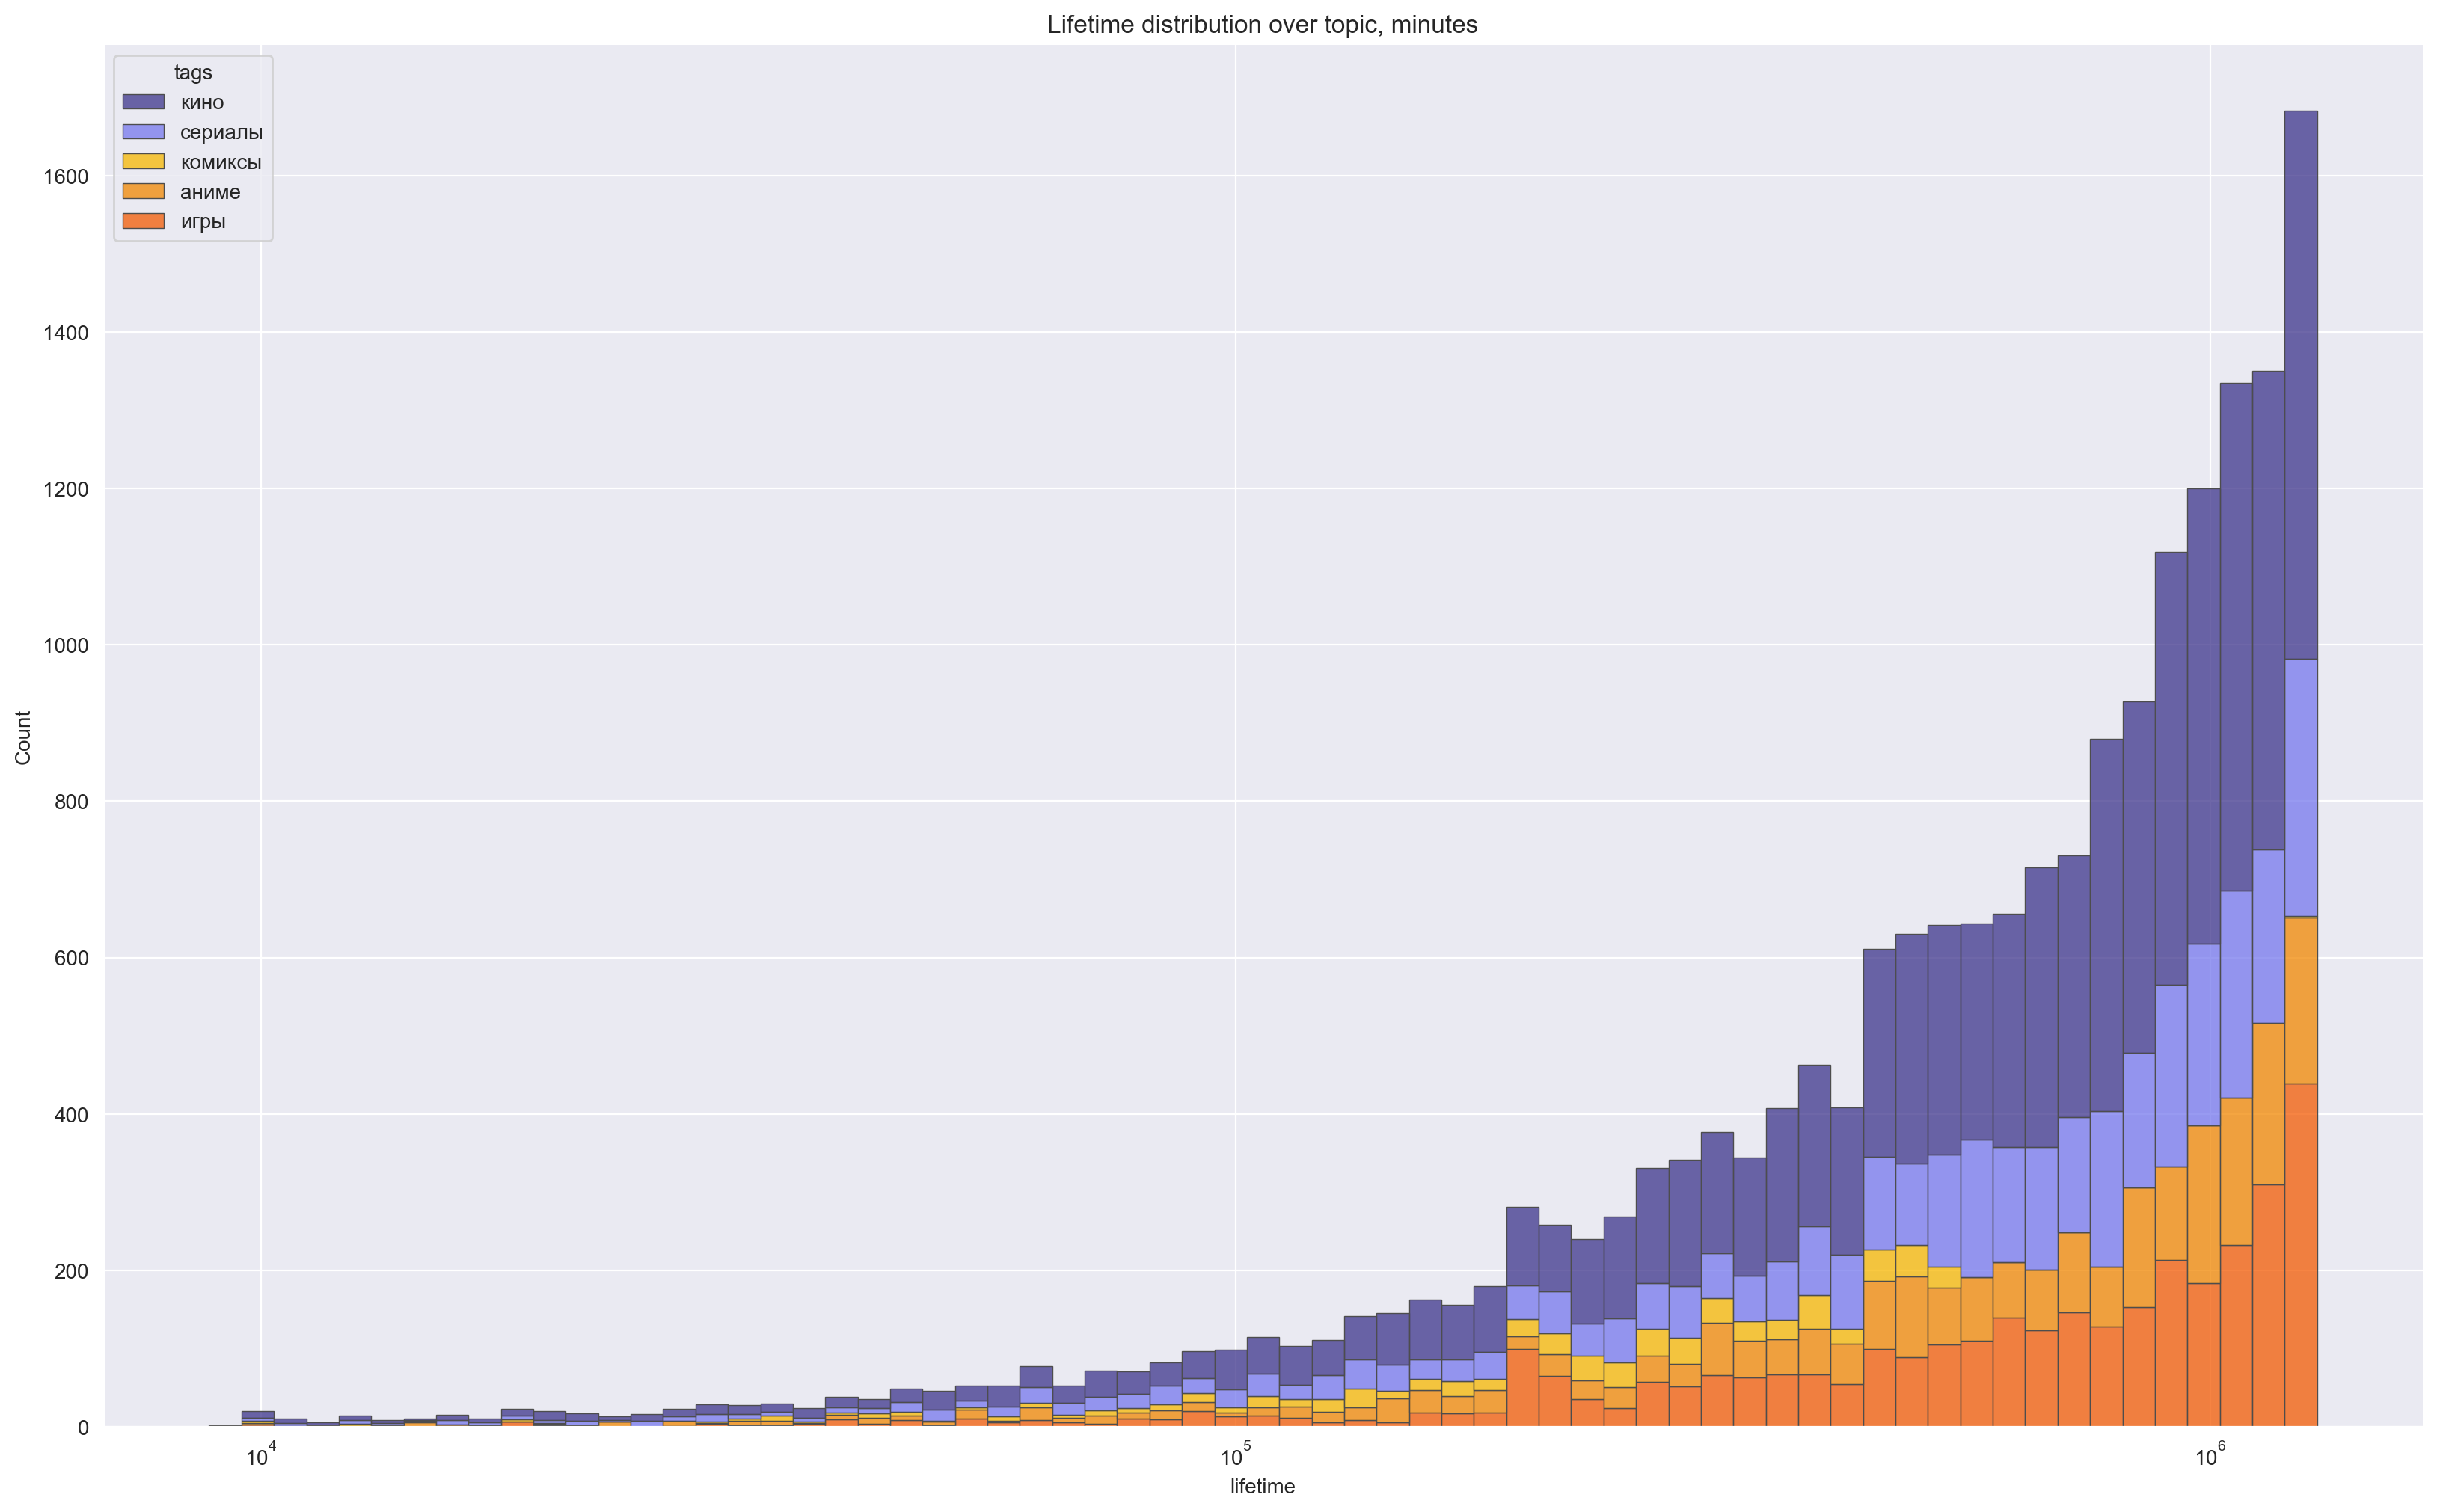

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="lifetime",
    hue="tags",
    multiple="stack",
    edgecolor=".3",
    palette=my_colors,
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

In [51]:
df['views_by_minutes'] = (df['views'] + 1) / df['lifetime']

In [52]:
df['log_views_by_minutes'] = np.log1p(df['views_by_minutes'])

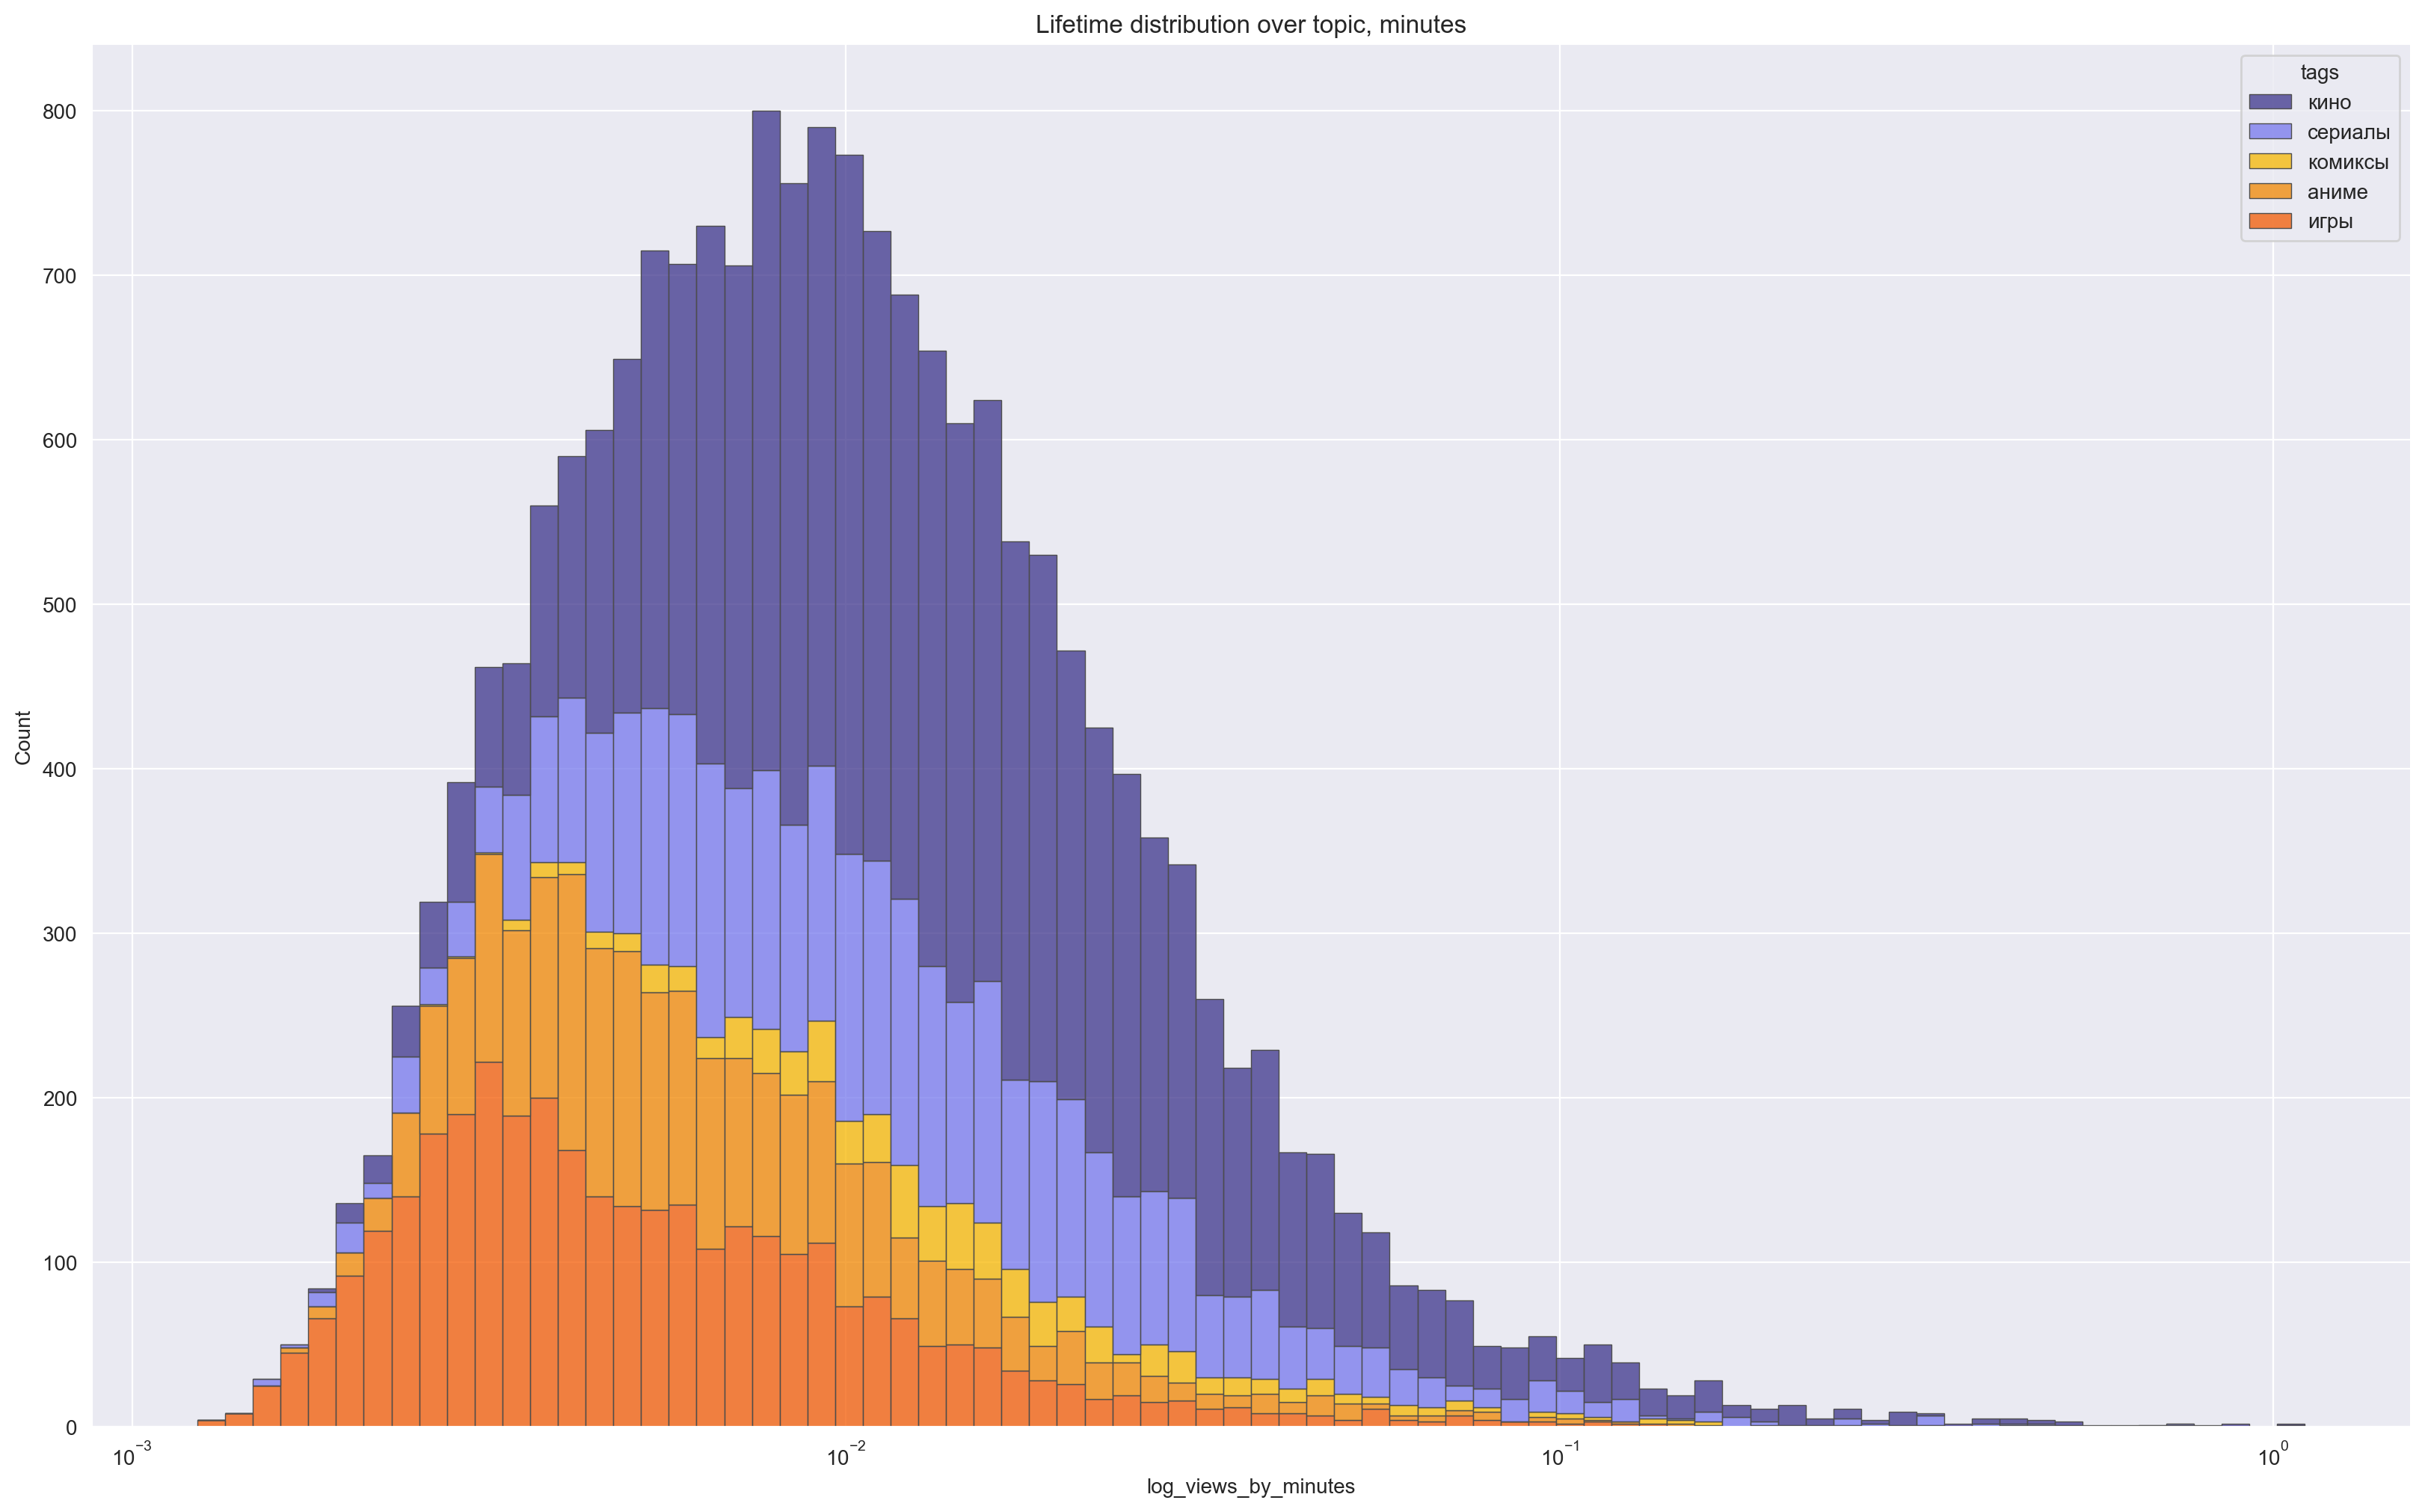

In [53]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="log_views_by_minutes",
    hue='tags',
    multiple="stack",
    edgecolor=".3",
    palette=my_colors,
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

Новый признак - количество просмотров в минуту, или средняя скорость роста количества просмотров, - имеет уже распределение, близкое к логнормальному.

## Заключение

- Были взяты данные с портала https://kg-portal.ru/. Просмотрели последние 20000 статей
- Почистили данные от нечитаемых символов, пропусков, стопслов.
- Есть новости за 2021, 2022 и 2023 года. За 2022 год больше всего, так как его спарсили полностью. Больше всего новостей приходится на лето. Меньше всего на февраль. Меньше всего новостей в выходные и больше всего в середине недели (скорее всего это связано с выходом новых фильмов)
- Средняя длина текста 1044 символа, количество слов - 110. Средняя длина названия 82, количество слов - 9. Средняя длина подзаголовка 38, количество слов - 4
- Новости по фильмам и сериалам набирают в среднем больше просмотров
- Добавили новый признак - средняя скорость роста количества просмотров,
- Среди текстов всех тем популярные слова совпадают, так как часто новости выходят о премьерах 
